In [75]:
require(dplyr)
require(scales)
require(tidyverse)


d <- read.csv("e2-comb-data.csv")
d <- d %>% filter(benchmark != "benchmarklibpcap_fuzz_both") %>% filter(fuzzer != "honggfuzz")
d$coverage_inc <- d$edges_covered - d$initial_coverage
# d$cif <- factor(d$coverage_inc, ordered=TRUE)
static_cols <- c("total_shared", "total_eq", "total_ineq", "total_indir", "bin_text_size")

statics <- na.omit(unique(d[c(static_cols, c("benchmark"))]))

d <- d %>% filter(benchmark != "lcms-2017-03-21")
cols <- c("benchmark", "fuzzer", "corpus_size",
                "initial_coverage", "ineq_reached", "ineq_unexplored",
                "indir_reached", "shared_reached", "mean_exec_ns",
                "mean_size_bytes", "coverage_inc", "eq_reached", "eq_unexplored",
                 "edges_covered", "per_target_trial", "q100_mean_size_bytes", "q100_exec_ns")
d <- d[cols]
d$mean_exec_ms = d$mean_exec_ns / 1000000

d$ineq_unex_perc <- d$ineq_unexplored / d$initial_coverage

scaled_d <- d %>%
    mutate_if(is.numeric, rescale)
scaled_d$coverage_inc_unscaled <- d$coverage_inc 
scaled_d <- scaled_d %>% drop_na() %>% as.data.frame



d_statics <- merge(x = d, y = statics, by = "benchmark", all.x = TRUE)
mec <- d %>% group_by(benchmark) %>% summarise(max(edges_covered))
d_statics <- merge(x = d_statics, y = mec, by = "benchmark", all.x = TRUE)
head(d_statics)
head(d)
dim(d)
dim(d_statics)

,benchmark,fuzzer,corpus_size,initial_coverage,ineq_reached,ineq_unexplored,indir_reached,shared_reached,mean_exec_ns,mean_size_bytes,⋯,q100_mean_size_bytes,q100_exec_ns,mean_exec_ms,ineq_unex_perc,total_shared,total_eq,total_ineq,total_indir,bin_text_size,max(edges_covered)
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,bloaty_fuzz_target,afl,NA,6261,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,5358,48128,17613,2283,8835,7155
2,bloaty_fuzz_target,entropic,144,6202,2056,1549,69,0,3801204,13428.951,⋯,514304,20925436,3.801204,0.2497581,5358,48128,17613,2283,8835,7155
3,bloaty_fuzz_target,libfuzzer,66,5628,1688,1313,67,0,4565922,20523.636,⋯,728696,25152943,4.565922,0.2332978,5358,48128,17613,2283,8835,7155
4,bloaty_fuzz_target,afl,71,5423,1629,1227,58,0,3815621,7671.028,⋯,472998,8520200,3.815621,0.2262585,5358,48128,17613,2283,8835,7155
5,bloaty_fuzz_target,entropic,24,4684,1368,1134,53,0,4567336,4516.167,⋯,67883,22031144,4.567336,0.2421008,5358,48128,17613,2283,8835,7155
6,bloaty_fuzz_target,libfuzzer,140,6196,2026,1542,69,0,3937004,17151.714,⋯,971224,19280225,3.937004,0.2488702,5358,48128,17613,2283,8835,7155


,benchmark,fuzzer,corpus_size,initial_coverage,ineq_reached,ineq_unexplored,indir_reached,shared_reached,mean_exec_ns,mean_size_bytes,coverage_inc,eq_reached,eq_unexplored,edges_covered,per_target_trial,q100_mean_size_bytes,q100_exec_ns,mean_exec_ms,ineq_unex_perc
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,harfbuzz-1.3.2,afl,32,4241,1332,1061,23,0,3169912,15990.03125,2395,1839,1280,6636,0,393268,3853513,3.169912,0.2501768
2,libjpeg-turbo-07-2017,afl,20,1387,454,381,10,0,3716716,55.20000,637,882,661,2024,0,149,12872743,3.716716,0.2746936
3,libpcap_fuzz_both,afl,46,1441,310,238,32,0,4644766,41.30435,1199,1260,859,2640,0,106,10448585,4.644766,0.1651631
4,libpng-1.2.56,afl,36,752,195,163,7,0,2671579,816.00000,142,650,546,894,0,19513,4008061,2.671579,0.2167553
5,libxslt_xpath,afl,139,7856,1561,1099,68,0,18586858,3660.50360,1220,4116,3178,9076,0,443972,2099863158,18.586858,0.1398931
6,mbedtls_fuzz_dtlsclient,afl,20,2217,566,462,22,0,3025270,389.85000,526,1510,1266,2743,0,590,3616277,3.025270,0.2083897


[1] 1152   19

[1] 1152   25

In [59]:

# This warning is misleading, they are scaled by group
group_scaled_d <- d %>% group_by(benchmark) %>%
    mutate_if(is.numeric, rescale) %>% ungroup

group_scaled_d$coverage_inc_unscaled <- d$coverage_inc 
scaled_d <- scaled_d %>% drop_na() %>% as.data.frame

`mutate_if()` ignored the following grouping variables:
• Column `benchmark`


In [73]:
ranks = c()

ranker = function(d) {

for (rown in 1:nrow(d)) {
    rank = NA
    for (rown_inner in 1:nrow(d)) {
        if (d[rown, "initial_coverage"] == d[rown_inner, "initial_coverage"] &&
            d[rown, "corpus_size"] == d[rown_inner, "corpus_size"] &&
            d[rown, "benchmark"] == d[rown_inner, "benchmark"] &&
            d[rown, "fuzzer"] != d[rown_inner, "fuzzer"]) {
            if (is.na(rank)) {
                rank <- 1
            }
            if (d[rown, "coverage_inc"] < d[rown_inner, "coverage_inc"]) {
                rank <- rank + 1
            }
        }
    }
    ranks[rown] = rank
}
    ranks
}
d <- d %>% drop_na()
ranks <- ranker(d)
d$per_trial_ranks <- factor(ranks, ordered=TRUE)
d$per_trial_ranks_numeric <- ranks

scaled_d <- scaled_d %>% drop_na()
ranks <- ranker(scaled_d)
scaled_d$per_trial_ranks <- factor(ranks, ordered=TRUE)
scaled_d$per_trial_ranks_numeric <- ranks

group_scaled_d <- group_scaled_d %>% drop_na()
ranks <- ranker(group_scaled_d)
group_scaled_d$per_trial_ranks <- factor(ranks, ordered=TRUE)
group_scaled_d$per_trial_ranks_numeric <- ranks




ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'per_trial_ranks_numeric' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capt

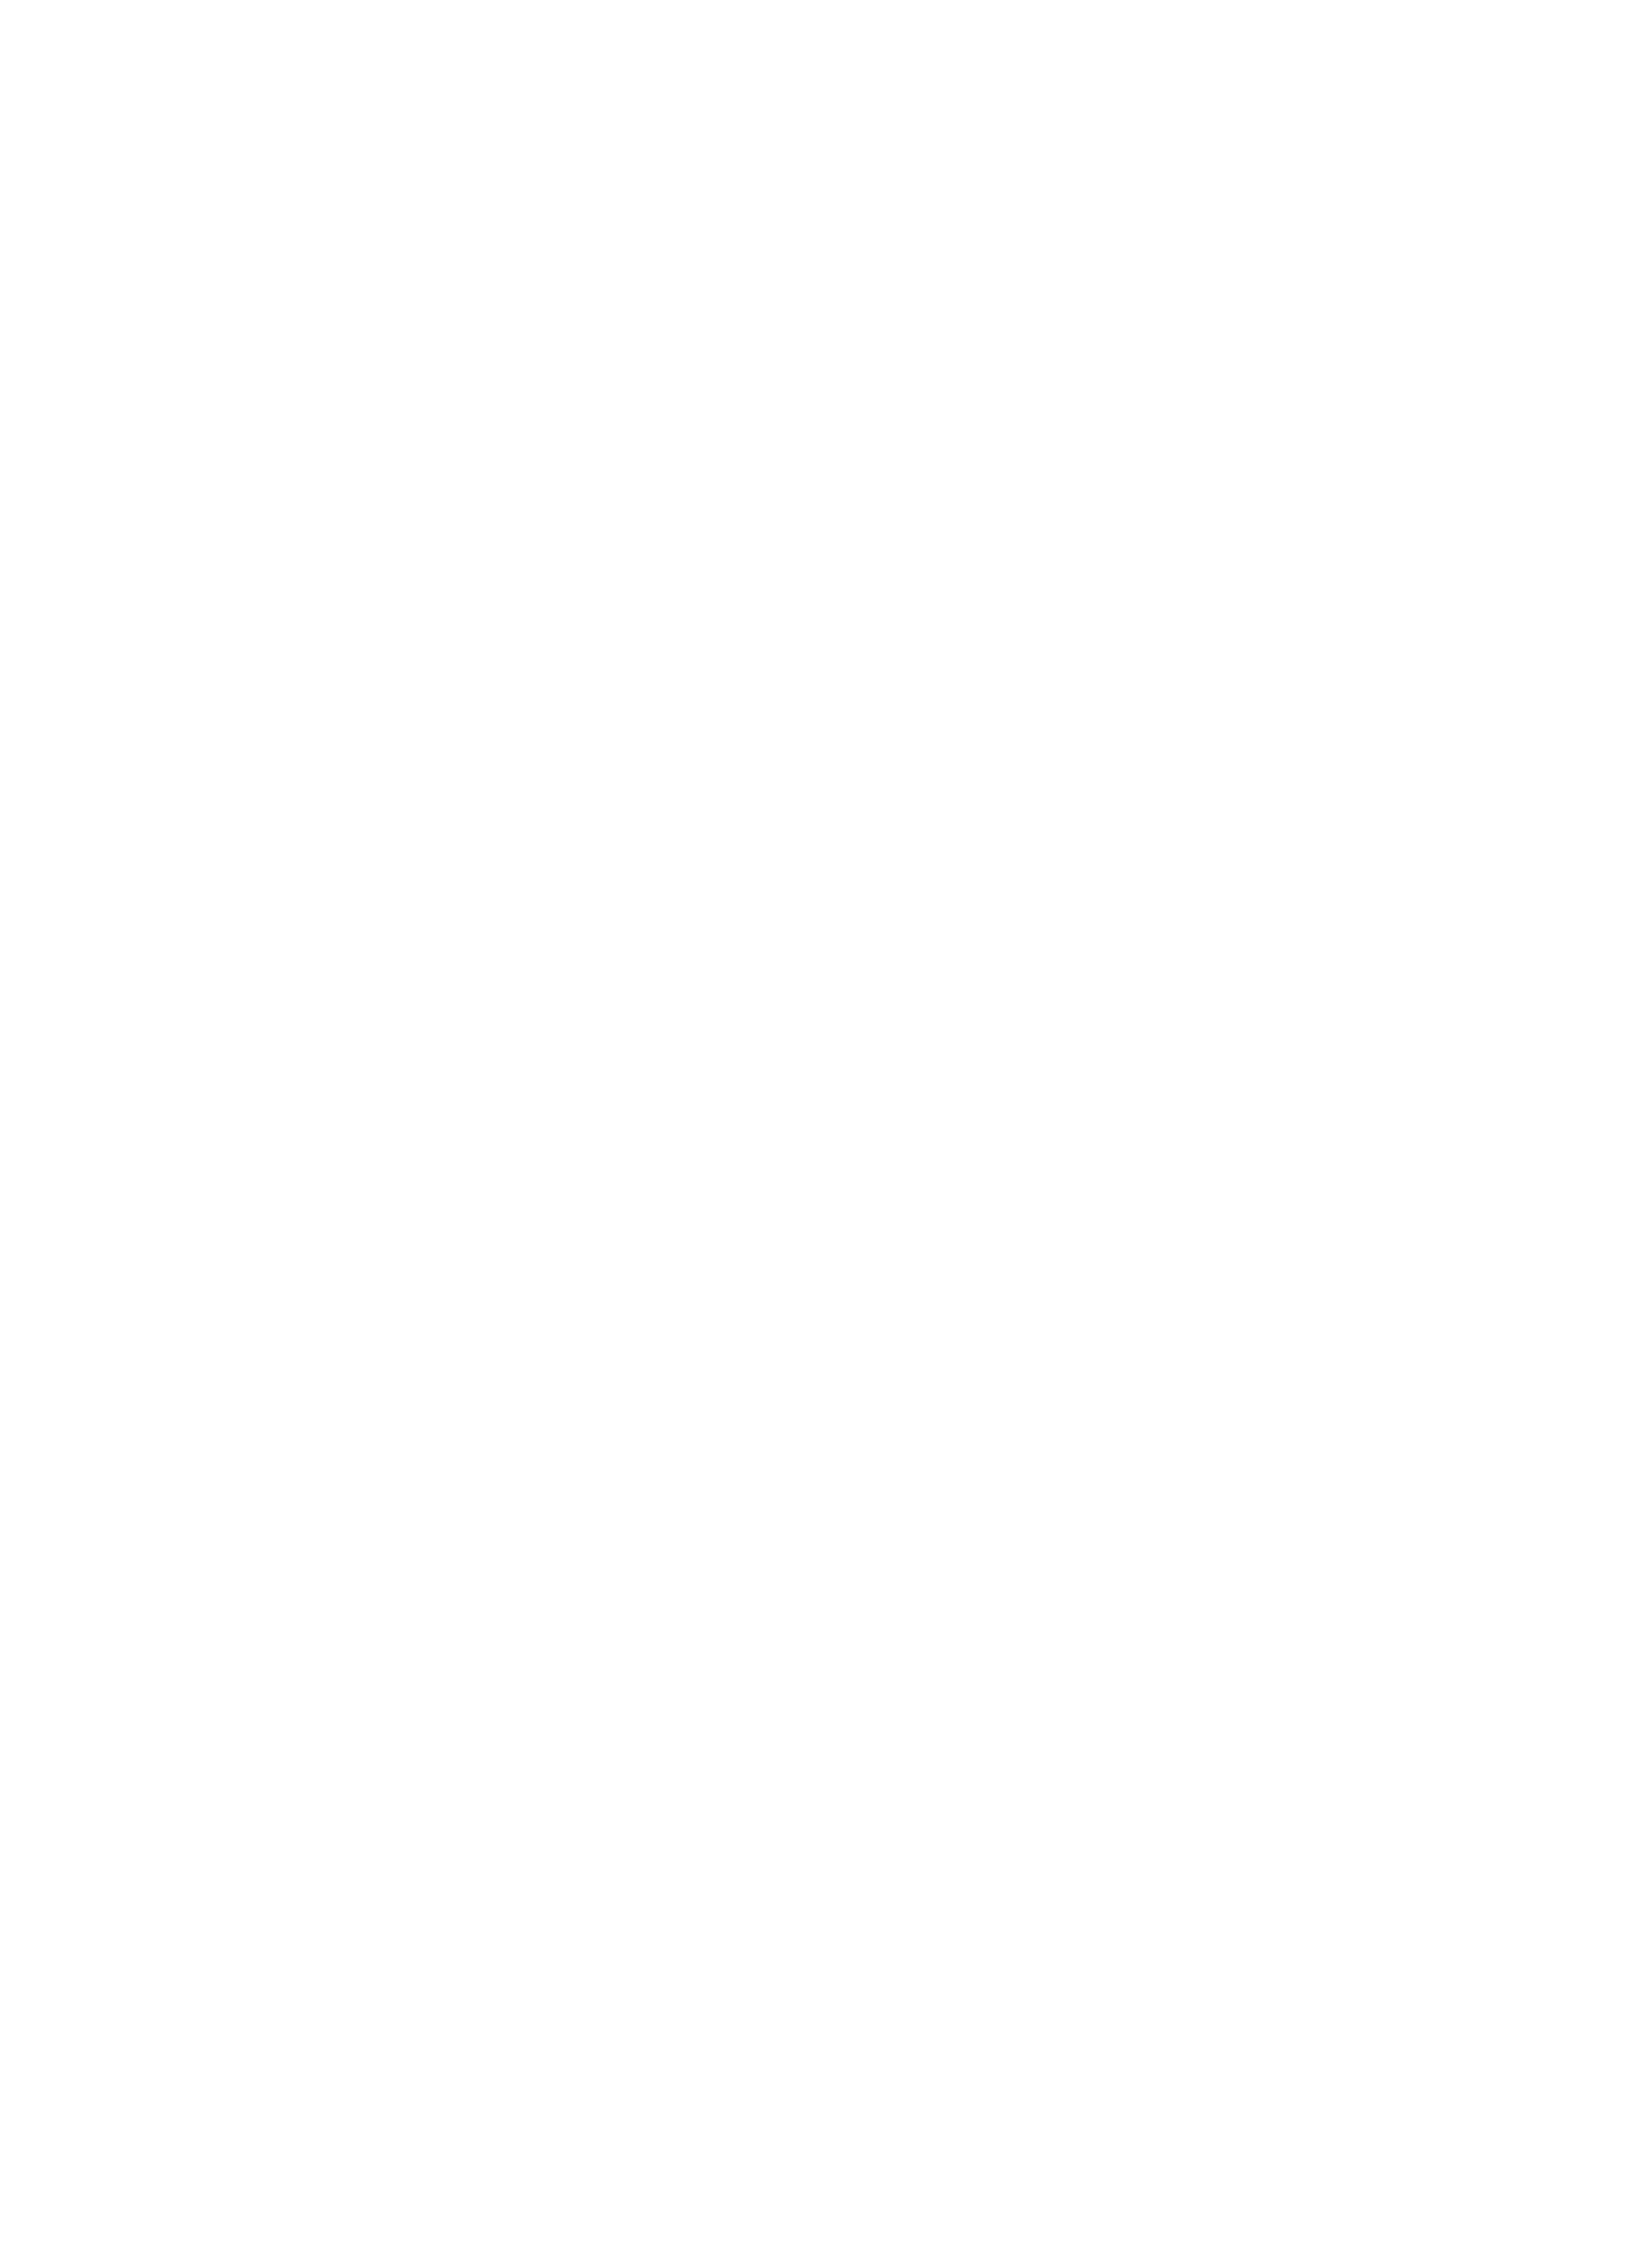

In [76]:
library(ggpubr)



options(repr.plot.width=16, repr.plot.height=22)
d$icrank <- factor(d$initial_coverage, ordered=TRUE)

ggscatter(
  d, x = "icrank", y = "per_trial_ranks_numeric",
  color = "fuzzer", shape="benchmark", add = "reg.line")
# + facet_wrap(benchmark ~ ., scales = "free", ncol=3)


Warning message:
“Removed 9 rows containing non-finite values (stat_bin).”


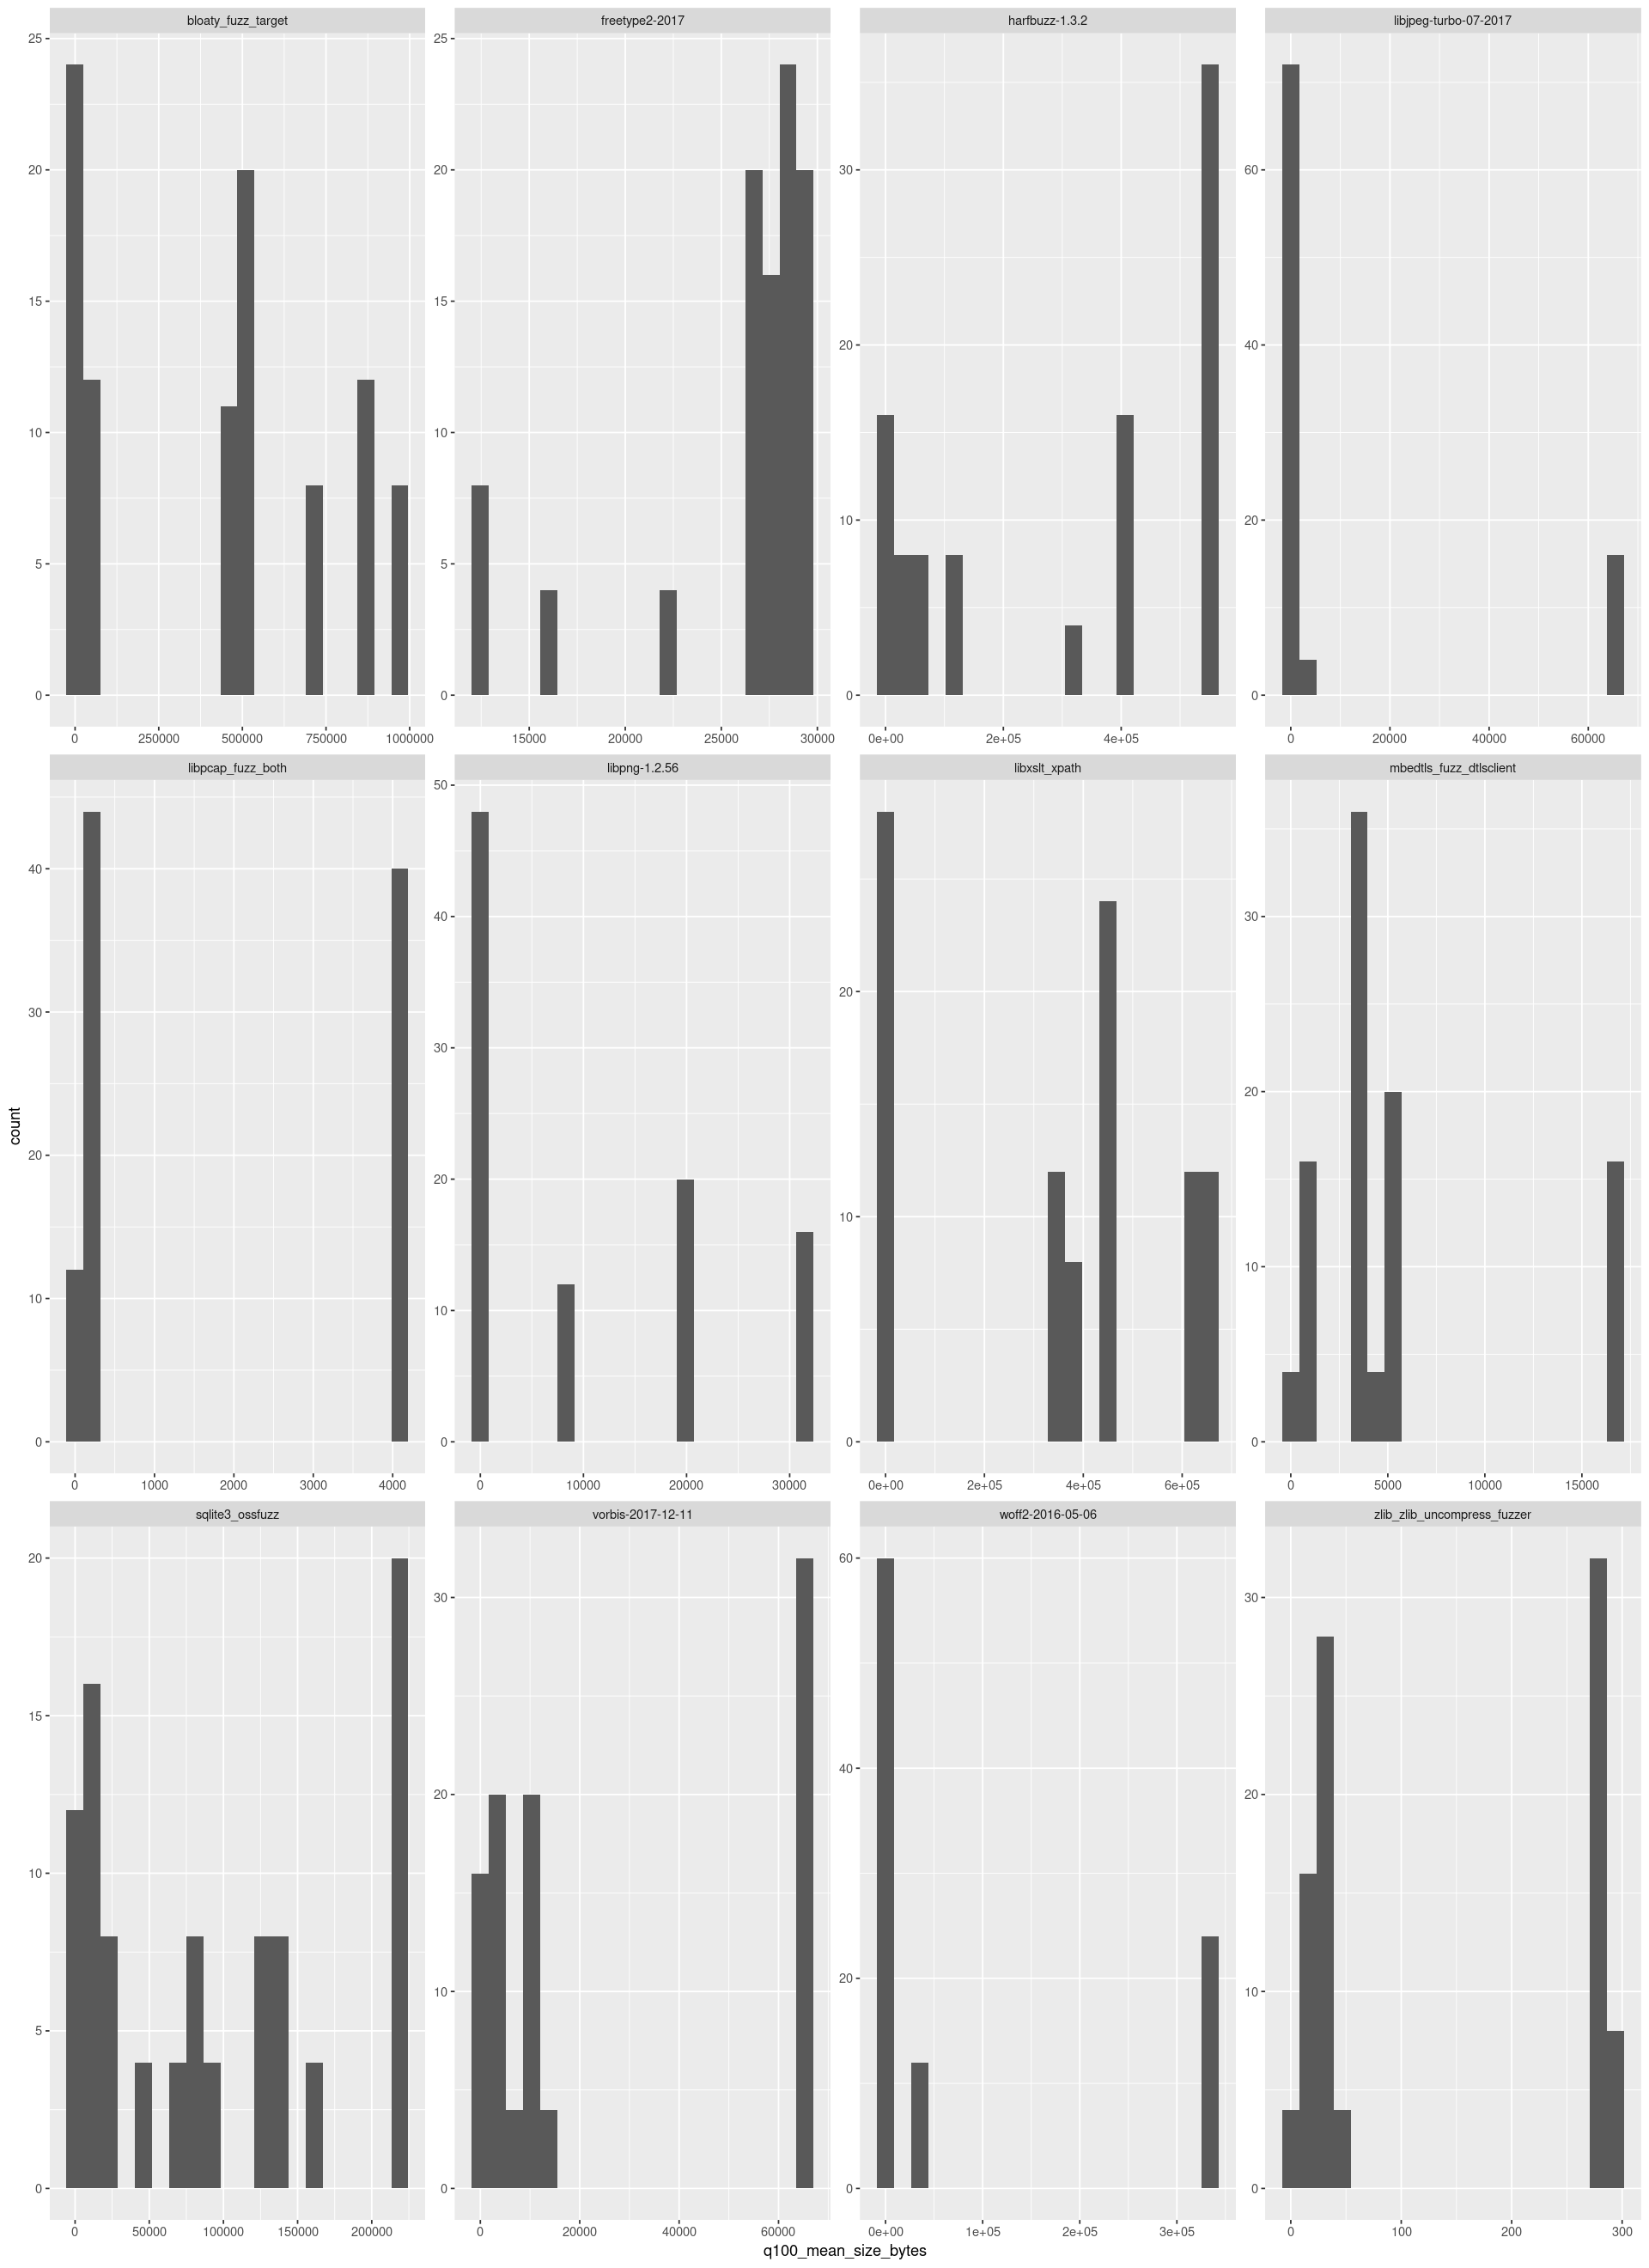

In [72]:
library("ggplot2")

ggp <- ggplot(d, aes(q100_mean_size_bytes)) + geom_histogram(bins=20)
ggp + facet_wrap(benchmark ~ ., scales="free") 

`geom_smooth()` using formula 'y ~ x'



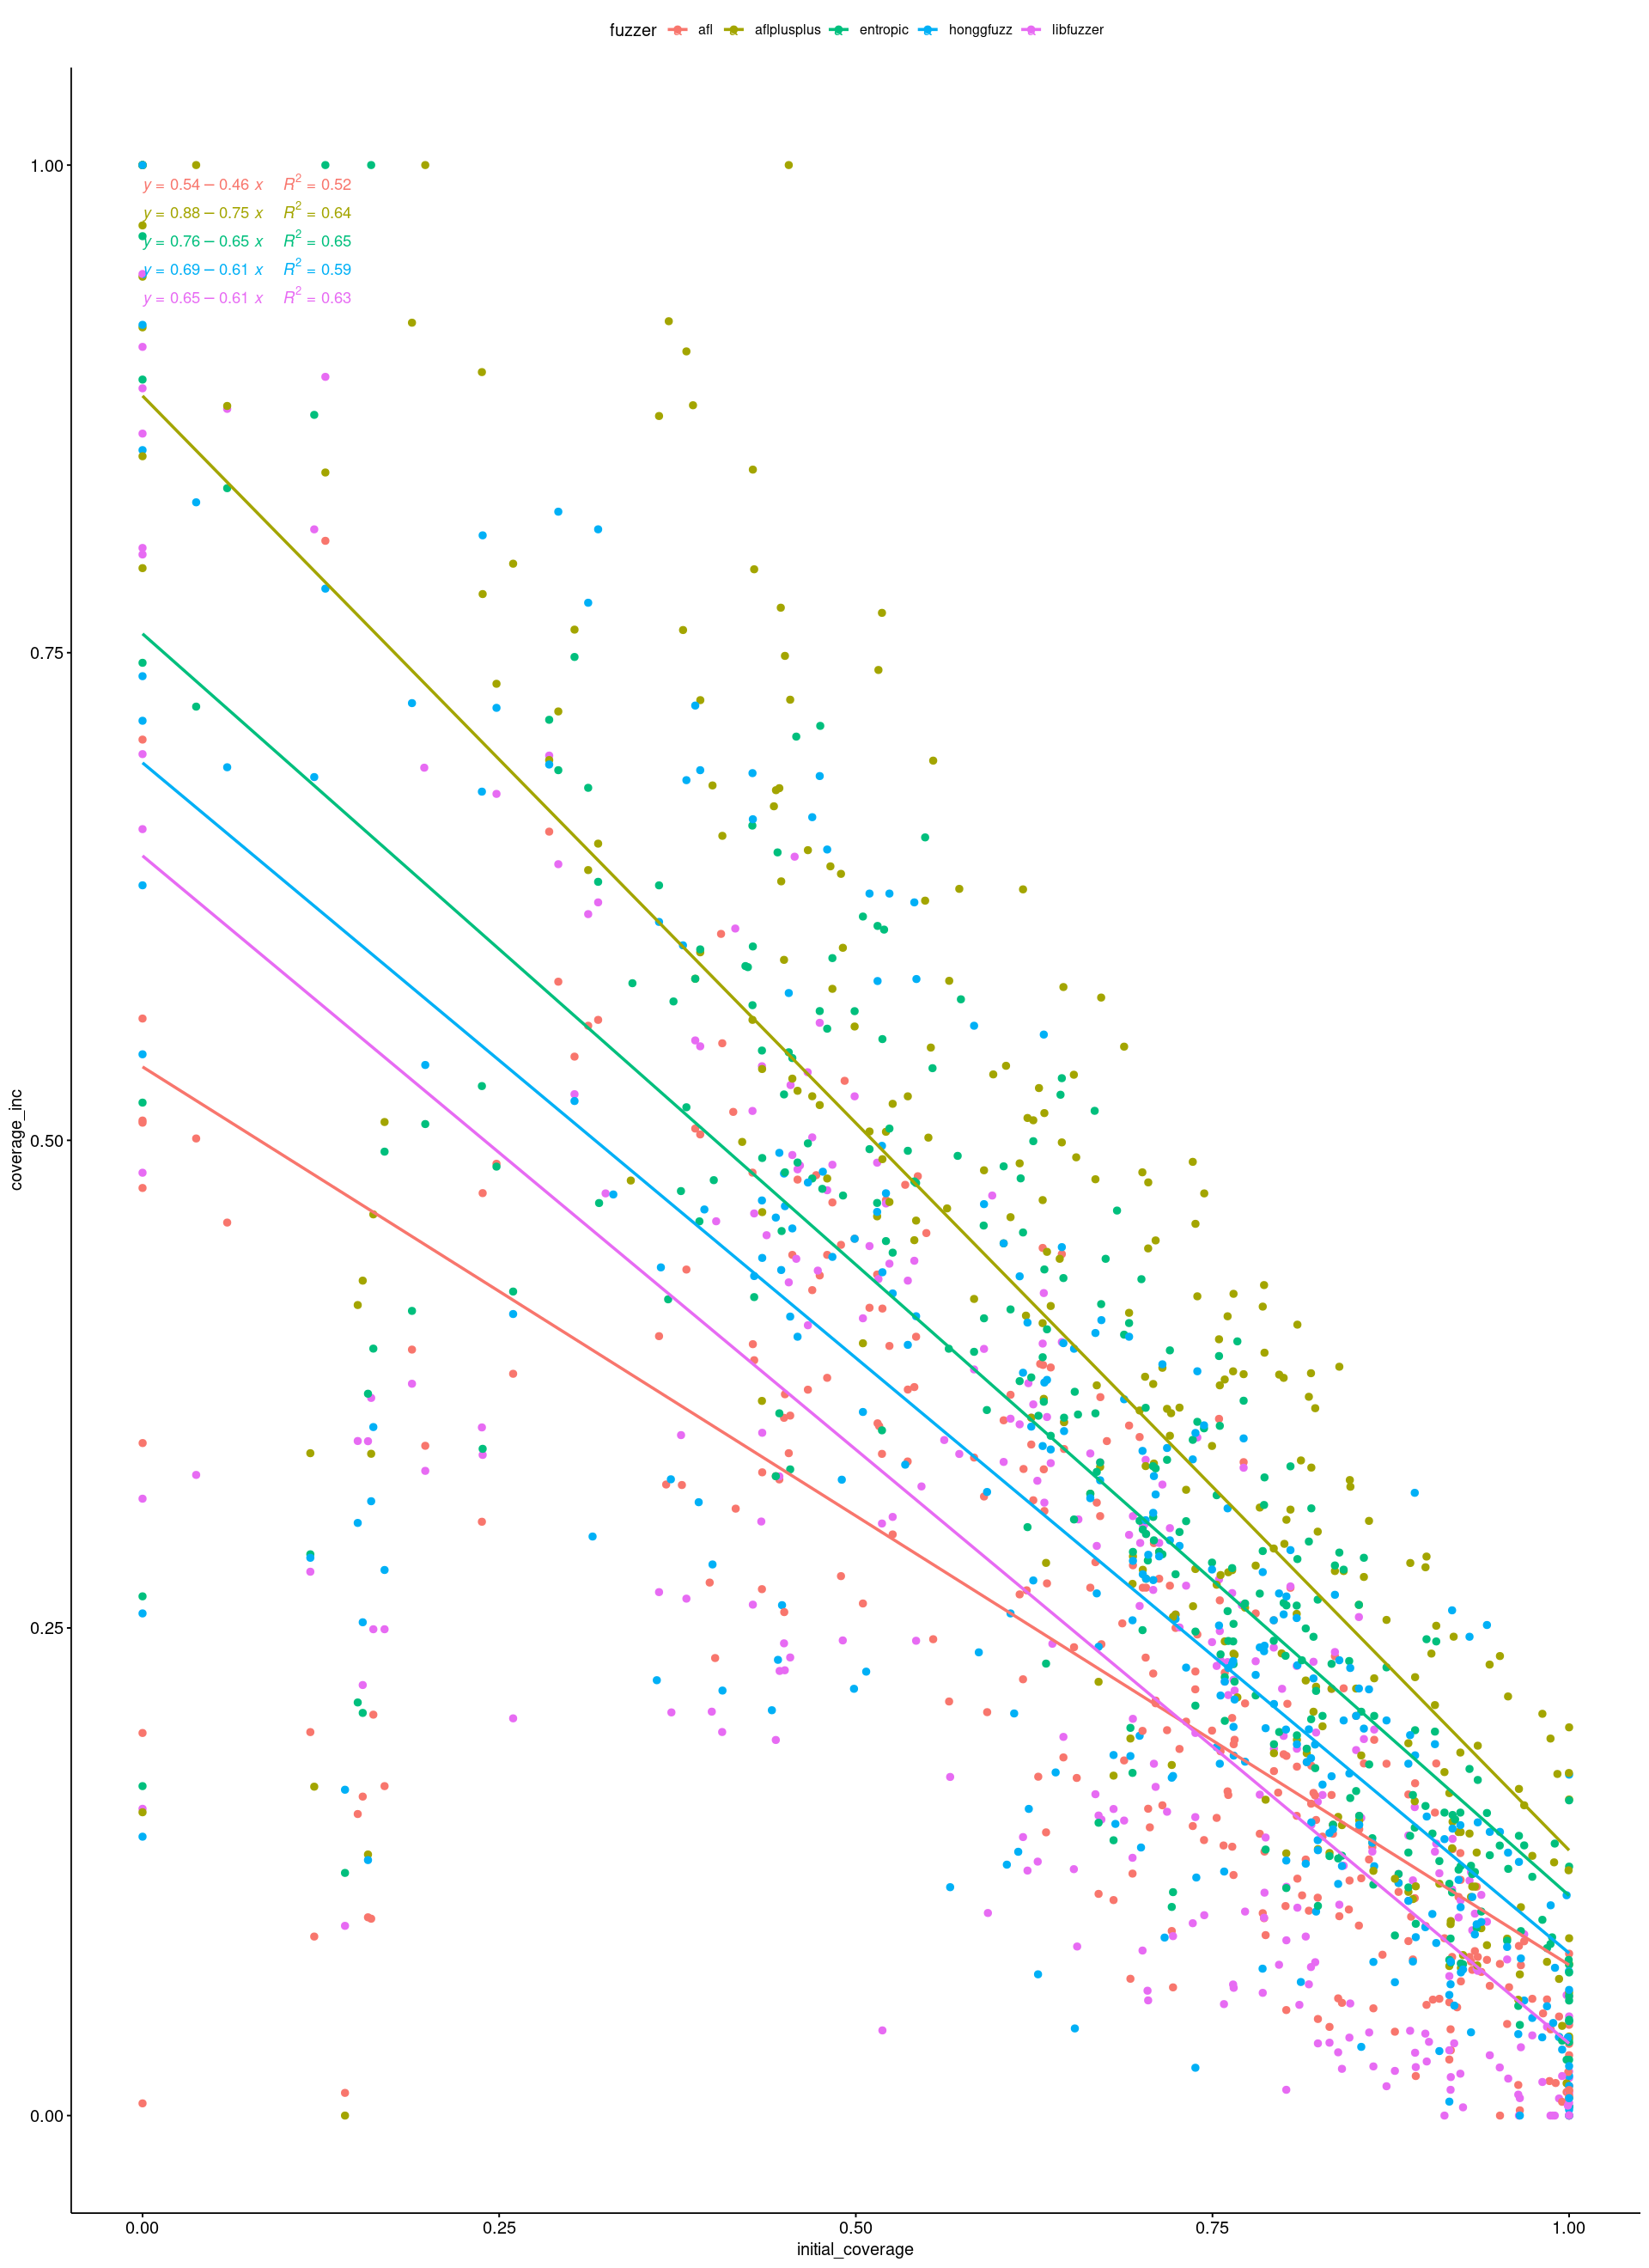

In [41]:
library(ggpubr)



options(repr.plot.width=16, repr.plot.height=22)

ggscatter(
  group_scaled_d, x = "initial_coverage", y = "coverage_inc",
  color = "fuzzer", add = "reg.line") + stat_regline_equation(
      aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = fuzzer)) # + facet_wrap(benchmark ~ ., scales="free")

`geom_smooth()` using formula 'y ~ x'



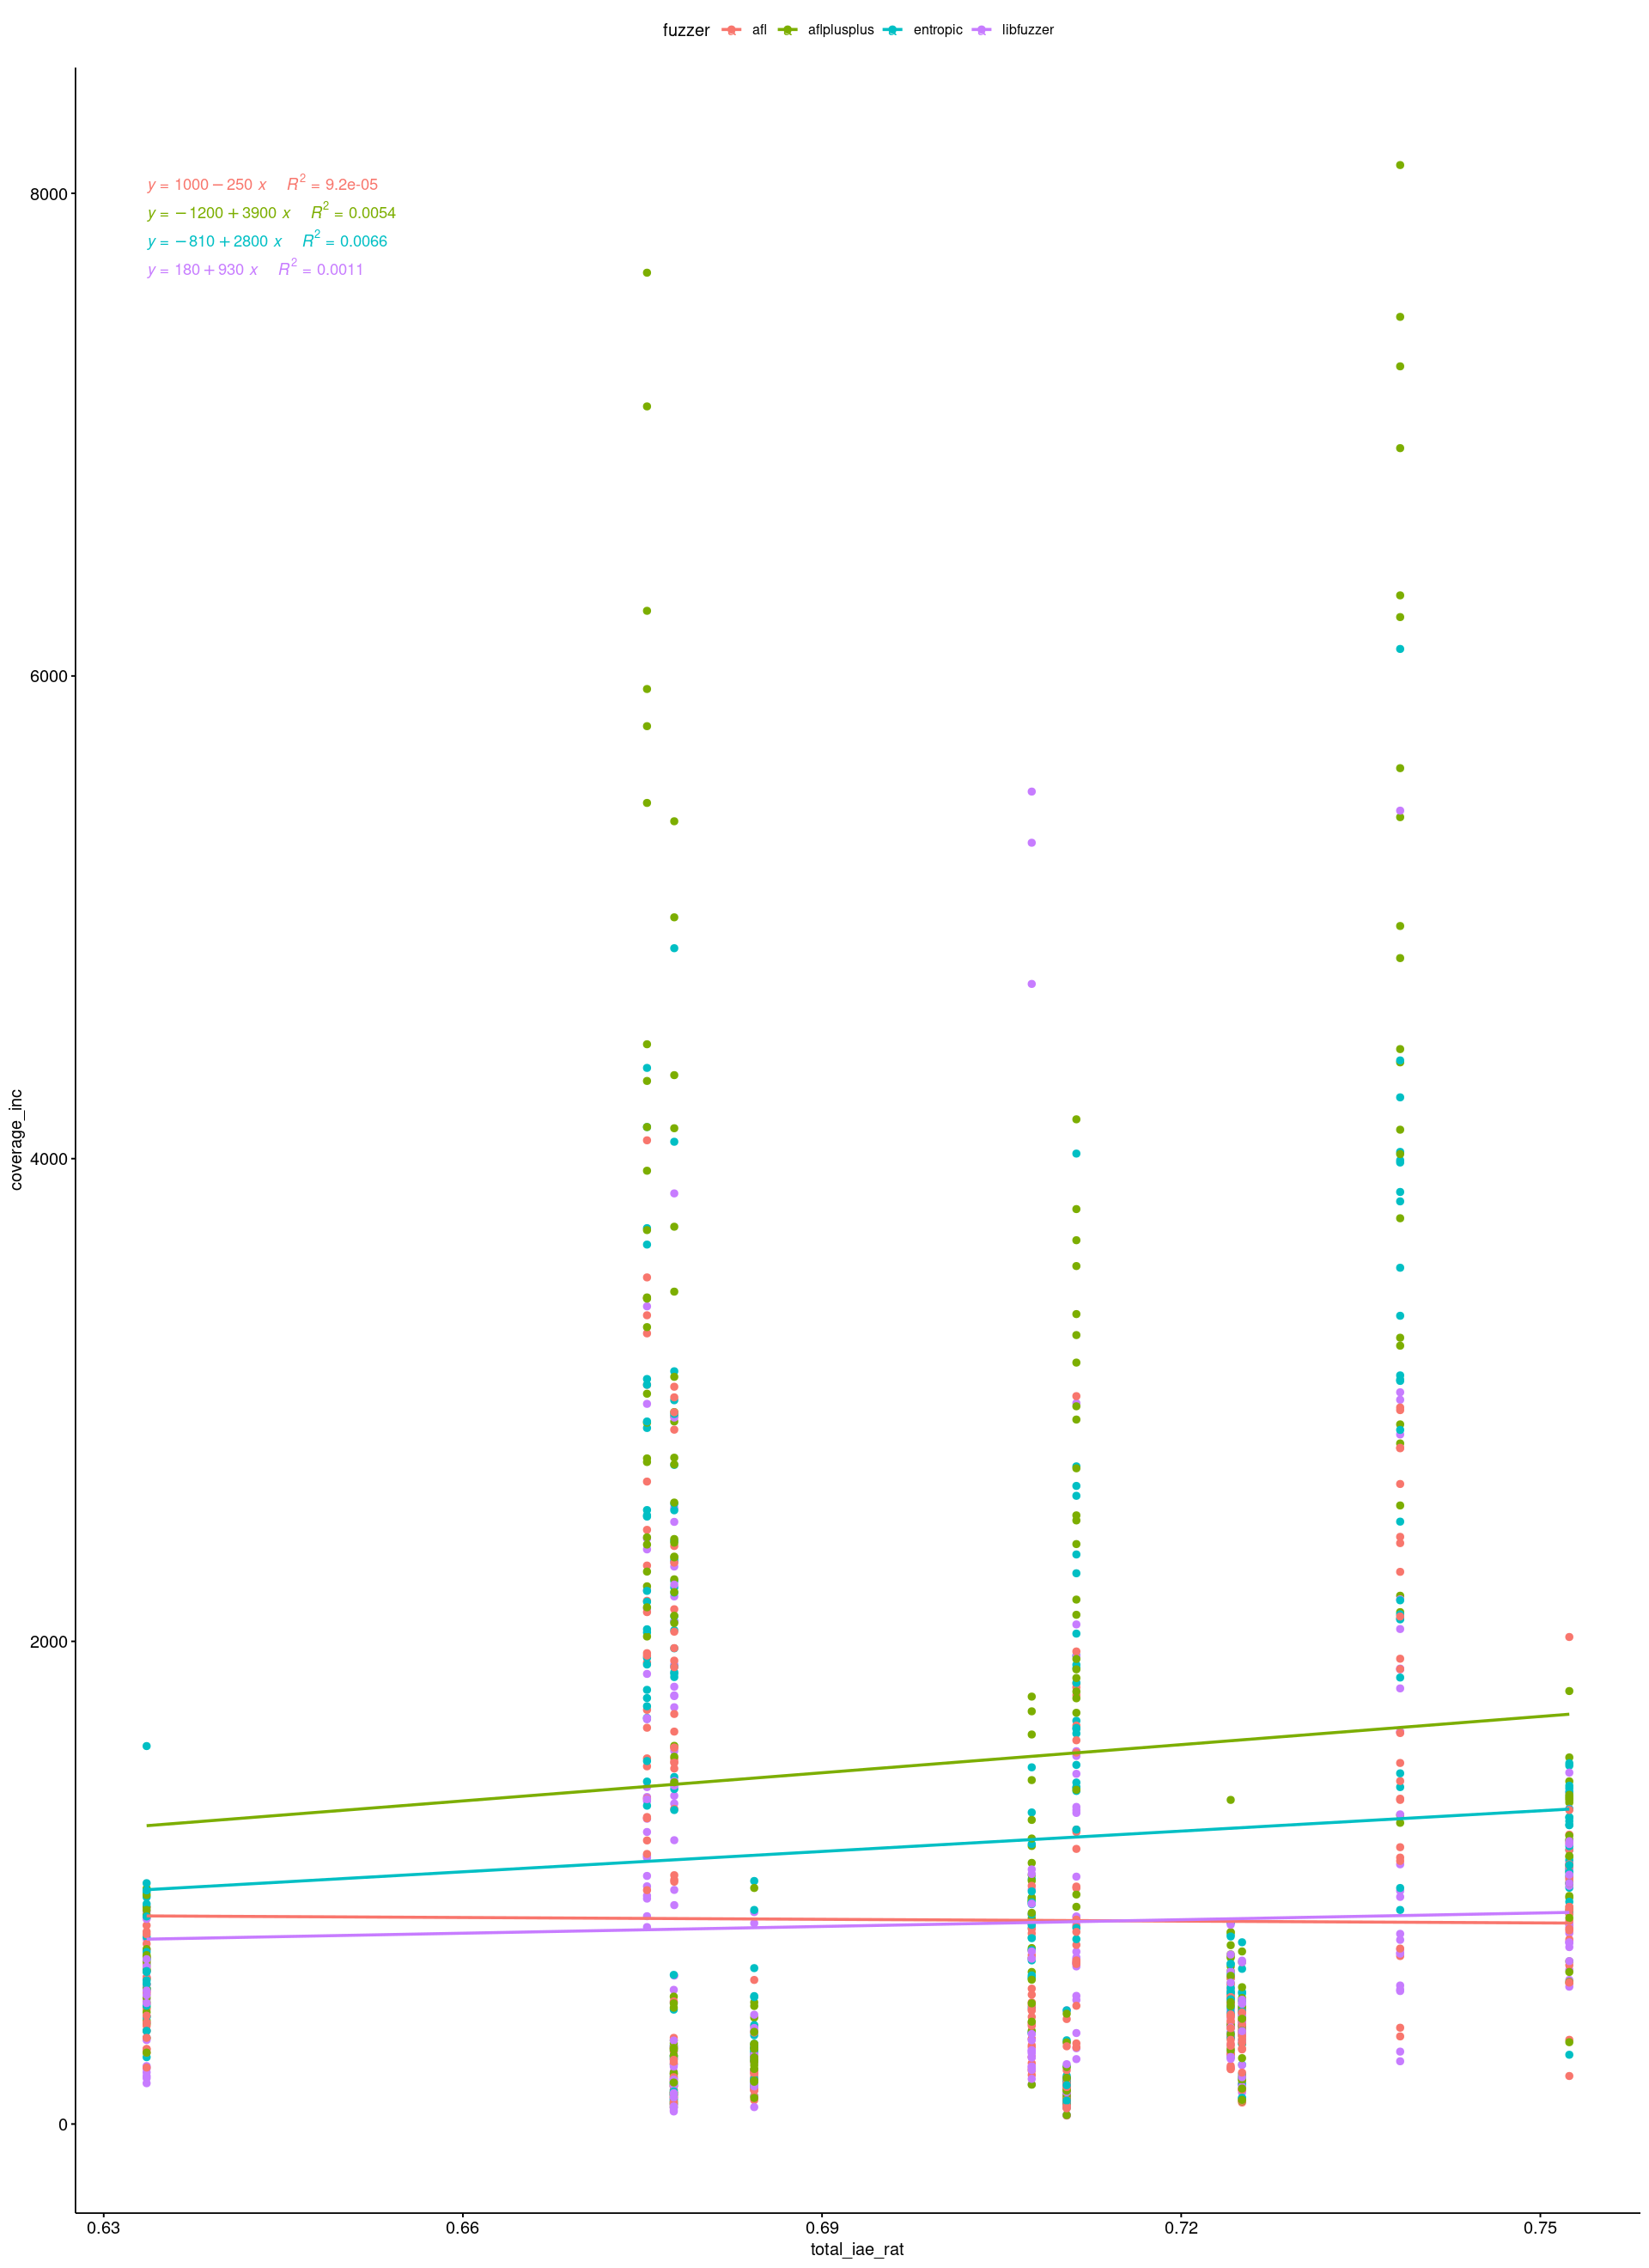

In [77]:
library(ggpubr)

d_statics$total_ie_rat <- d_statics$total_ineq / d_statics$total_eq
d_statics$approx_edges <-  (d_statics$total_eq + d_statics$total_ineq + d_statics$total_indir)
d_statics$total_iae_rat <- d_statics$total_eq / d_statics$approx_edges
d_statics$total_ib_rat <- d_statics$total_indir / d_statics$bin_text_size


ggscatter(
  d_statics, x = "total_iae_rat", y = "coverage_inc",
  color = "fuzzer", add = "reg.line") + stat_regline_equation(
      aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = fuzzer)) 

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning

Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containin

Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute e

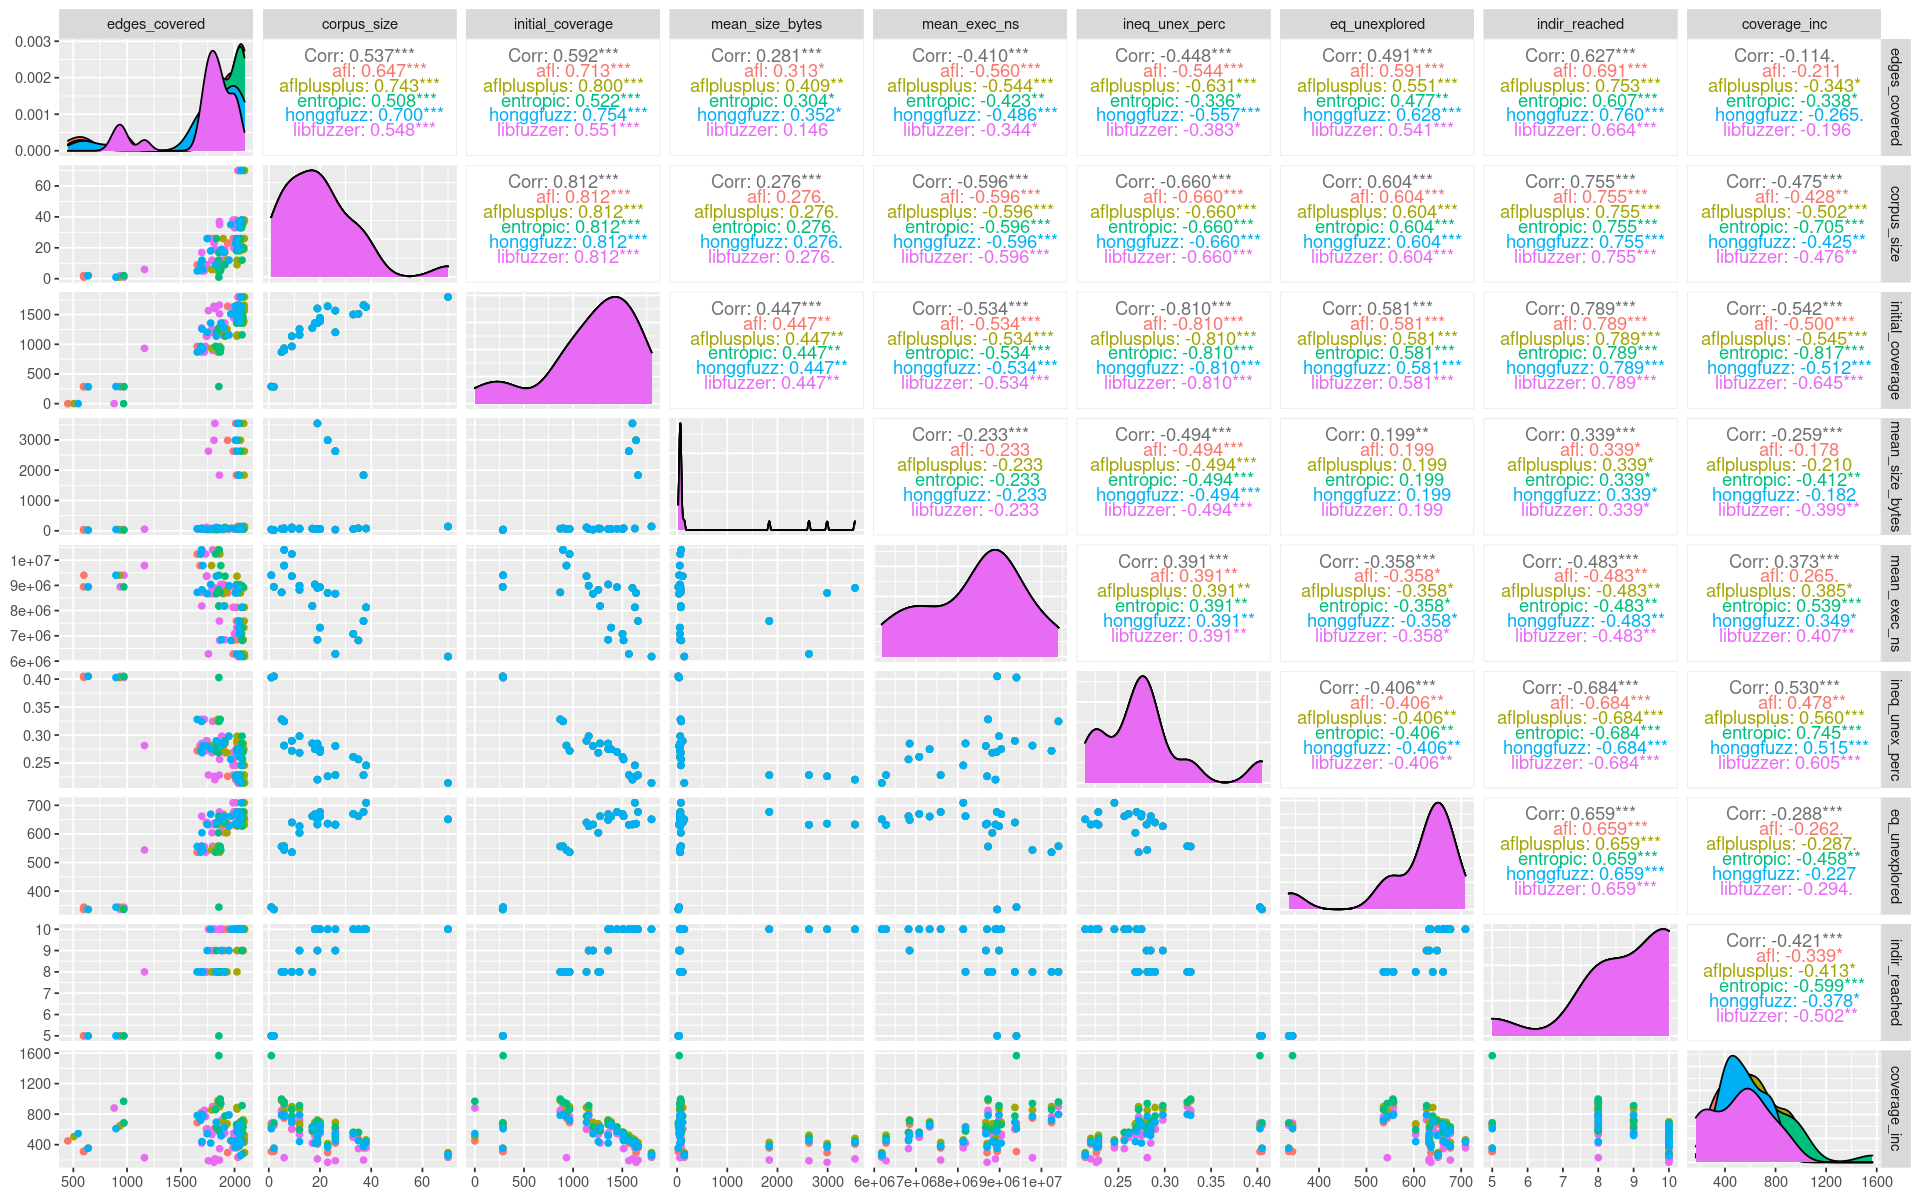

In [22]:
# install.packages("GGally")

library(GGally)
library(repr)

options(repr.plot.width=16, repr.plot.height=10)
vars = c("edges_covered", "corpus_size", "initial_coverage", "mean_size_bytes", "mean_exec_ns", "ineq_unex_perc", "eq_unexplored", "indir_reached", "coverage_inc" )

# display a pairplot of all four columns of data
GGally::ggpairs(d %>% filter(benchmark == "libjpeg-turbo-07-2017"), columns = vars, ggplot2::aes(color = fuzzer), upper = list(continuous = wrap("cor", method = "kendall")))

In [ ]:
# install.packages("tidyverse")
# install.packages("ggpubr")
# install.packages("rstatix")
# install.packages("broom")
library(tidyverse)
library(rstatix)
library(broom)

In [ ]:
library(ggpubr)
# Assumption 1 (ANCOVA): Visually check for  linear relationship between covariate and output 
ggscatter(
  d[d$benchmark == "bloaty_fuzz_target",], x = "ineq_unexplored", y = "coverage_inc",
  color = "fuzzer", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = fuzzer)
    )


In [ ]:
sample_fb <- read.csv("sample-report.csv")
require(dplyr)
max <- sample_fb %>% group_by(trial_id) %>% summarise(edges_covered = max(edges_covered))
max <- unique(left_join(max, sample_fb[c("trial_id", "benchmark", "fuzzer")], by = c("trial_id")))

norm_tests <- aggregate(formula = edges_covered ~ benchmark + fuzzer,
          data = max,
          FUN = function(x) { tryCatch({
              y <- shapiro.test(x); c(y$statistic, y$p.value)
            }, error = function(e) {
               c(0,0)
            }
          )})
norm_tests

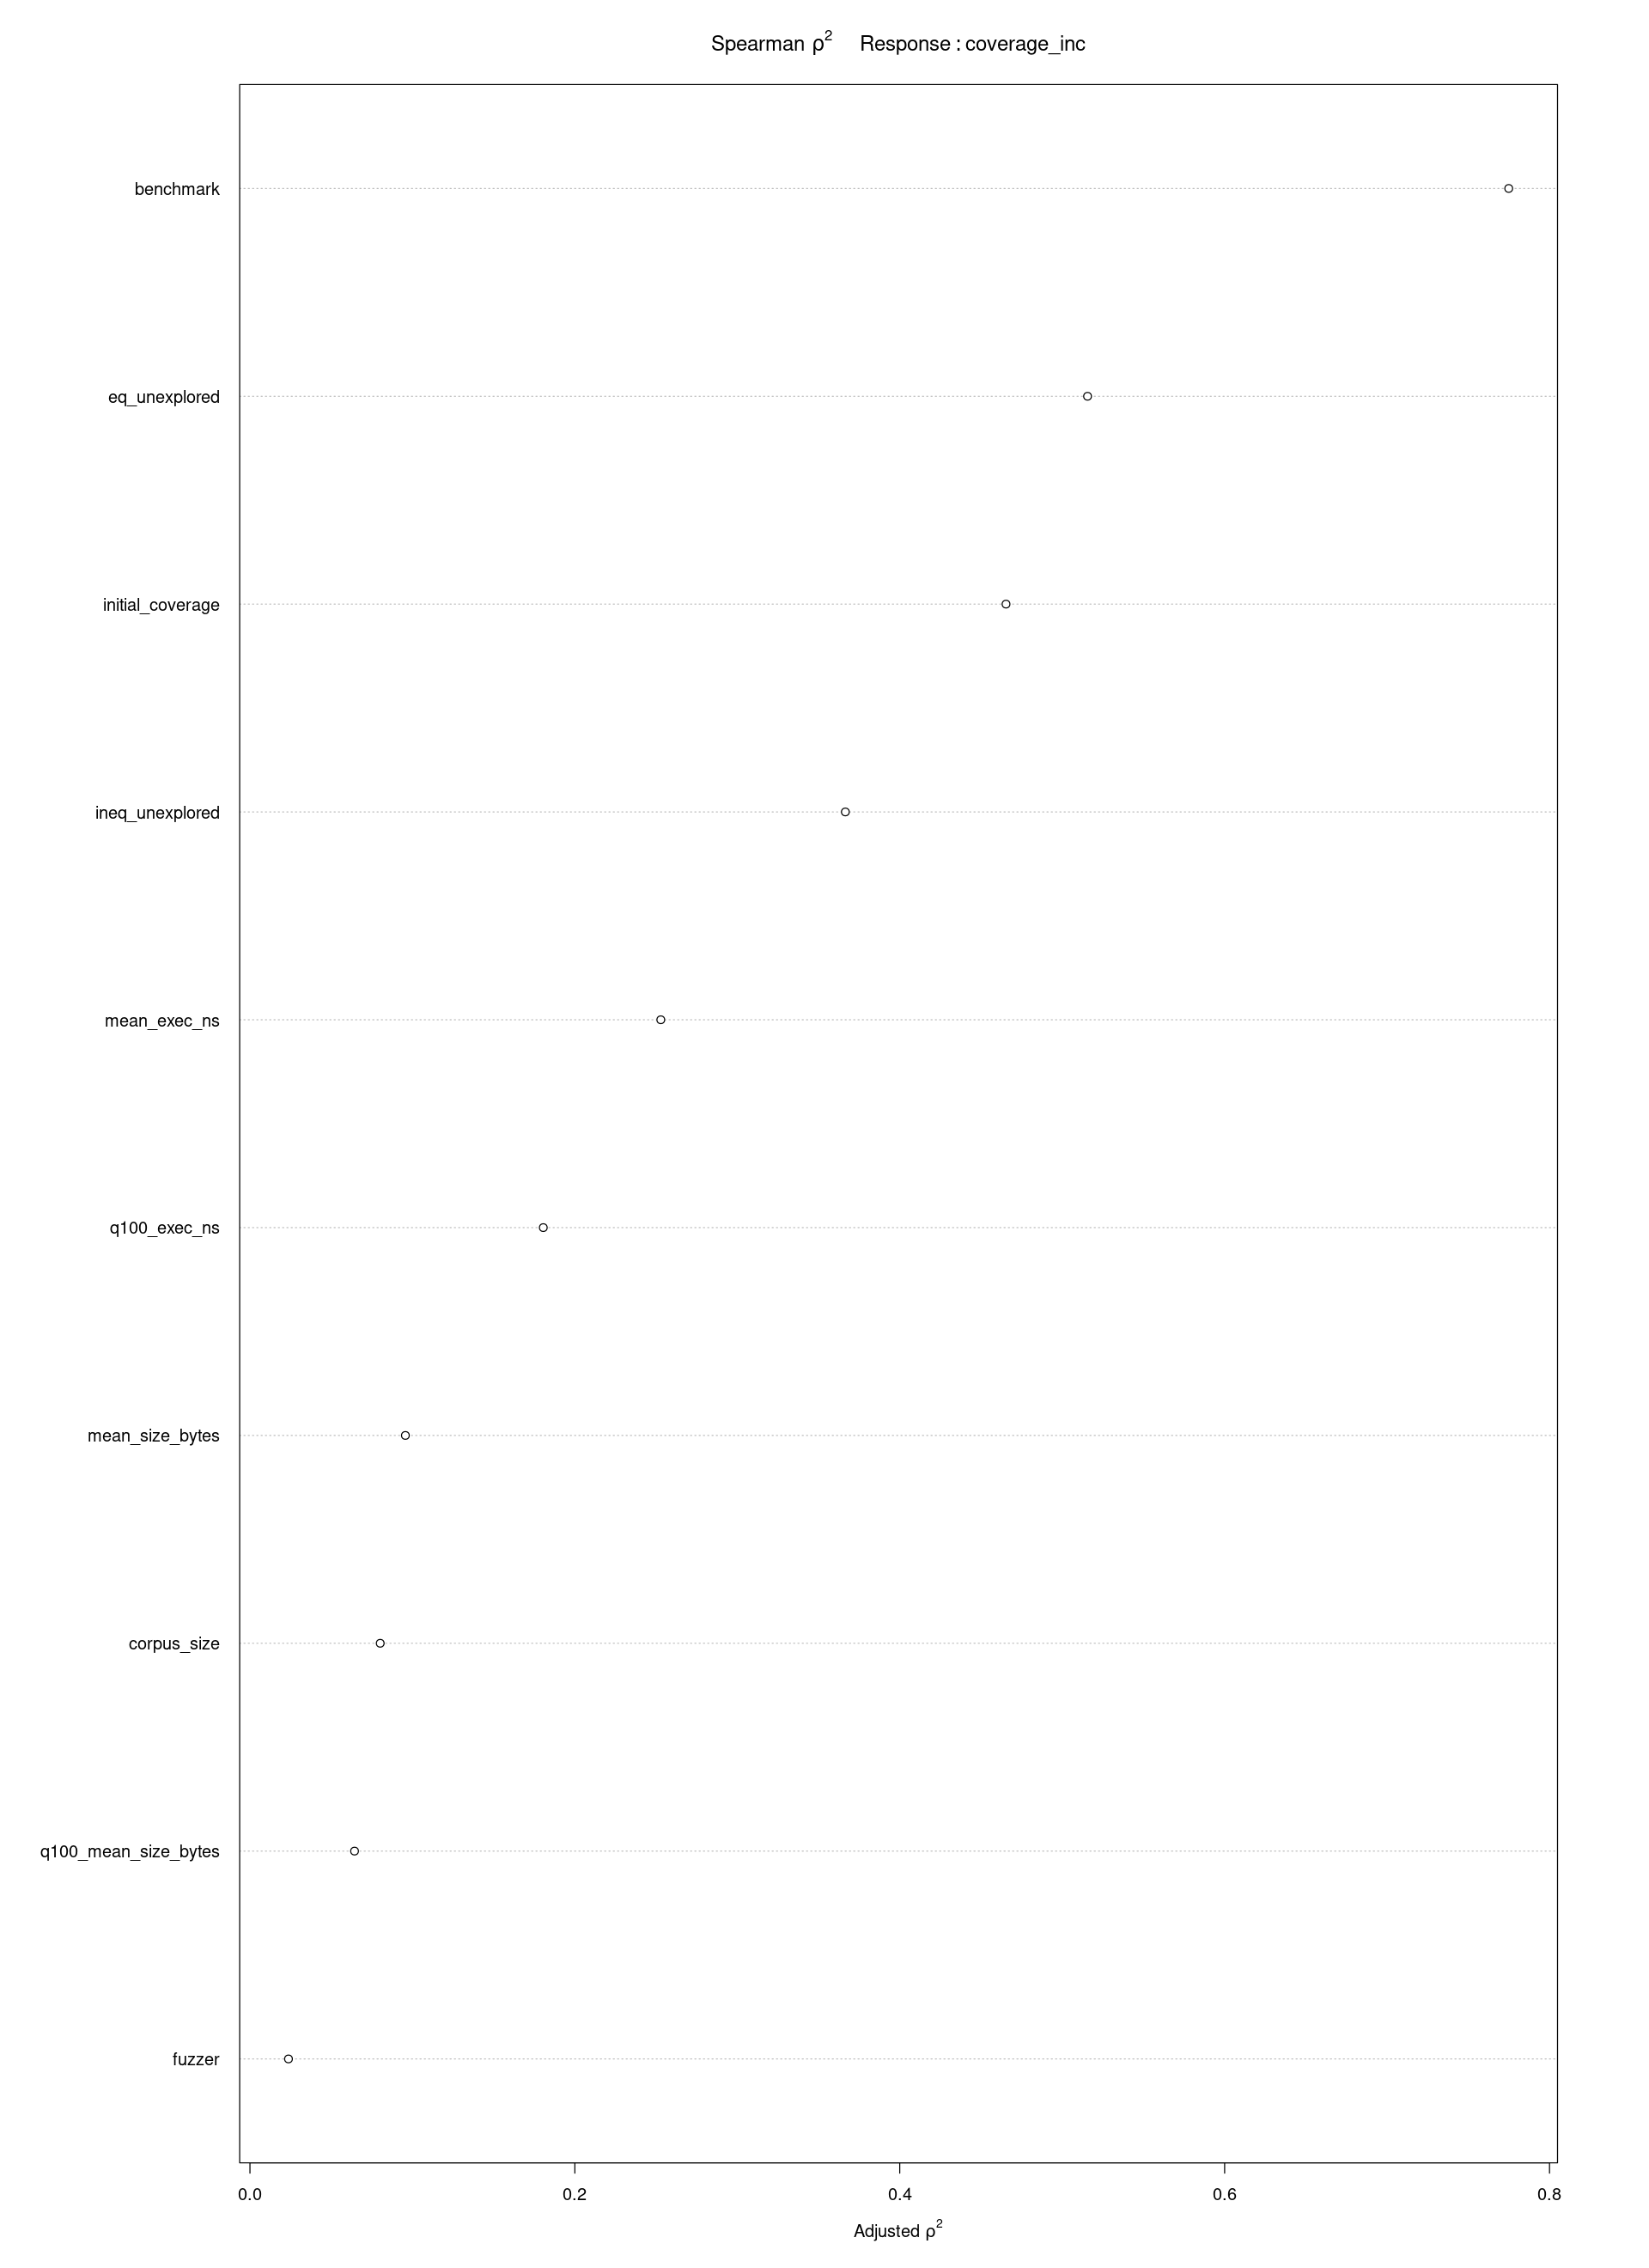

In [78]:
library("rms")

rms_d <- d

s <- spearman2(coverage_inc ~ corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + fuzzer + benchmark + q100_exec_ns + q100_mean_size_bytes, data=rms_d)
plot(s)

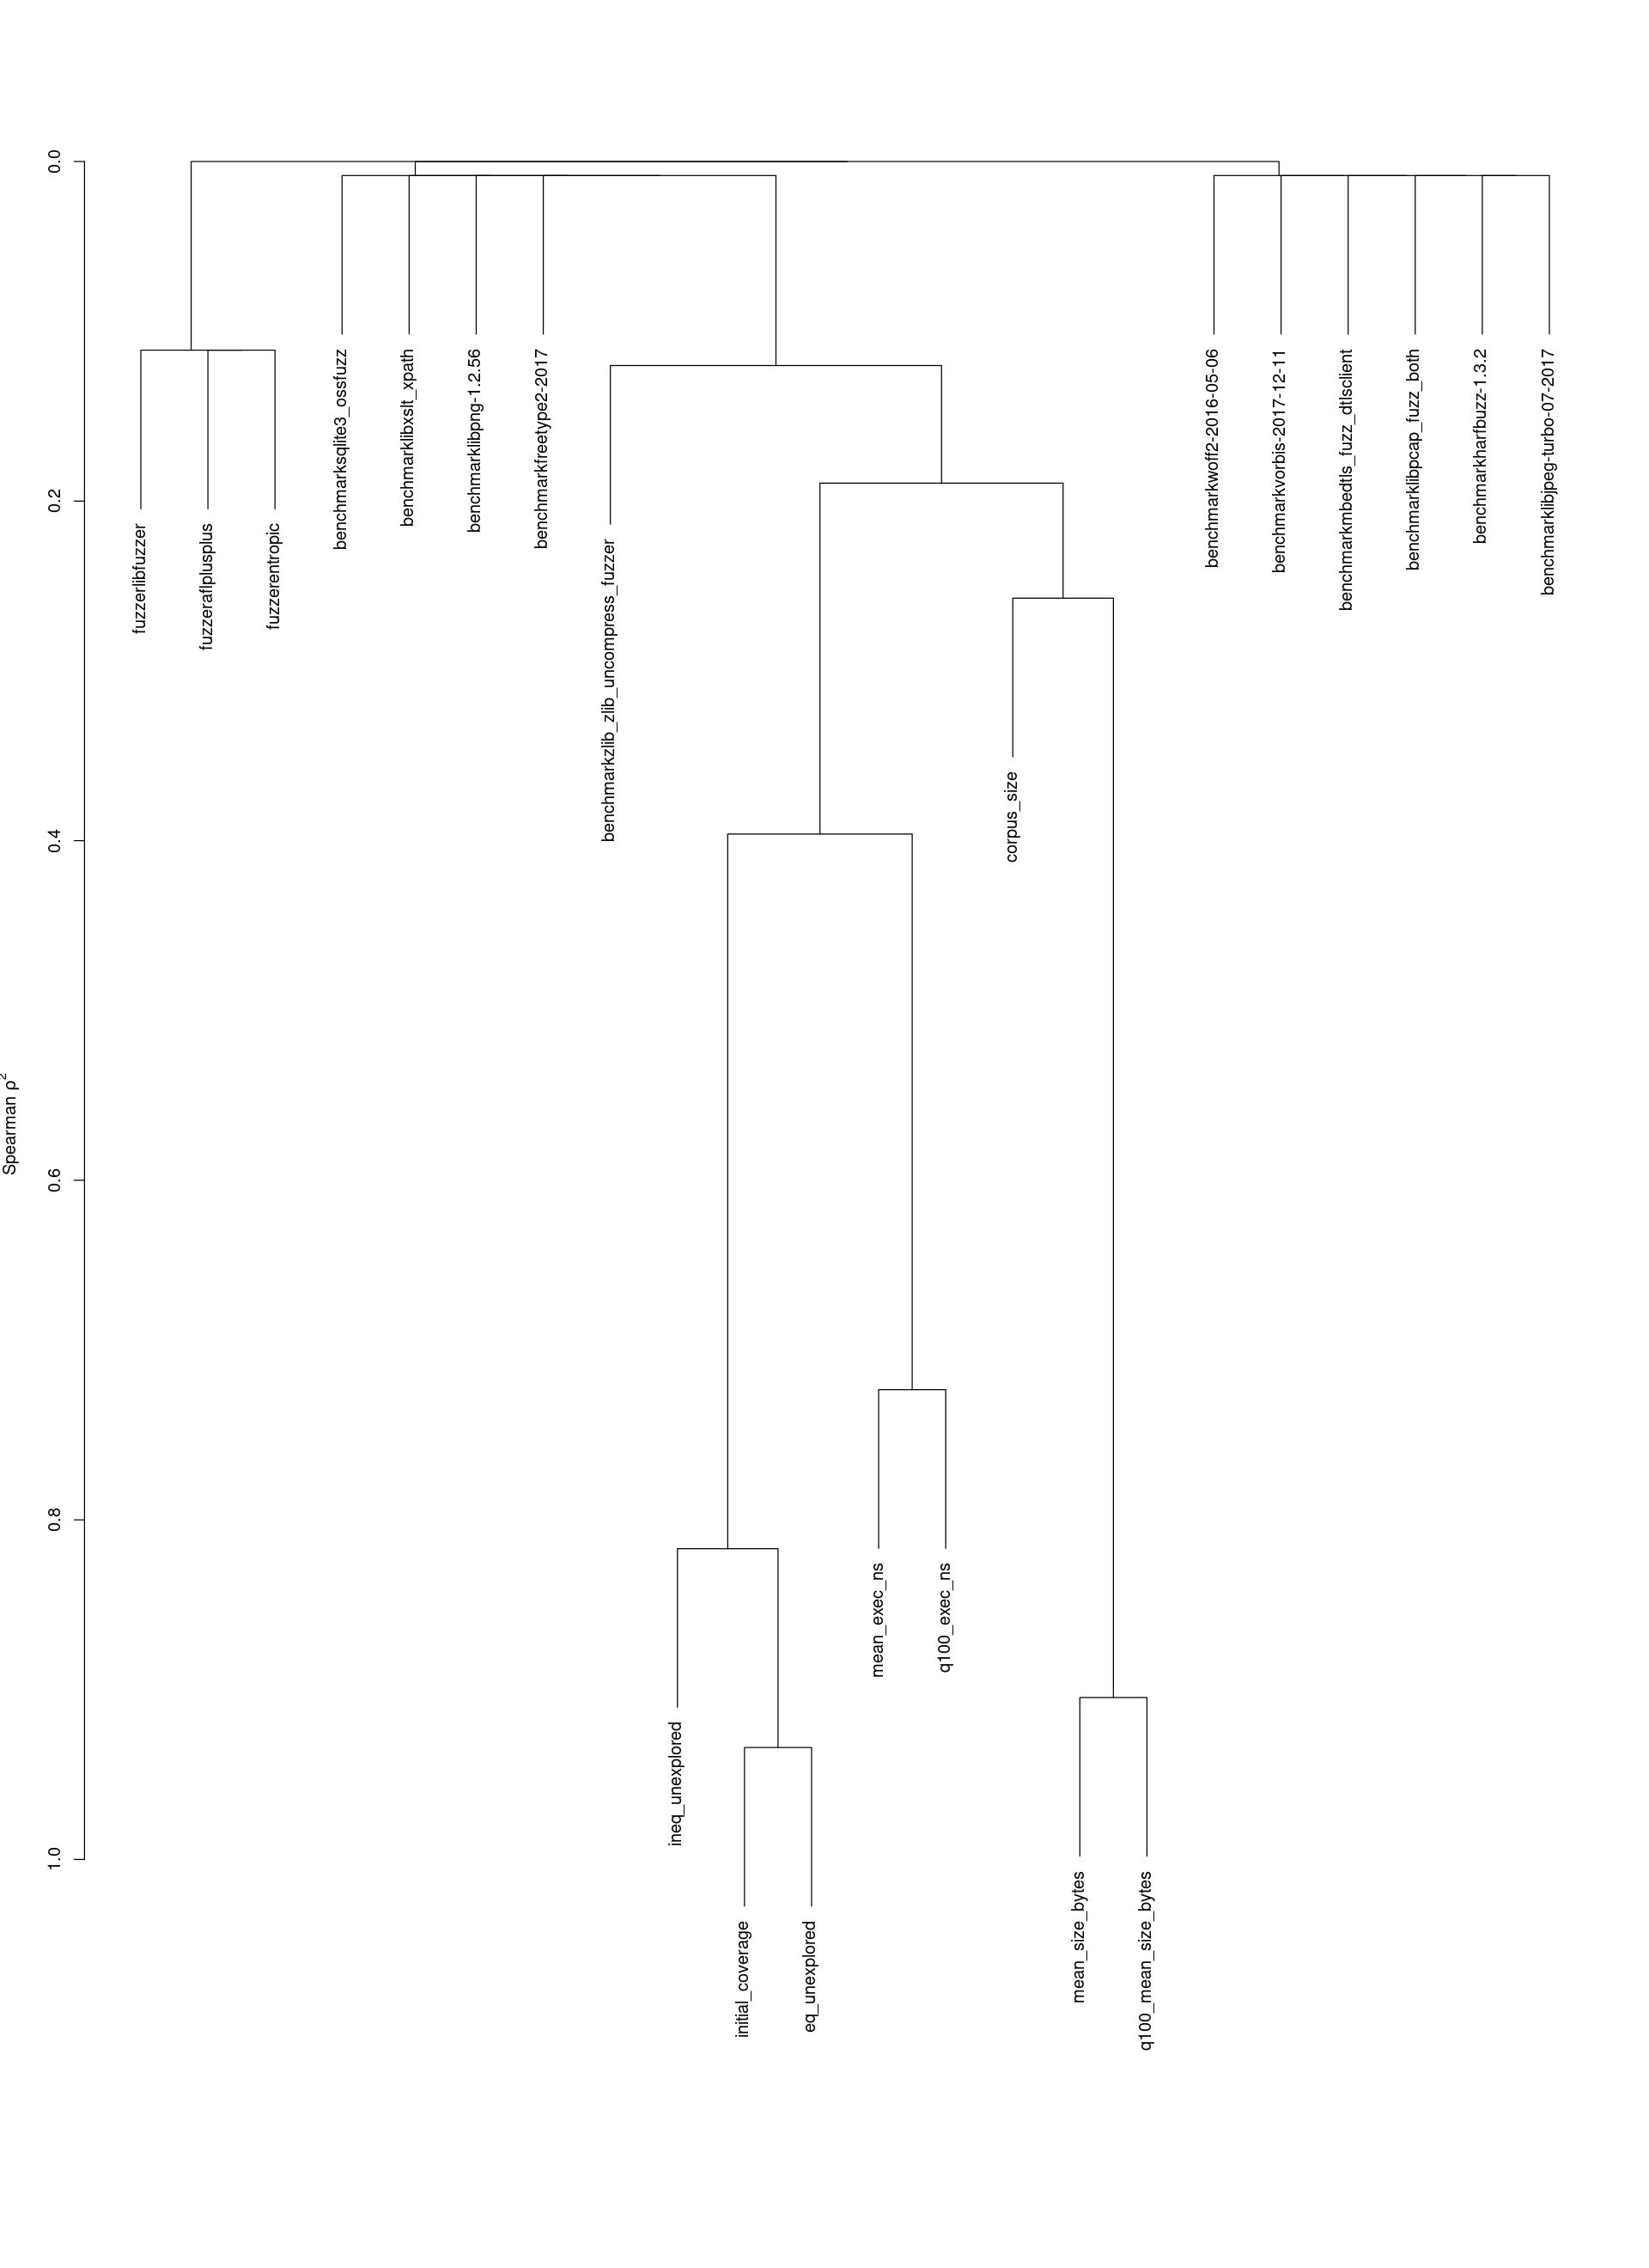

In [79]:
require(rms)
v <- varclus(coverage_inc ~ corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + fuzzer + benchmark + q100_exec_ns + q100_mean_size_bytes, data=d)
plot(v)

In [ ]:
require("rms")

model <- orm(formula = coverage_inc ~ benchmark + fuzzer + initial_coverage, data = d)
model
AIC(model)

In [80]:
require(dplyr)
require(purrr)
require(plyr)



corellation <- function(y, x) {
    t <- cor.test(y, x, method = "spearman")
  
    if (is.finite(t$p.value)) {

        t$estimate
    } else {
        rv <- NA
        names(rv)[0] <- "rho"
        rv
    }
}

acc_coefs <- function(f, notused) { 
    g <- f %>% group_by(benchmark) %>%
        group_map(
            ~ c(corellation(.x$q100_exec_ns, .x$coverage_inc), .x$benchmark[1]),
            .keep = TRUE
        ) %>% bind_rows()

    g
}

res <- d %>% group_by(fuzzer) %>%
        group_map(
            ~ acc_coefs(.x, 0) %>% add_column(fuzz = .x$fuzzer[1]),
            .keep = TRUE
        ) %>% bind_rows() 

names(res)[2] <- 'bench'
res$rho <- as.numeric(res$rho)
res



Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:Hmisc’:

    is.discrete, summarize


The following objects are masked from ‘package:reshape’:

    rename, round_any


The following object is masked from ‘package:purrr’:

    compact


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method

rho,bench,fuzz
<dbl>,<chr>,<chr>
-0.5760870,bloaty_fuzz_target,afl
-0.4773913,freetype2-2017,afl
-0.4373913,harfbuzz-1.3.2,afl
-0.3606719,libjpeg-turbo-07-2017,afl
-0.2060870,libpcap_fuzz_both,afl
-0.5772075,libpng-1.2.56,afl
-0.5452174,libxslt_xpath,afl
-0.2366246,mbedtls_fuzz_dtlsclient,afl
-0.8078261,sqlite3_ossfuzz,afl


Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 24 rows containing missing values (geom_bar).”


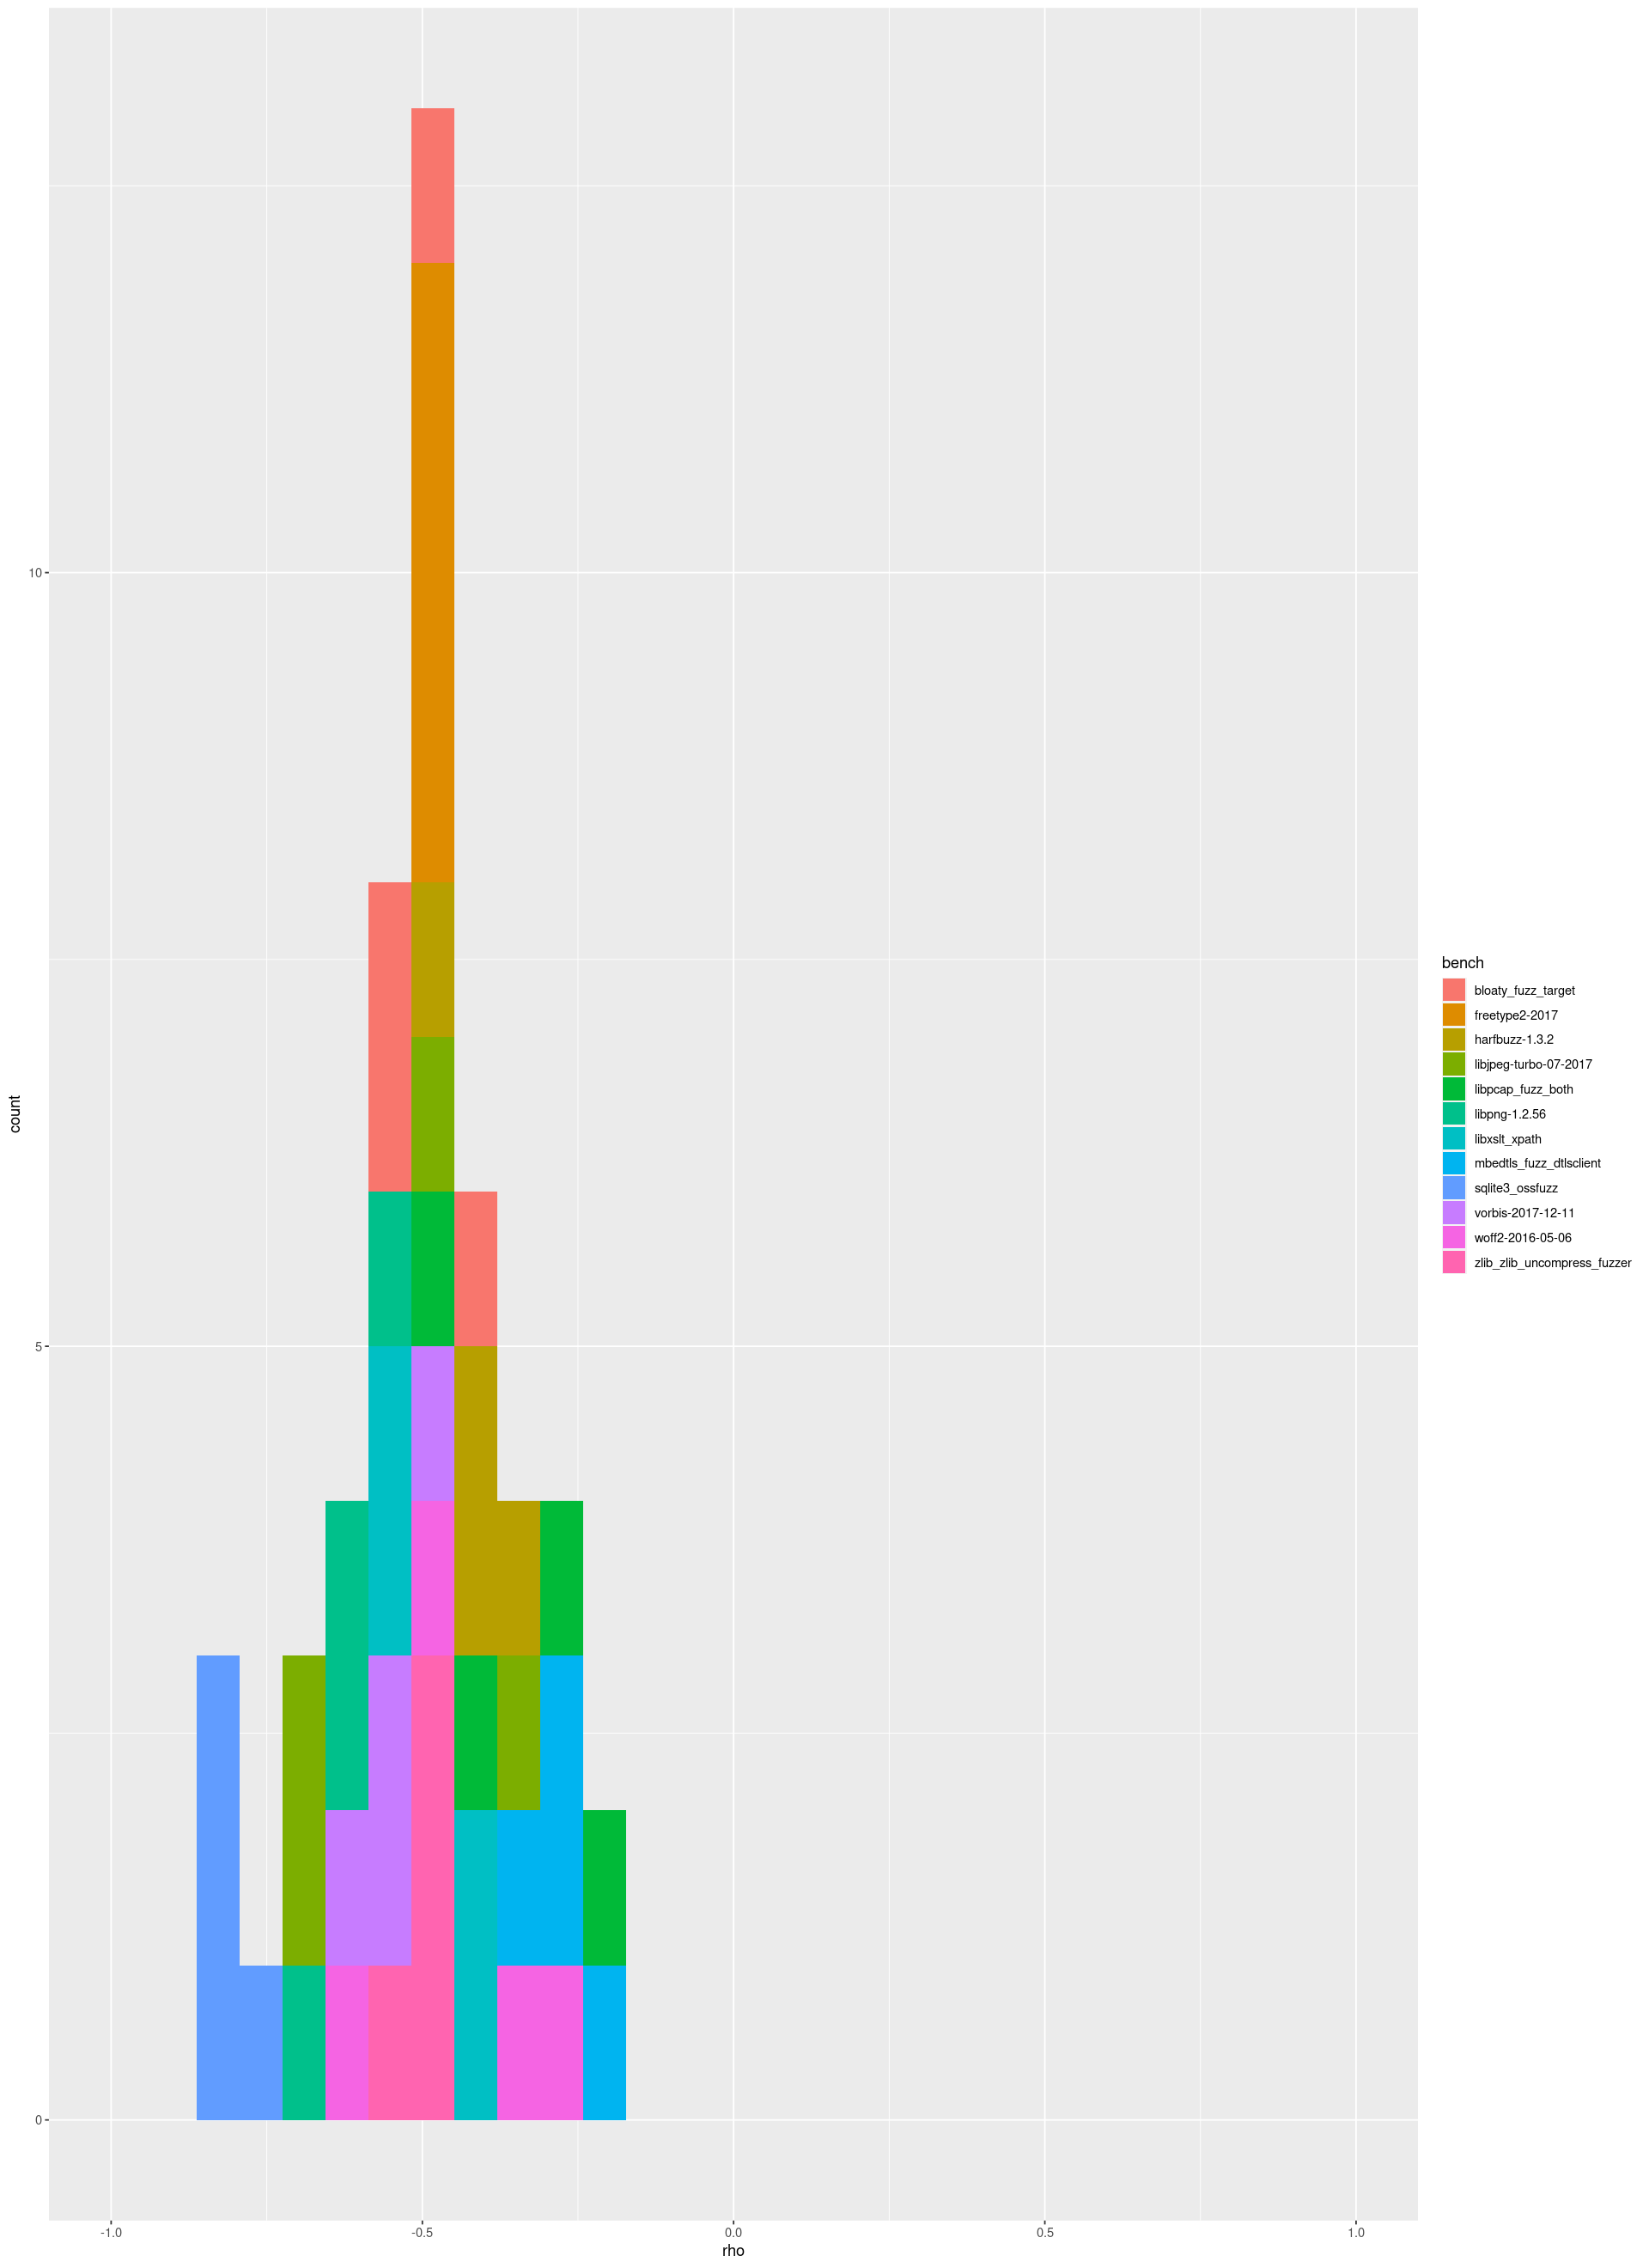

Warning message:
“Removed 8 rows containing missing values (geom_bar).”


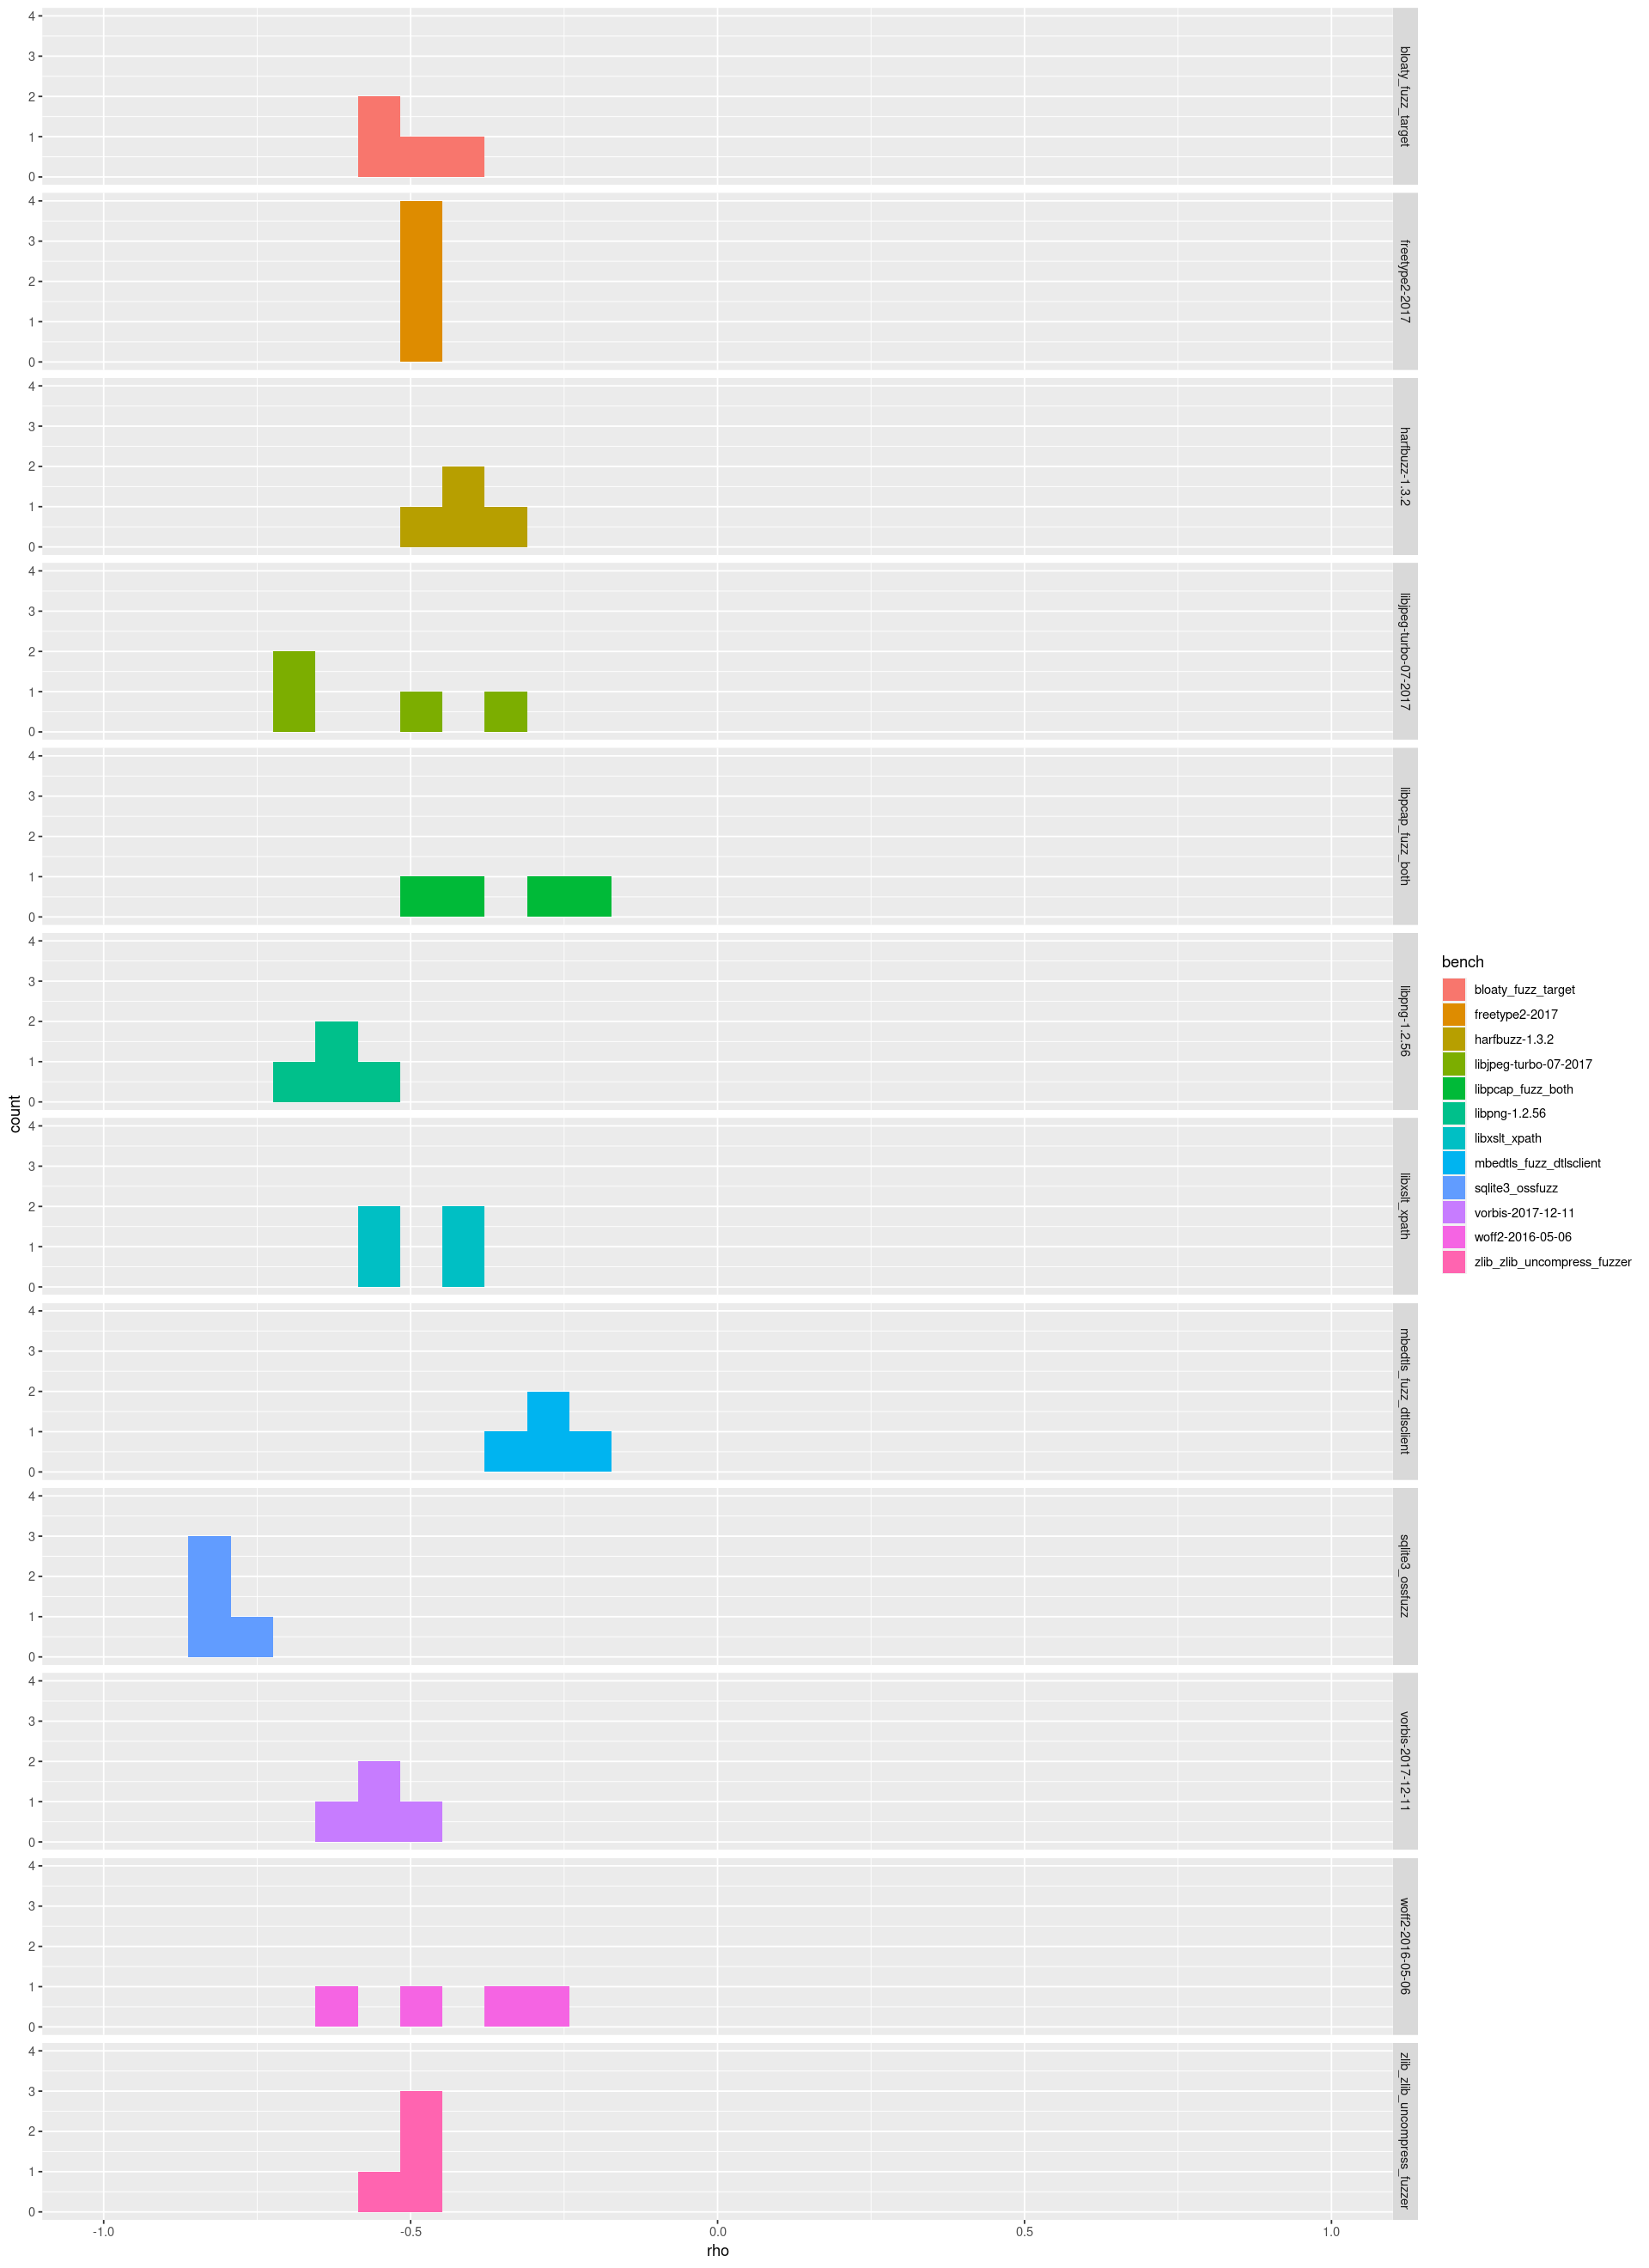

Warning message:
“Removed 8 rows containing missing values (geom_bar).”


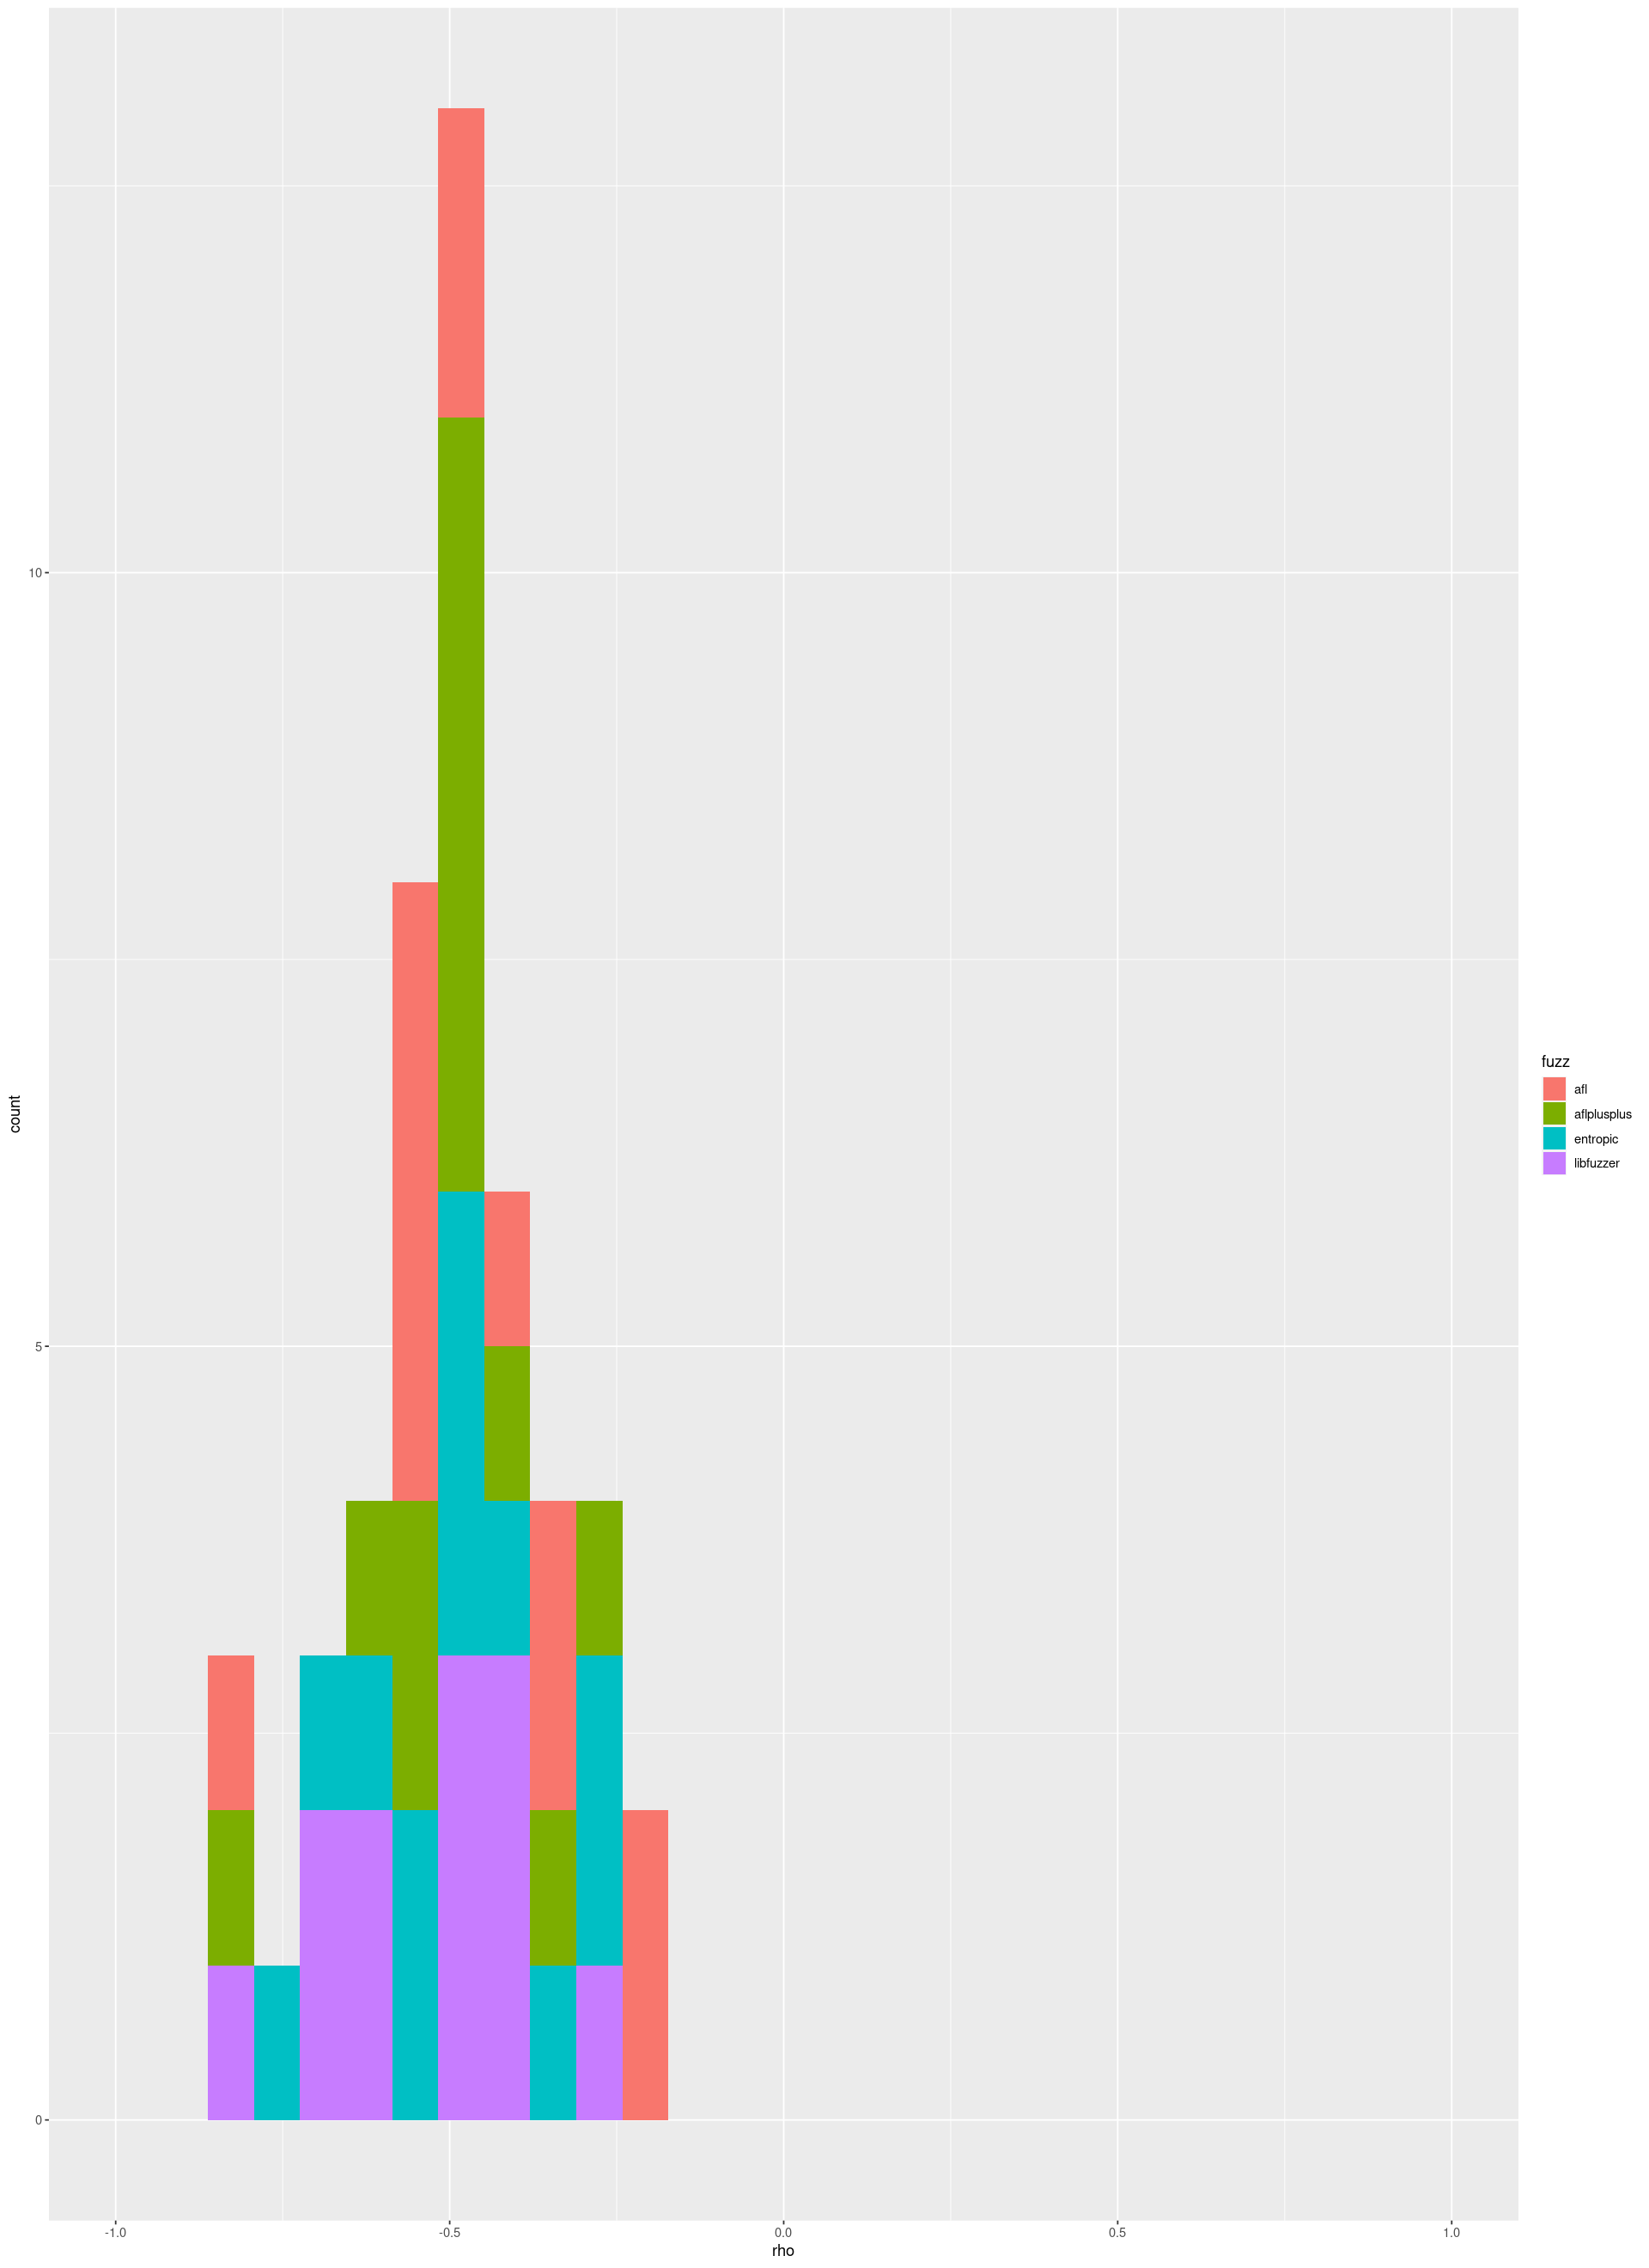

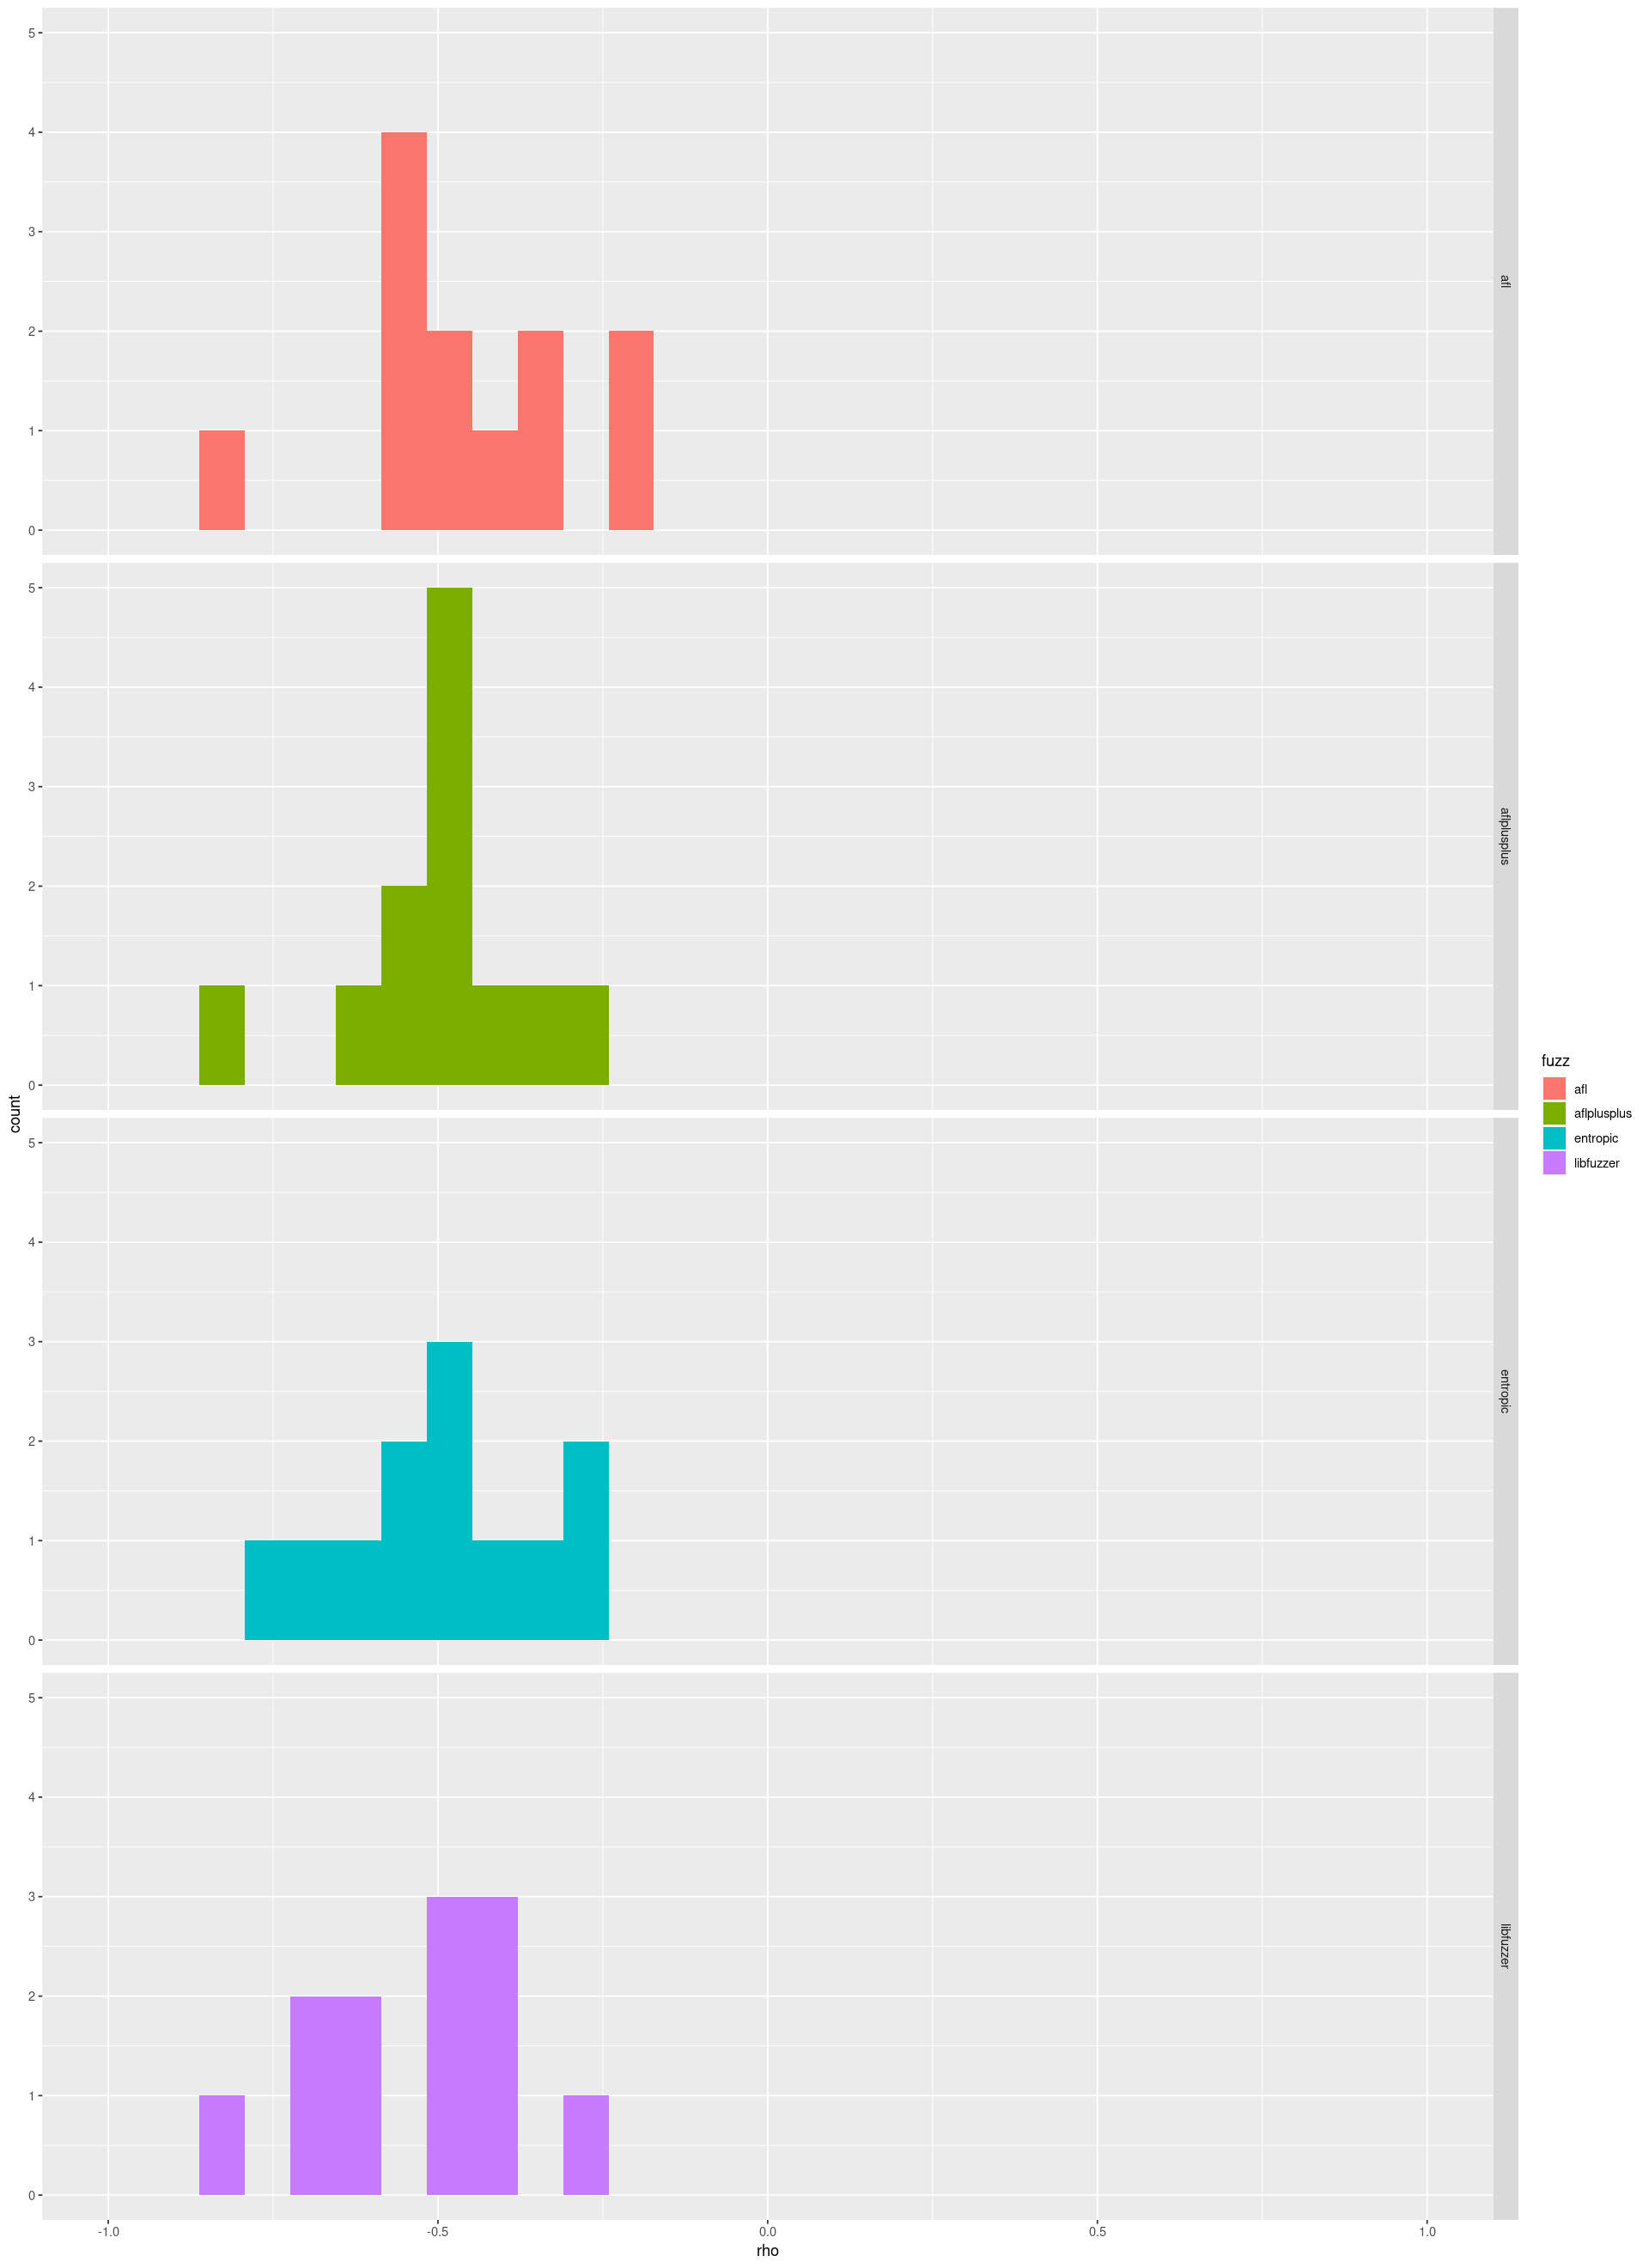

In [81]:
ggp <- ggplot(res, aes(rho, fill = bench)) + geom_histogram(bins=30)
ggp + xlim(-1, 1)
ggp + facet_grid(bench ~ .) + xlim(-1, 1)
ggp2 <- ggplot(res, aes(rho, fill = fuzz)) + geom_histogram(bins=30)
ggp2 + xlim(-1, 1)
ggp2 + facet_grid(fuzz ~ .) + xlim(-1, 1)

# Mixed Effects Model

In [ ]:
library(lme4)

model <- glmer(formula = sqrt(coverage_inc) ~ benchmark + fuzzer + (1 | mean_size_bytes) +
              (1 | initial_coverage) + fuzzer*benchmark +
              (1 | mean_exec_ns), data = d)
model

In [ ]:
plot(model)
qqnorm(resid(model))
qqline(resid(model))

In [ ]:
plot(model,
     sqrt(abs(resid(.)))~fitted(.),
     type=c("p","smooth"), col.line=1)

# Lasso Regression

In [ ]:
# install.packages("glmnet")
require("glmnet")

f <- as.formula(y ~ .*.)
y <- scaled_d$coverage_inc
# Second step: using model.matrix to take advantage of f


vars <- scaled_d[ , ! names(scaled_d) %in% c("coverage_inc", "edges_covered")]
x <- model.matrix(f, vars)[, -1]
dim(x)
cvfit <- cv.glmnet(x, y)
fit <- glmnet(x, y, lamdba=cvfit$lambda.min)
plot(fit)
coef(fit)

# Linear Regression

In [82]:
library(lme4)

model <- glm(formula = log(coverage_inc + 1) ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + q100_exec_ns + q100_mean_size_bytes)^2, data = group_scaled_d)
model

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack





Call:  glm(formula = log(coverage_inc + 1) ~ (benchmark + fuzzer + initial_coverage + 
    mean_size_bytes + mean_exec_ns + q100_exec_ns + q100_mean_size_bytes)^2, 
    data = group_scaled_d)

Coefficients:
                                              (Intercept)  
                                                0.1095827  
                                  benchmarkfreetype2-2017  
                                                0.2287149  
                                  benchmarkharfbuzz-1.3.2  
                                                0.2875674  
                           benchmarklibjpeg-turbo-07-2017  
                                                0.1079853  
                               benchmarklibpcap_fuzz_both  
                                                0.4267003  
                                   benchmarklibpng-1.2.56  
                                                0.2917748  
                                   benchmarklibxslt_xpath  
            

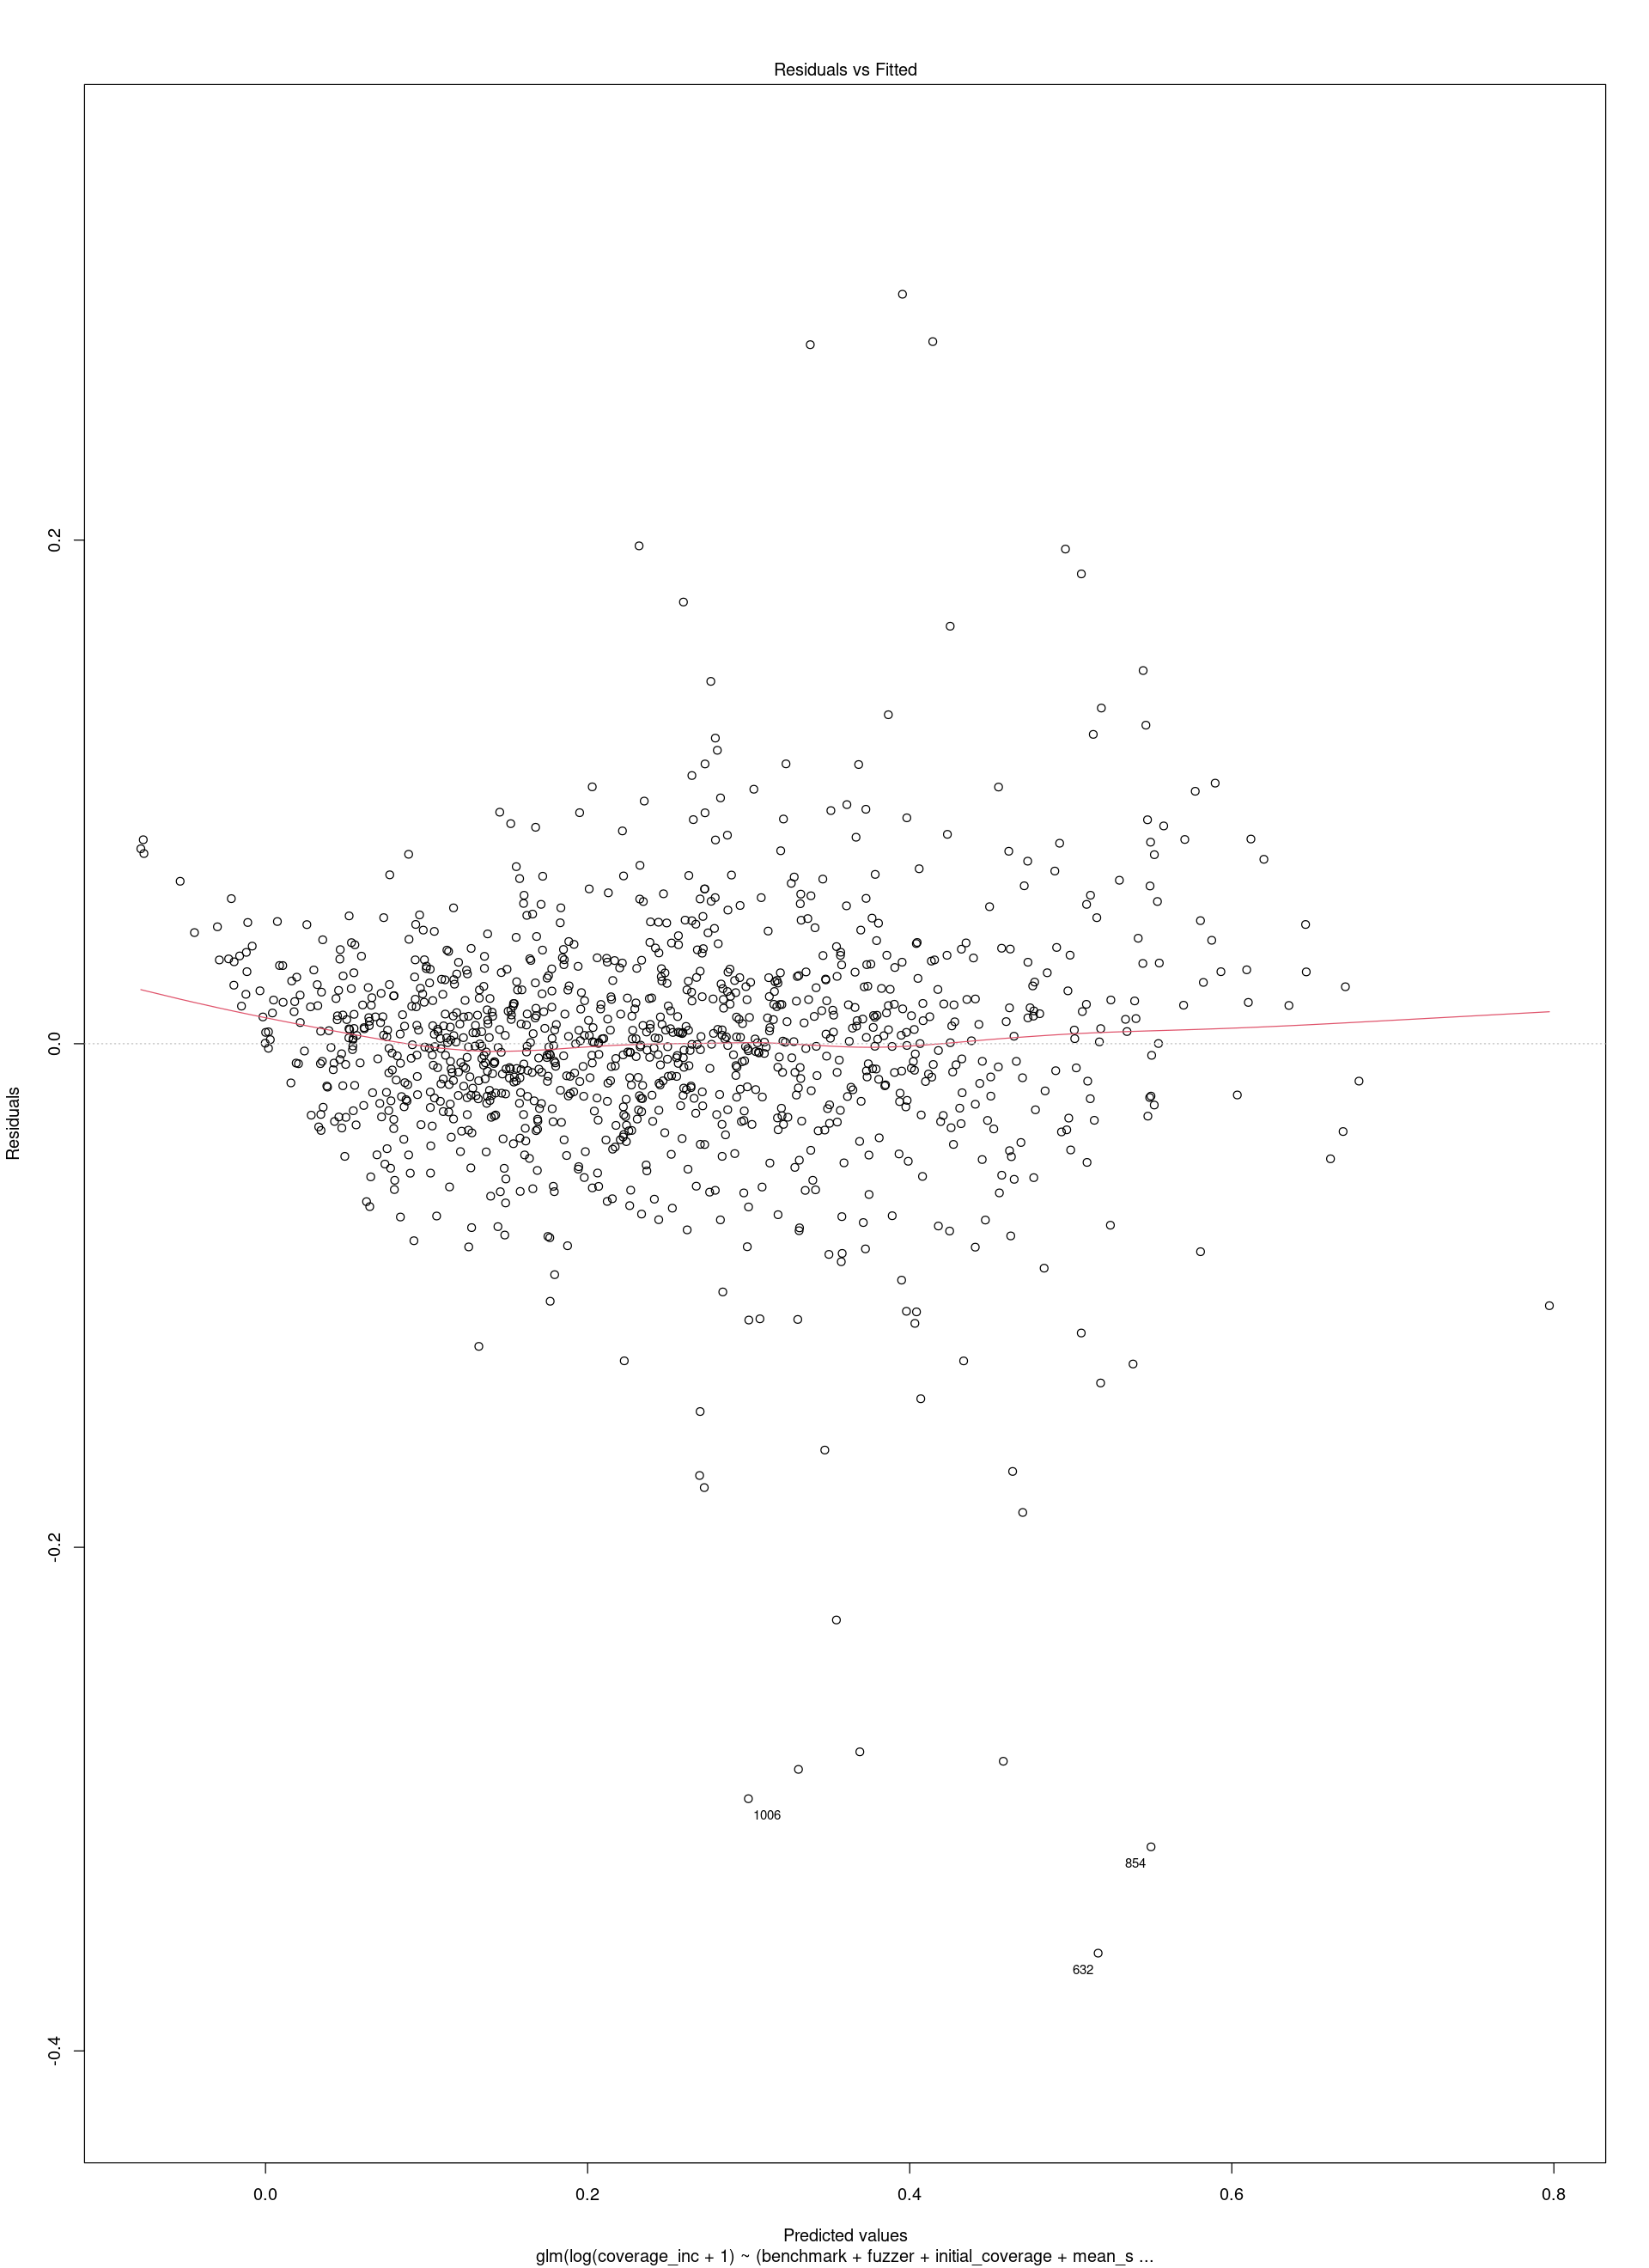

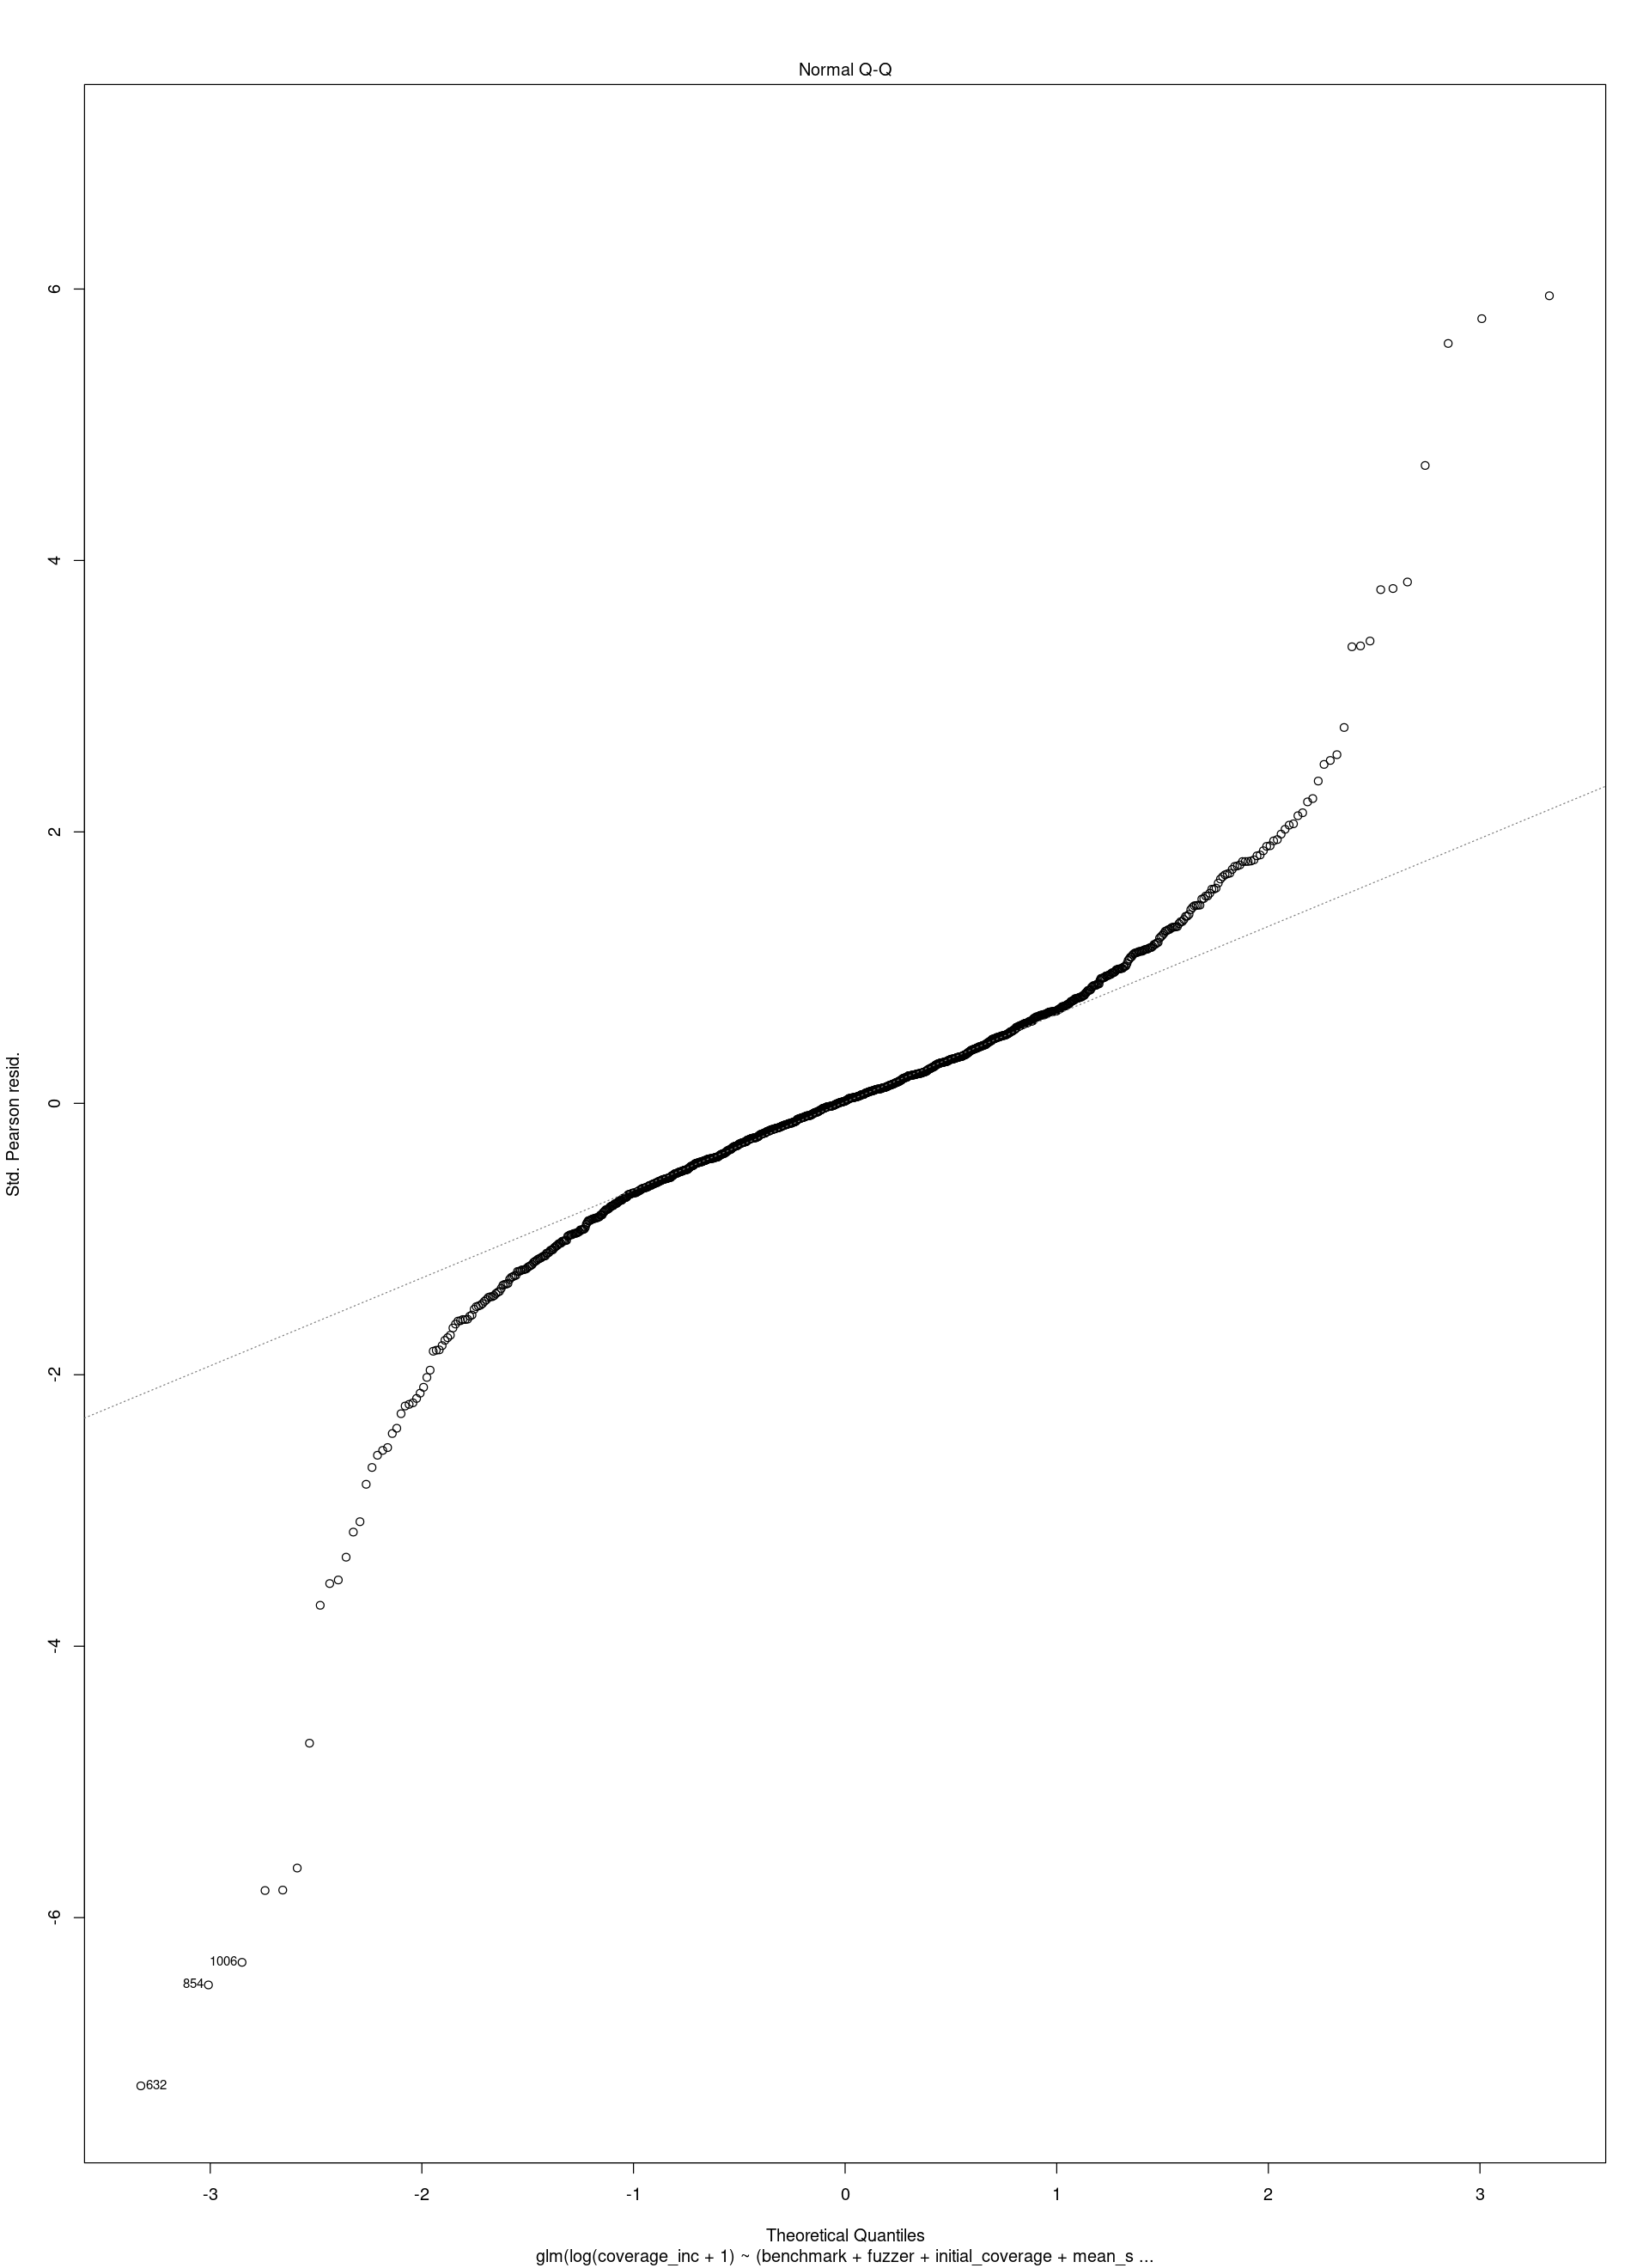

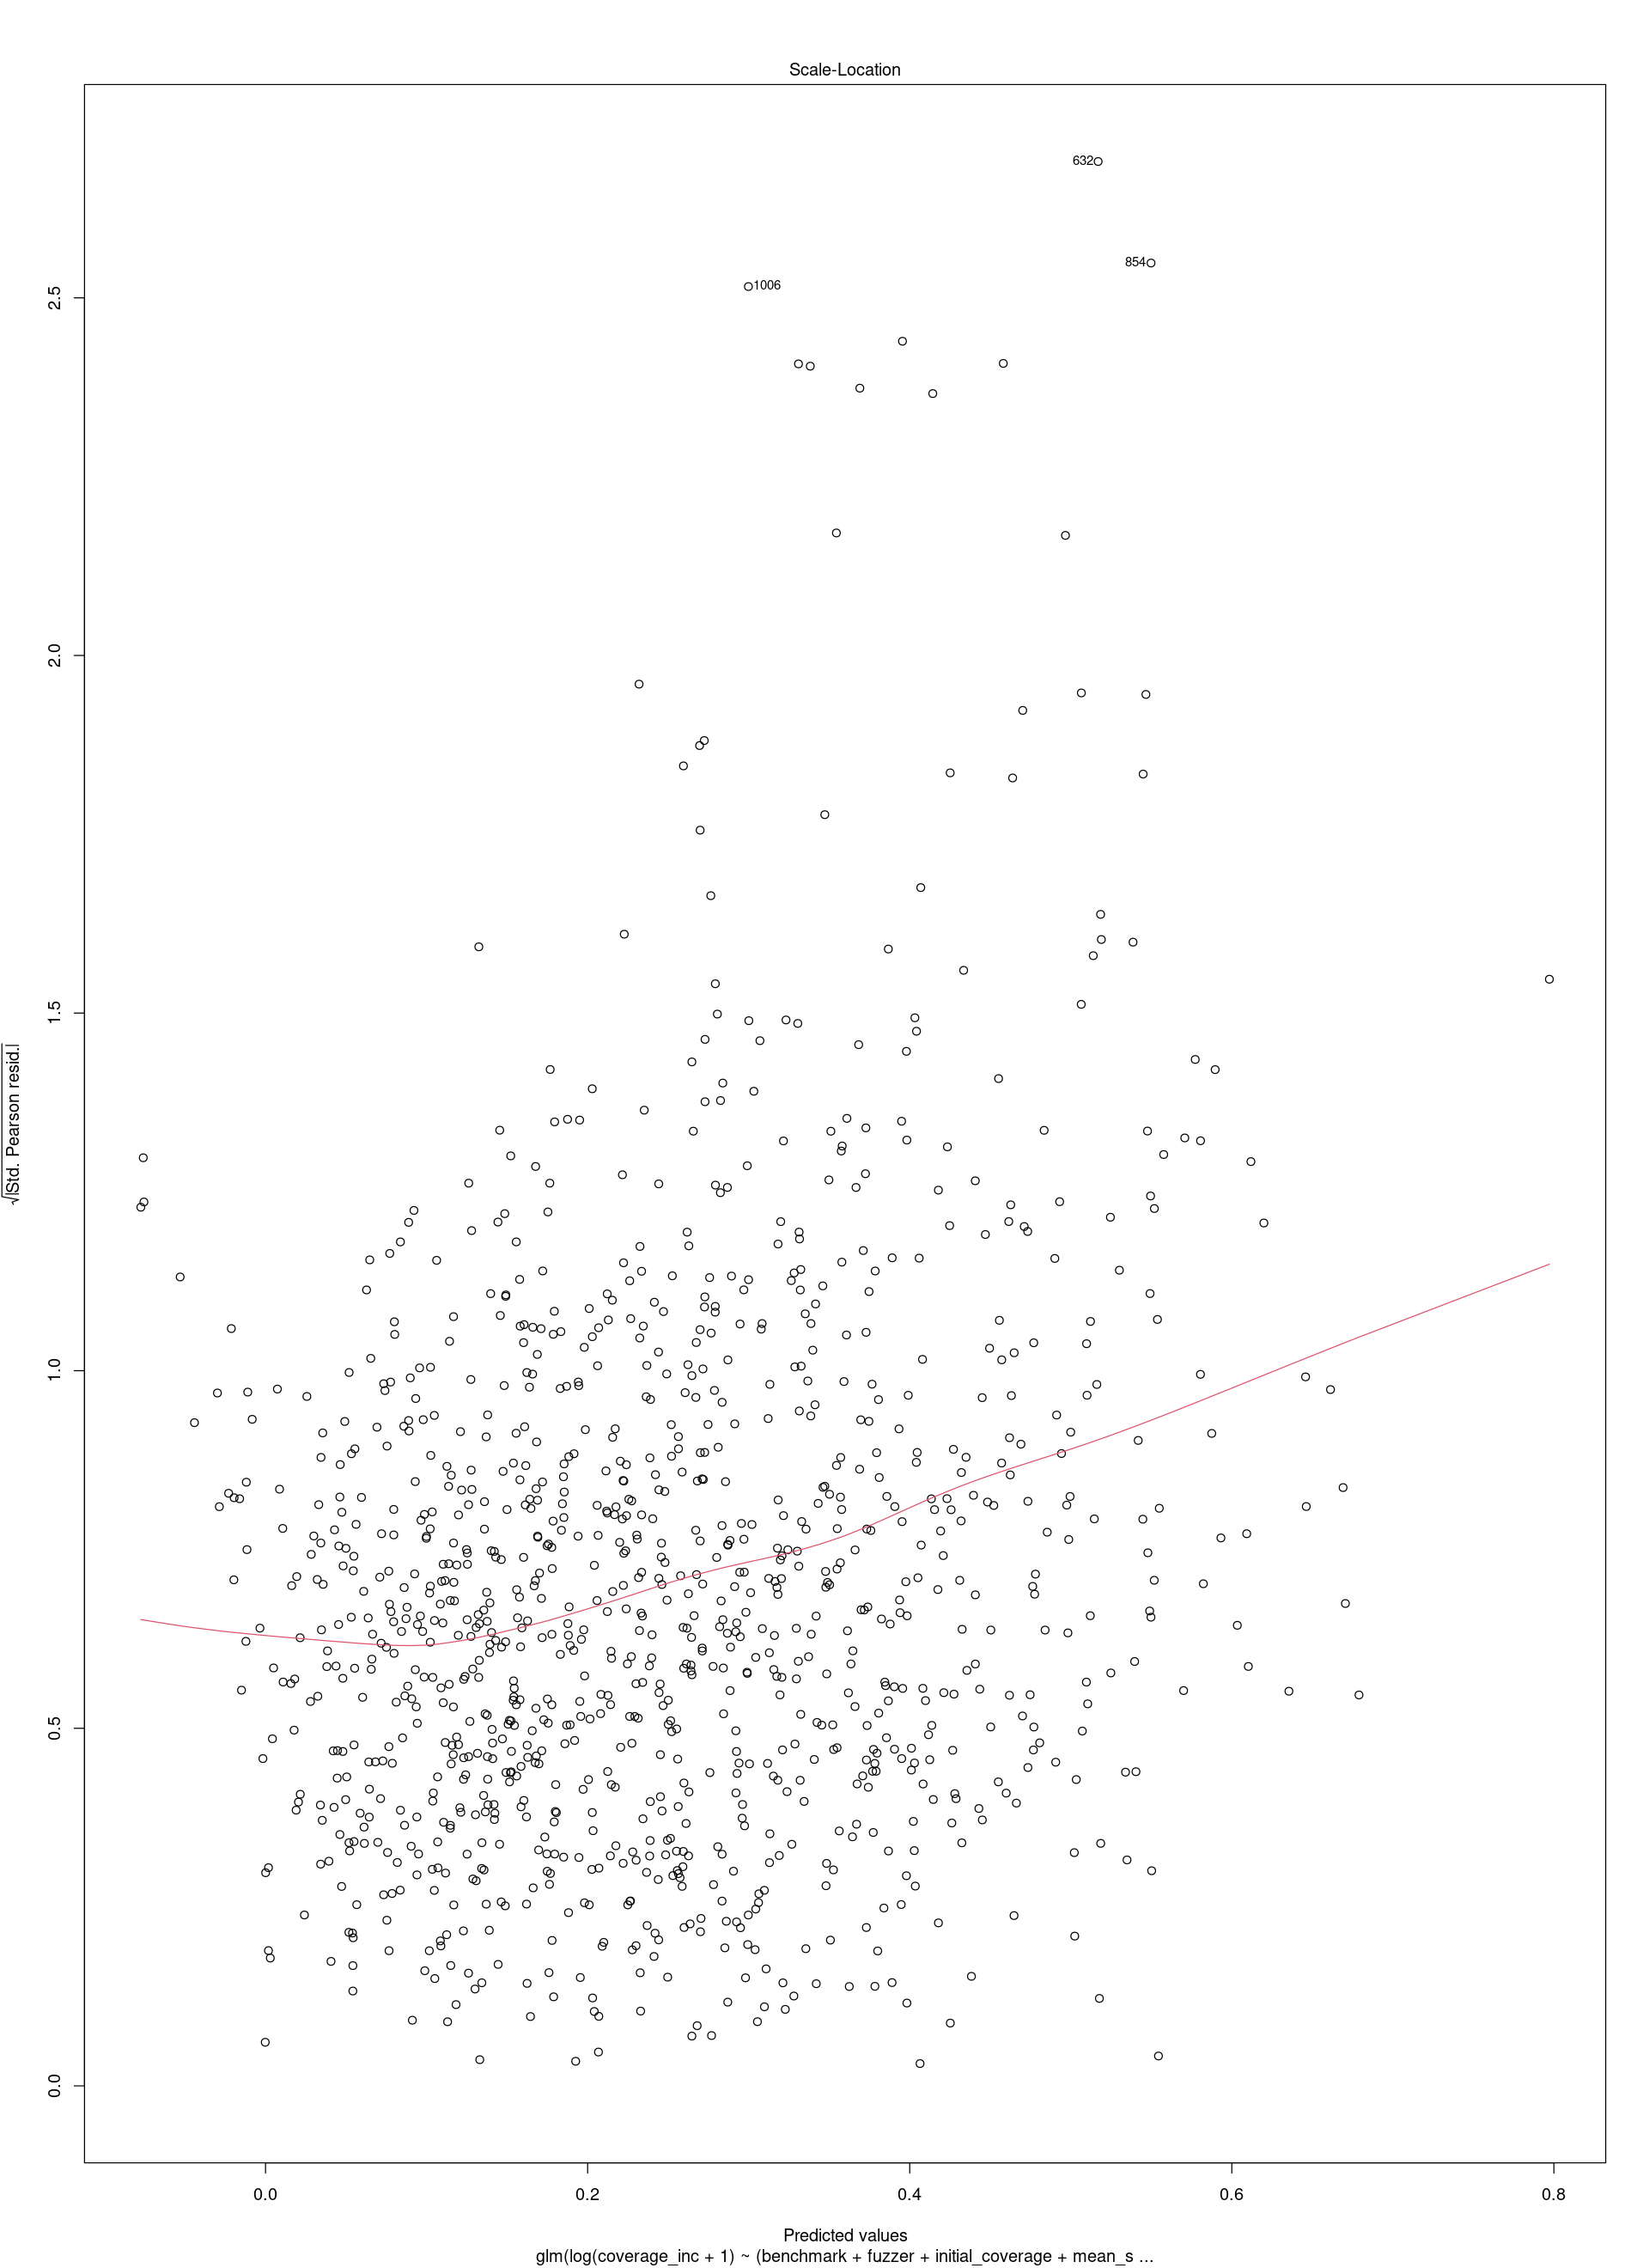

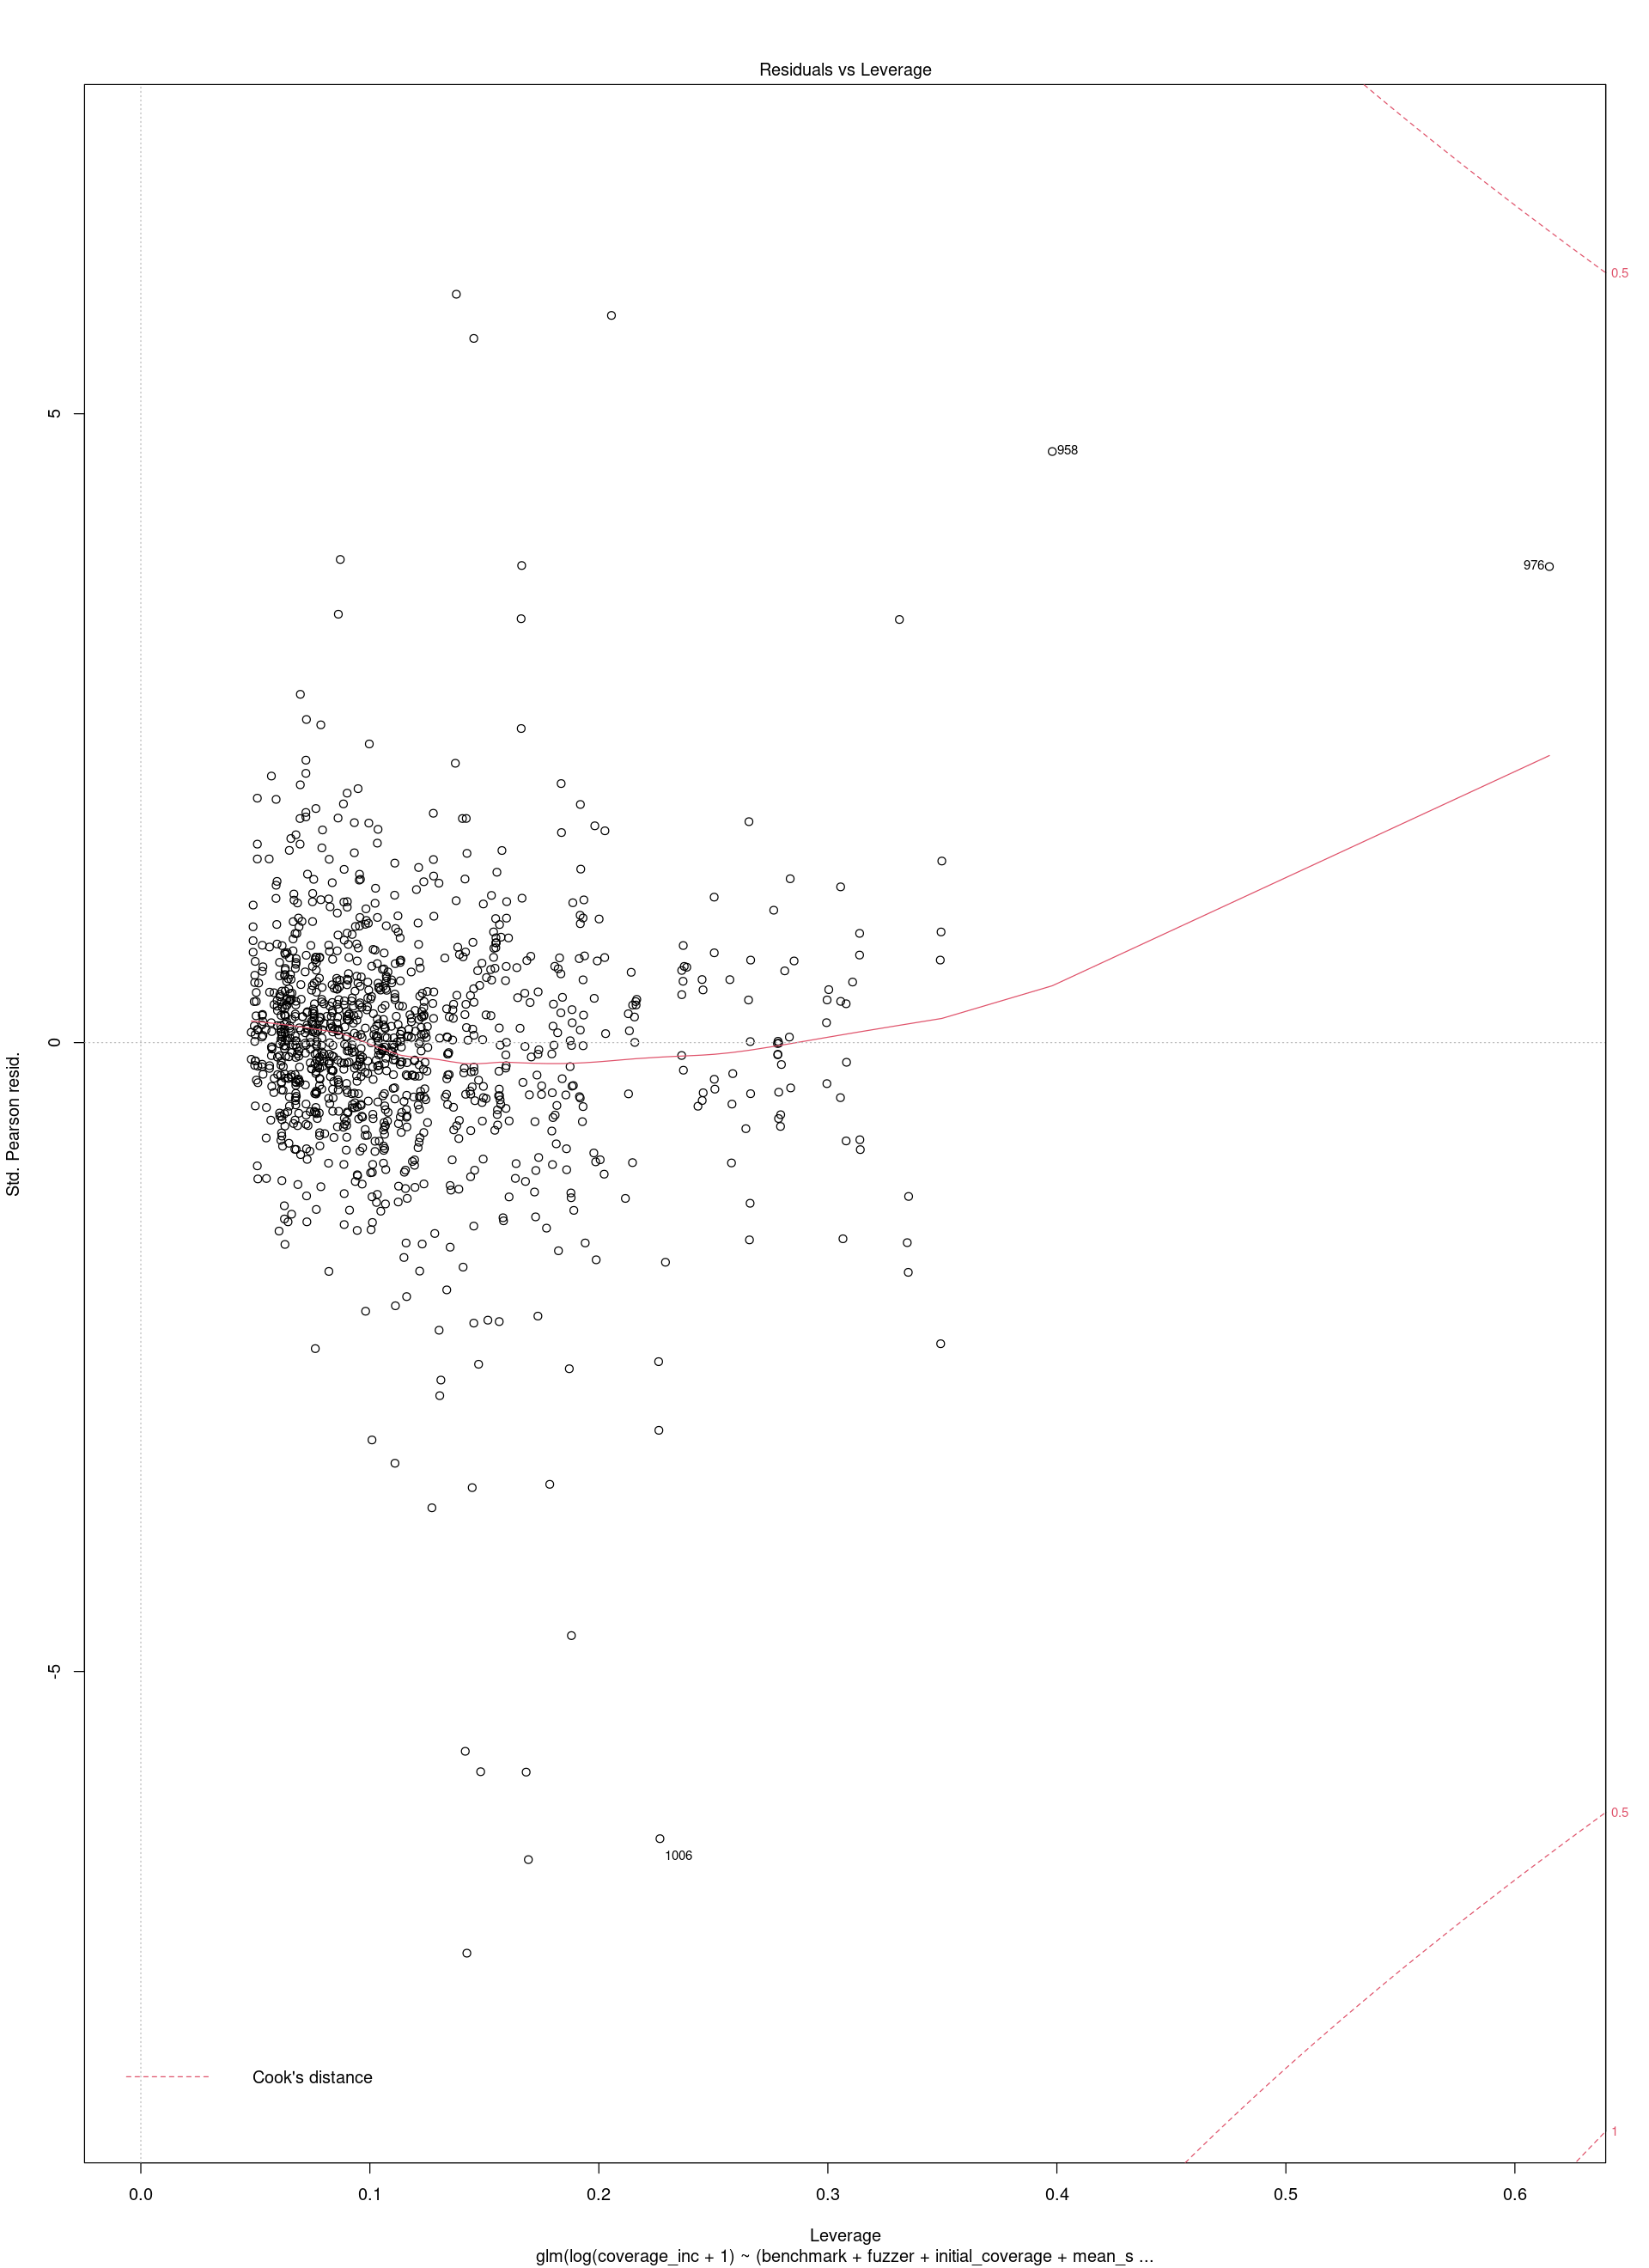

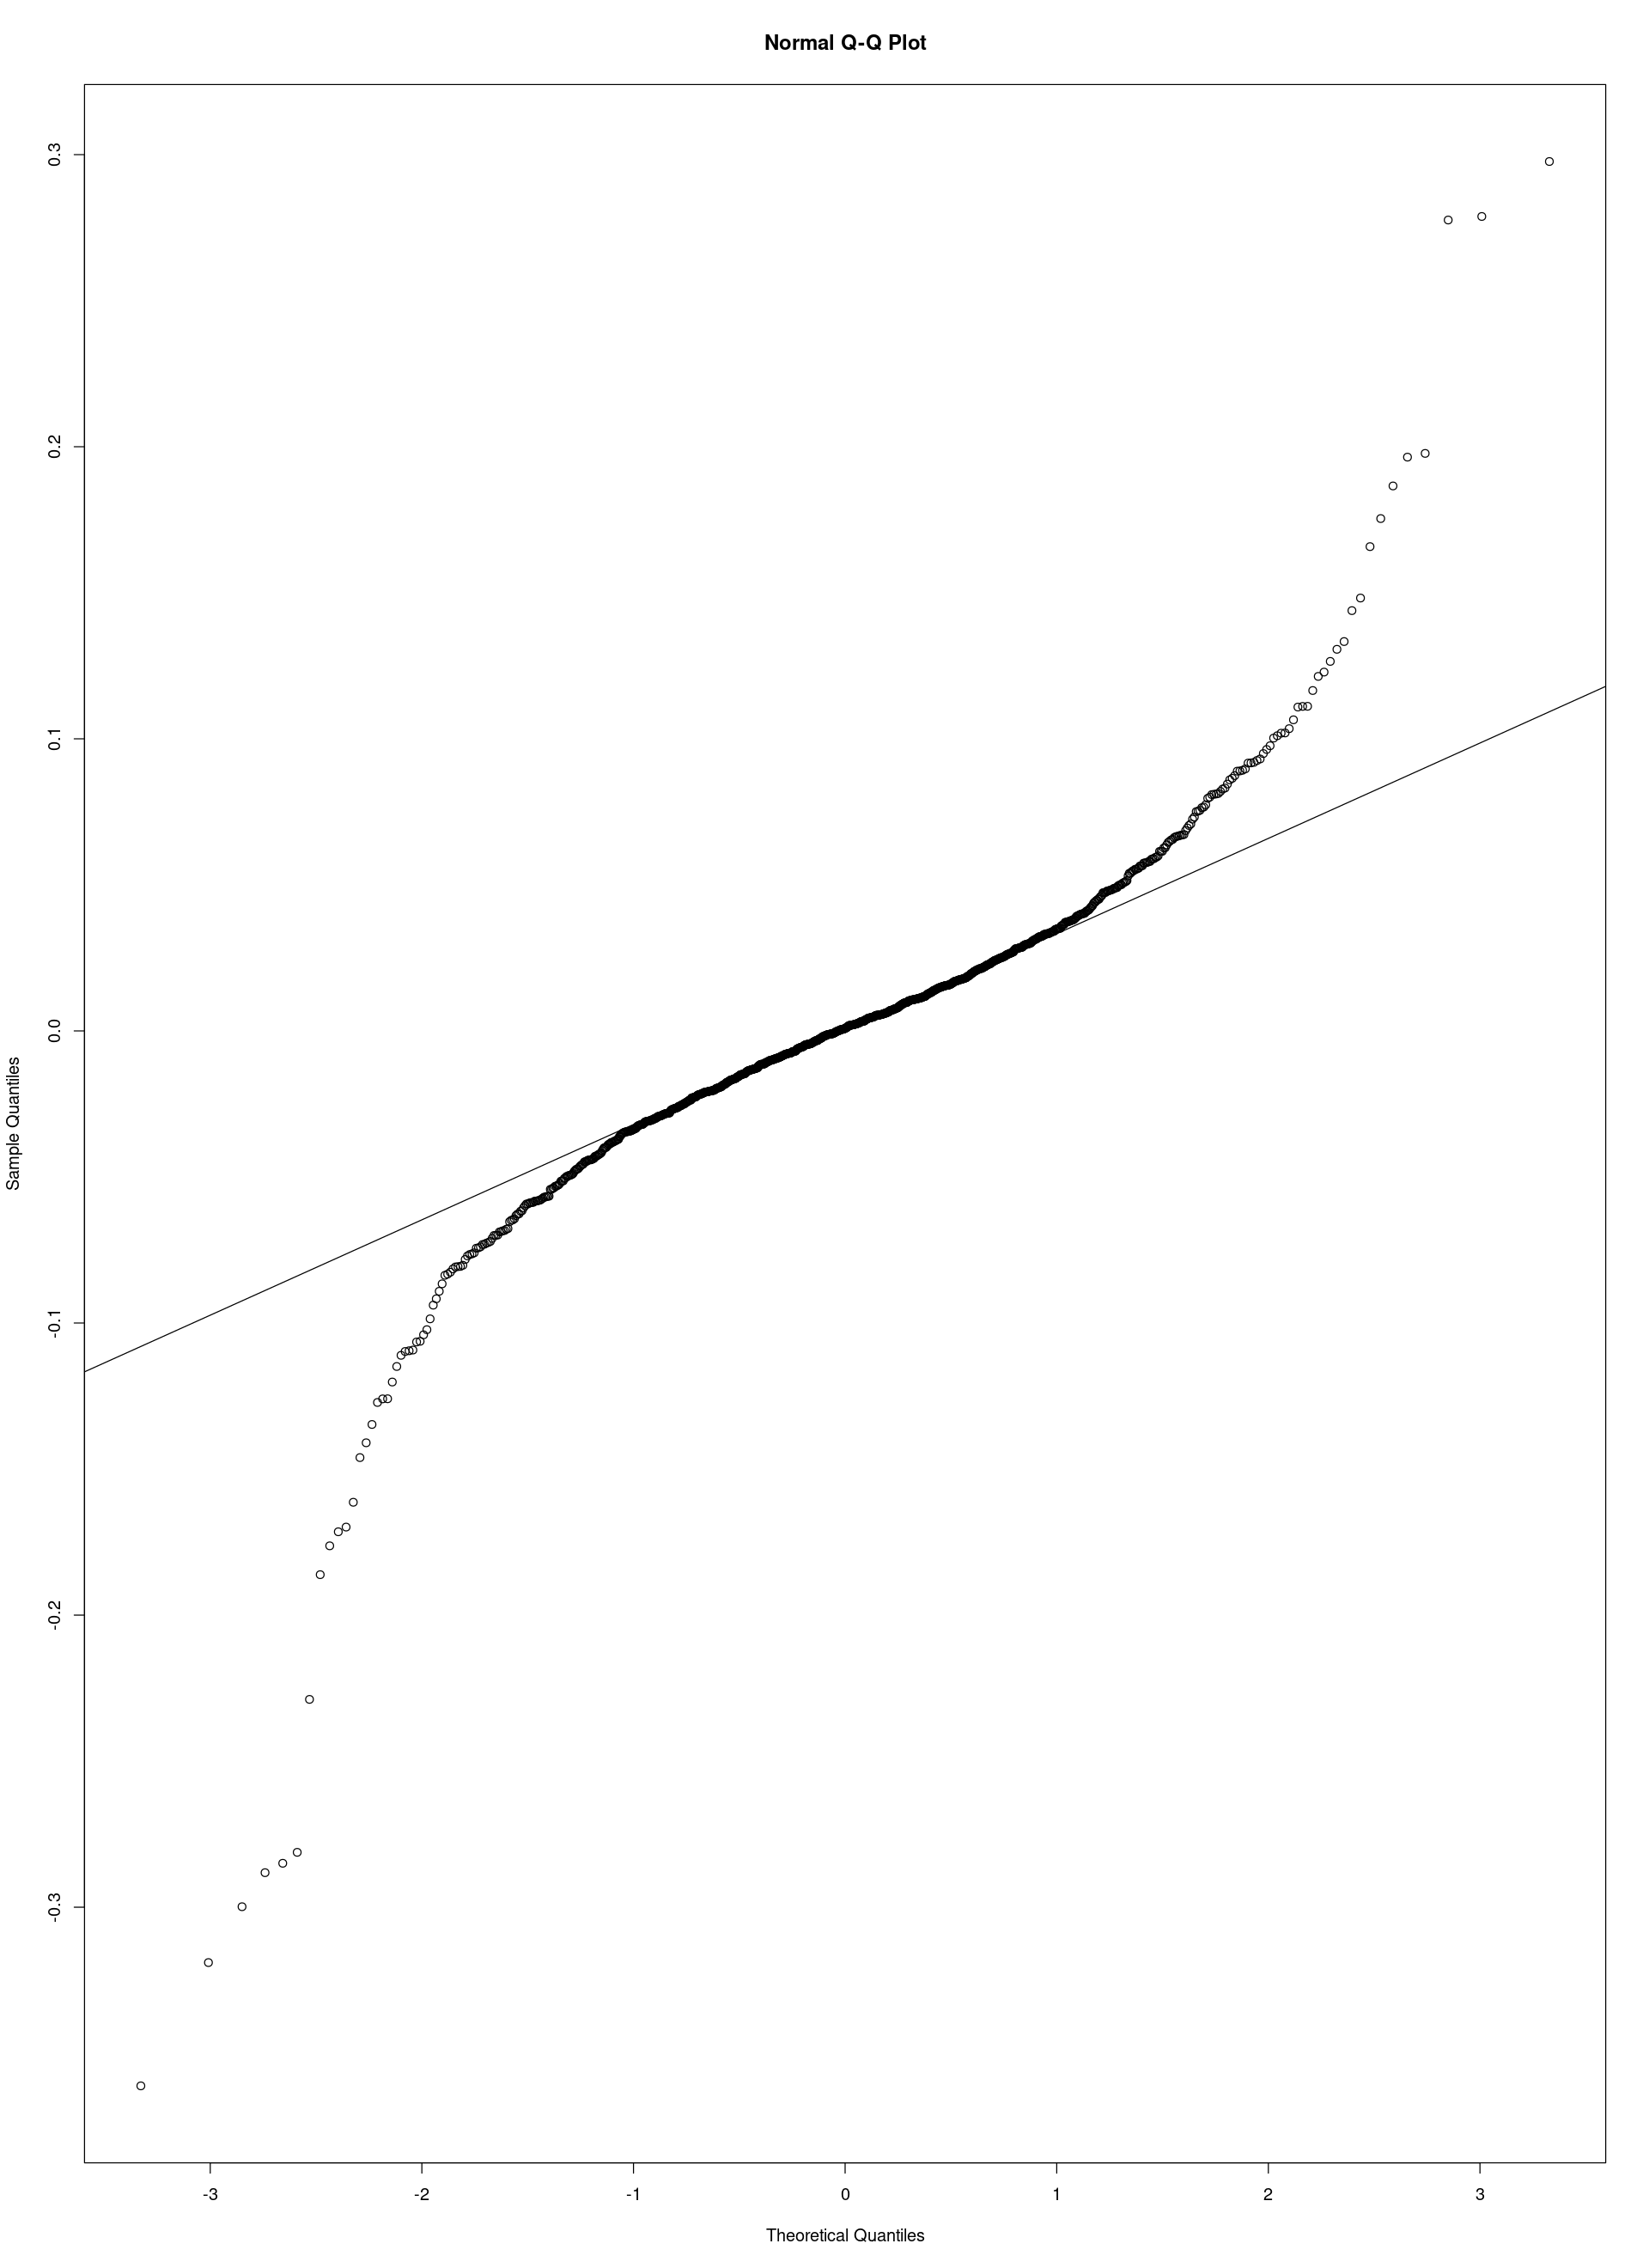

In [83]:
plot(model)
qqnorm(resid(model))
qqline(resid(model))


In [132]:
set.seed(334) # Set Seed so that same sample can be reproduced in future also
# Now Selecting 75% of data as sample from total 'n' rows of the data
s <- floor(.75*nrow(d))
sample <- sample.int(n = nrow(d), size = s, replace = FALSE)
train <- d[sample, ]
test  <- d[-sample, ]

model <- glm(formula = coverage_inc ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = train)

preds <- predict(model, test)
loss <- data.frame(abs(preds - test$coverage_inc))
colMeans(loss, na.rm = TRUE)


abs.preds...test.coverage_inc. 
                      122.9732

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




abs.invBoxCox.preds..lambda....test.coverage_inc. 
                                         7215.723

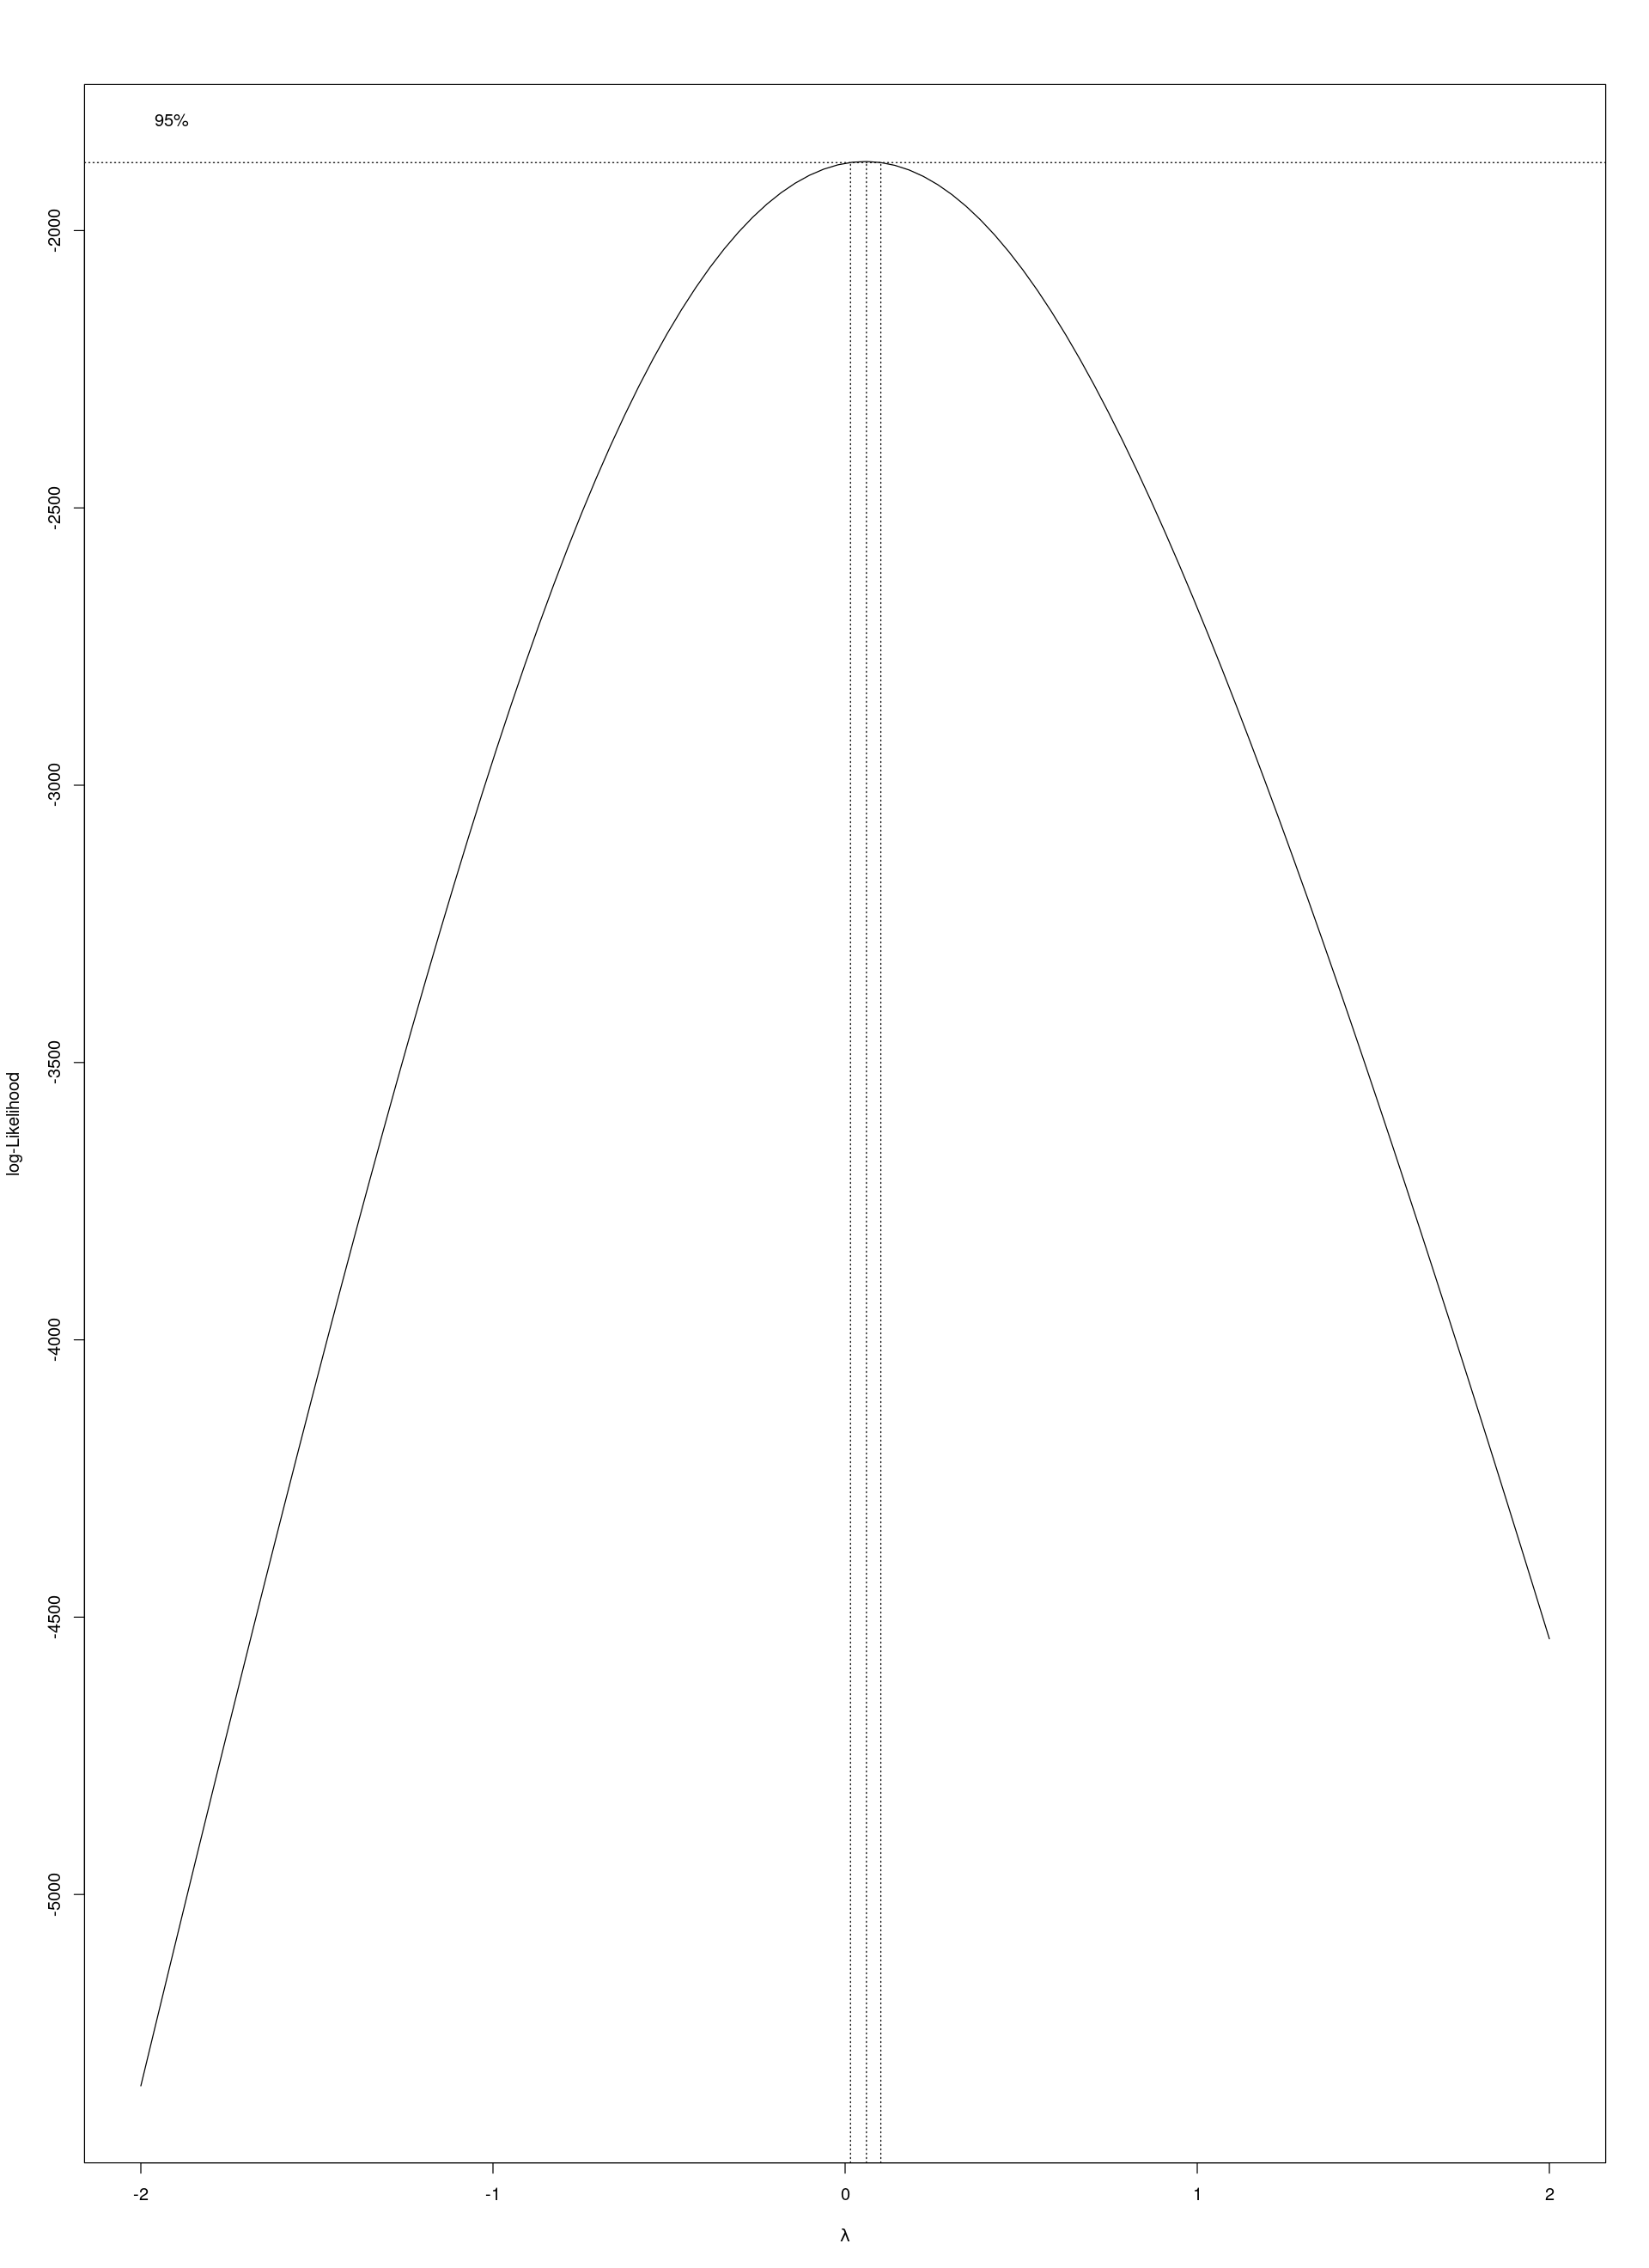

In [21]:
require(MASS)

set.seed(9374) # Set Seed so that same sample can be reproduced in future also
# Now Selecting 75% of data as sample from total 'n' rows of the data
s <- floor(.75*nrow(d))
sample <- sample.int(n = nrow(d), size = s, replace = FALSE)
train <- d[sample, ]
test  <- d[-sample, ]

bc <- boxcox(train$coverage_inc ~ (train$benchmark + train$fuzzer +
              train$initial_coverage + train$mean_size_bytes + 
              train$mean_exec_ns + train$corpus_size)^2)
lambda <- bc$x[which.max(bc$y)]

model <- glm(formula = ((coverage_inc^lambda-1)/lambda) ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = train)

preds <- predict(model, test)
invBoxCox <- function(x, lambda)
    if (lambda == 0) exp(x) else (lambda*x + 1)^(1/lambda)
        
loss <- data.frame(abs(invBoxCox(preds, lambda) - test$coverage_inc))
colMeans(loss, na.rm = TRUE)



In [32]:
set.seed(334) # Set Seed so that same sample can be reproduced in future also

partition = "harfbuzz-1.3.2"
train <- d_statics %>% filter(benchmark != partition)
test  <- d_statics %>% filter(benchmark == partition)

model <- glm(formula = coverage_inc ~ (fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = train)

preds <- predict(model, test)
loss <- data.frame(abs(preds - test$coverage_inc))
colMeans(loss, na.rm = TRUE)


abs.preds...test.coverage_inc. 
                      1159.241

In [65]:
install.packages("caret", dependencies = TRUE)

library(caret)

#specify the cross-validation method
ctrl <- trainControl(method = "cv", number = 5)

#fit a regression model and use k-fold CV to evaluate performance
model <- train(log(coverage_inc) ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = d, method = "glm", trControl = ctrl)

#view summary of k-fold CV               
print(model)


Installing package into ‘/home/wolffd/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

Warning message:
“dependency ‘randomForest’ is not available”

Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster


The following object is masked from ‘package:purrr’:

    lift


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“predicti

Generalized Linear Model 

1064 samples
   6 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 850, 851, 852, 851, 852 
Resampling results:

  RMSE       Rsquared   MAE      
  0.1929091  0.9643883  0.1302255



# POLR on Fuzzer rank

In [88]:
library(MASS)
library(questionr)

scaled_statics <- statics %>% mutate_if(is.numeric, rescale)
polr_data <- group_scaled_d
polr_data <- merge(x = polr_data, y = scaled_statics, by = "benchmark", all.x = TRUE)
# polr_data <- polr_data %>% filter(fuzzer == "libfuzzer")
head(polr_data)


model <- polr(formula = per_trial_ranks ~ fuzzer + initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer + fuzzer*benchmark + fuzzer*bin_text_size,
             data = polr_data)
# model <- polr(formula = per_trial_ranks ~ initial_coverage + mean_size_bytes + mean_exec_ns + q100_exec_ns + q100_mean_size_bytes,
#                data = polr_data)

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
coefficients <- cbind(coefficients, p_value)

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
)

MASS_model <- model
summary(model)

exp(model$coefficients)
coefficients

odds.ratio(model, level=0.95)

,benchmark,fuzzer,corpus_size,initial_coverage,ineq_reached,ineq_unexplored,indir_reached,shared_reached,mean_exec_ns,mean_size_bytes,⋯,mean_exec_ms,ineq_unex_perc,coverage_inc_unscaled,per_trial_ranks,per_trial_ranks_numeric,total_shared,total_eq,total_ineq,total_indir,bin_text_size
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,bloaty_fuzz_target,aflplusplus,0.05113636,0.7214666,0.4985739,0.5934539,0.8064516,0.5,0.7225991,1.0000000,⋯,0.7225991,0.06380006,1183,1,1,0.3370239,1,1,0.4227141,0.4425367
2,bloaty_fuzz_target,aflplusplus,0.20170455,0.8407747,0.7438677,0.8122308,0.9032258,0.5,0.2416352,0.2008344,⋯,0.2416352,0.10781216,1008,1,1,0.3370239,1,1,0.4227141,0.4425367
3,bloaty_fuzz_target,aflplusplus,0.18465909,0.8320520,0.6668568,0.7372954,0.9032258,0.5,0.9984766,0.2826331,⋯,0.9984766,0.05782952,927,1,1,0.3370239,1,1,0.4227141,0.4425367
4,bloaty_fuzz_target,aflplusplus,0.60227273,0.9643702,0.9503708,1.0000000,0.9838710,0.5,0.2480041,0.2925904,⋯,0.2480041,0.11506983,500,1,1,0.3370239,1,1,0.4227141,0.4425367
5,bloaty_fuzz_target,aflplusplus,0.40625000,0.9169131,0.8767827,0.9405685,0.9354839,0.5,0.1745763,0.1818577,⋯,0.1745763,0.12171765,720,1,1,0.3370239,1,1,0.4227141,0.4425367
6,bloaty_fuzz_target,aflplusplus,0.39488636,0.9160260,0.8596691,0.9345392,0.9354839,0.5,0.3208853,0.2347371,⋯,0.3208853,0.11827140,598,2,2,0.3370239,1,1,0.4227141,0.4425367


Warning message in polr(formula = per_trial_ranks ~ fuzzer + initial_coverage * :
“design appears to be rank-deficient, so dropping some coefs”

Re-fitting to get Hessian




ERROR: Error in polr(formula = per_trial_ranks ~ fuzzer + initial_coverage * : 'start' is not of the correct length


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


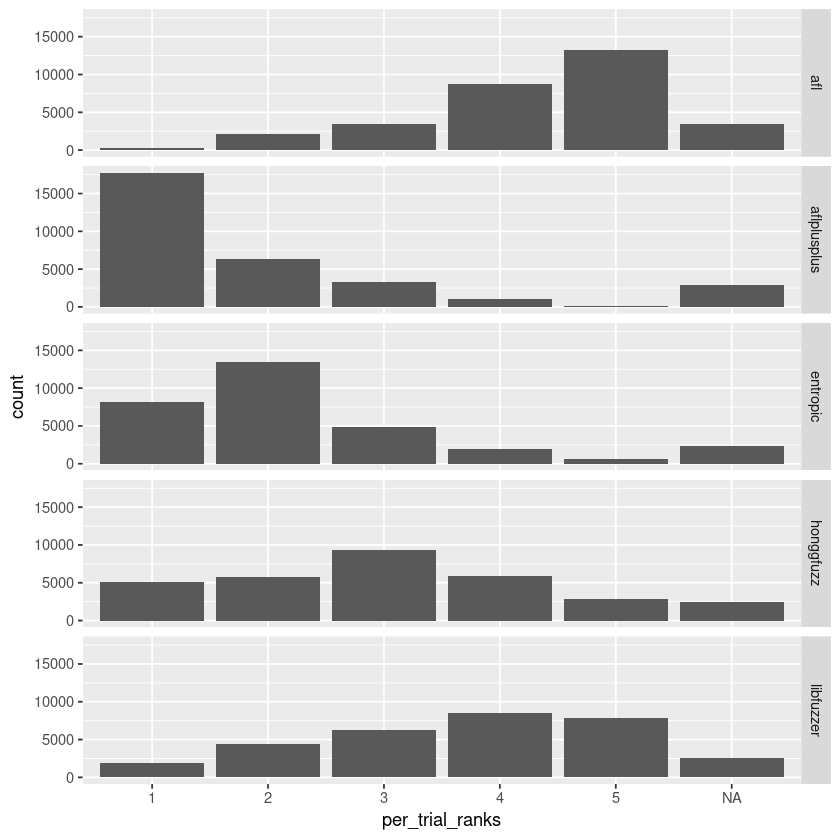

In [21]:
ggp <- ggplot(polr_data, aes(per_trial_ranks)) + geom_histogram(stat="count")
ggp + facet_grid(fuzzer ~ .)

In [87]:
library(mctest)
require(generalhoslem)
require(pulkrob)
require(brant)

brant::brant(model)

generalhoslem::lipsitz.test(model)
pulkrob.chisq(model, c("fuzzer", "benchmark"))
pulkrob.deviance(model, c("fuzzer", "benchmark"))

logitgof((polr_data %>% drop_na())$per_trial_ranks, fitted(model, na), g = 10, ord = TRUE)
# gof((polr_data)$per_trial_ranks, fitted(model, na), g = 2, ord = TRUE)

# mctest::omcdiag(mod = model)

Loading required package: pulkrob

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pulkrob’”


---------------------------------------------------- 
Test for		X2	df	probability 
---------------------------------------------------- 
Omnibus			21.09	10	0.02
initial_coverage	1.27	2	0.53
mean_size_bytes	7.02	2	0.03
mean_exec_ns		2.75	2	0.25
q100_exec_ns		0.86	2	0.65
q100_mean_size_bytes	7.18	2	0.03
---------------------------------------------------- 

H0: Parallel Regression Assumption holds



	Lipsitz goodness of fit test for ordinal response models

data:  formula:  per_trial_ranks ~ initial_coverage + mean_size_bytes + mean_exec_ns + formula:      q100_exec_ns + q100_mean_size_bytes
LR statistic = 6.8904, df = 9, p-value = 0.6485


ERROR: Error in `[.data.frame`(ndat, , ncol(ndat):2): undefined columns selected


In [33]:
library(rms)

rms_model <- orm(formula = per_trial_ranks ~ fuzzer + fuzzer*benchmark +
    initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer, 
    data = polr_data %>% drop_na())
rms_model
s <- summary(rms_model)
plot(s) + xlim(-1, 1)

Logistic (Proportional Odds) Ordinal Regression Model
 
 orm(formula = per_trial_ranks ~ fuzzer + fuzzer * benchmark + 
     initial_coverage * fuzzer + mean_size_bytes * fuzzer + mean_exec_ns * 
     fuzzer, data = polr_data %>% drop_na())
 
 
 Frequencies of Responses
 
   1   2   3   4   5 
 277 268 227 218 205 
 
                         Model Likelihood               Discrimination    Rank Discrim.    
                               Ratio Test                      Indexes          Indexes    
 Obs           1195    LR chi2    1325.44    R2                  0.698    rho     0.818    
 Distinct Y       5    d.f.            69    R2(69,1195)         0.651                     
 Median Y         3    Pr(> chi2) <0.0001    R2(69,1145.2)       0.666                     
 max |deriv| 0.0007    Score chi2 1306.27    |Pr(Y>=median)-0.5| 0.330                     
                       Pr(> chi2) <0.0001                                                  
 
                                   

ERROR: Error in summary.rms(rms_model): adjustment values not defined here or with datadist for fuzzer benchmark initial_coverage mean_size_bytes mean_exec_ns


In [163]:
# Plots described in 14.2 of RMS book can't be done for interaction effects, also not working
# plot.xmean.ordinaly(per_trial_ranks ~ fuzzer, data=polr_data)

dim(polr_data)
require(Hmisc)

myqlogis <- function(y, n, v=100000) {
    r <- qlogis(mean(y >= n))
    if (is.na(r)) { return(v) }
    if (r < -v) { return(-v) }
    if (r > v) { return(v) }
    return(r)
}
    
sf <- function(y) 
    c("Y>=1"=myqlogis(y,1), "Y>=2"=myqlogis(y, 2), "Y>=3"=myqlogis(y, 3), "Y>=4"=myqlogis(y, 4), "Y>=5"=myqlogis(y, 5))

s <- summary(per_trial_ranks_numeric ~ fuzzer, fun=sf, data=polr_data)
jpeg("assets/e2-po-check.jpg", width = 800, height = 1000)
plot(s, which=1:5, pch=1:5, xlab='logit', vnames='names', main = '', xlim=c(-4,4), width.factor=1.5)
dev.off()

s <- summary(per_trial_ranks_numeric ~ initial_coverage + mean_size_bytes + mean_exec_ns, fun=sf, data=polr_data %>%
             filter(fuzzer == "afl"))
jpeg("assets/e2-po-check-strat-afl.jpg", width = 800, height = 1000)
plot(s, which=1:5, pch=1:5, xlab='logit', vnames='names', main = '', xlim=c(-4,4), width.factor=1.5)
dev.off()


s <- summary(per_trial_ranks_numeric ~ initial_coverage + mean_size_bytes + mean_exec_ns, fun=sf, data=polr_data %>%
             filter(fuzzer == "libfuzzer" & benchmark == "bloaty_fuzz_target"))



jpeg("assets/e2-po-check-strat-fuzzer-afl-harf.jpg", width = 800, height = 1000)
plot(s, which=1:5, pch=1:5, xlab='logit', vnames='names', main = '', xlim=c(-4,4), width.factor=1.5)
dev.off()


[1] 1309   18

png 
  2

png 
  2

png 
  2

In [164]:
# install.packages("texreg")
require(texreg)

t <- texreg(MASS_model, use.packages=FALSE, scriptsize=FALSE, strong.signif=TRUE)
cat(t,file="assets/e2-polr-table.tex", label="tab:e2-polr-table")

Loading required package: texreg

Version:  1.38.6
Date:     2022-04-06
Author:   Philip Leifeld (University of Essex)

Consider submitting praise using the praise or praise_interactive functions.
Please cite the JSS article in your publications -- see citation("texreg").


Attaching package: ‘texreg’


The following object is masked from ‘package:tidyr’:

    extract



Re-fitting to get Hessian




In [44]:
# install.packages("jtools")
# install.packages("ggstance")

require(jtools)
require(ggstance)


ci <- confint(polr_model)
rms_c <- data.frame(rms_model$coefficients)
dim(rms_c)
dim(ci)

results <- merge(ci, rms_c, by='row.names')
resutls <- results %>% drop_na()

names(results)[2] <- 'conf95_low'
names(results)[3] <- 'conf95_high'
results[1] <- apply(results[1], 1, toString)


ff <- function(n) {
    (grepl("mean", n, fixed=TRUE) | grepl("initial", n, fixed=TRUE)) & 
        n != "mean_size_bytes" &
        n != "initial_coverage" &
        n != "mean_exec_ns"

}
results <- results %>% filter(ff(Row.names))
head(results)

# jpeg("assets/e2-polr-coef-plot.jpg", width = 800, height = 1000)

ggplot(results, 
       aes(x = Row.names, y = rms_model.coefficients)) +
        geom_hline(yintercept = 0, 
                   colour = gray(1/2), lty = 2) +
        geom_point(aes(x = Row.names, 
                    y = rms_model.coefficients)) + 
        geom_linerange(aes(x = Row.names, 
                     ymin = conf95_low,
                     ymax = conf95_high),
                   lwd = 1) +
          geom_text(aes(x = Row.names, 
                y = rms_model.coefficients,
                label = round(rms_model.coefficients,2)),
            vjust = 2) +
        coord_flip() + theme(text = element_text(size = 20))      
dev.off()

ERROR: Error in confint(polr_model): object 'polr_model' not found


In [29]:
# install.packages("rmsb")

require(rmsb)

b <- blrm(per_trial_ranks ~ fuzzer + fuzzer*benchmark +
    initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer, per_trial_ranks ~ fuzzer + fuzzer*benchmark +
    initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer,
    data = polr_data %>% filter(benchmark != "libpcap_fuzz_both"))
b

Loading required package: rmsb



ERROR: Error in filter(., benchmark != "libpcap_fuzz_both"): object 'polr_data' not found


In [25]:
dd <- datadist(polr_data)
options(datadist=dd)
s <- summary(b, ycut=3)


ERROR: Error in datadist(polr_data): could not find function "datadist"


# Bootstrapped Regression

In [90]:
require(car)


group_scaled_statics_d <- merge(x = group_scaled_d, y = scaled_statics, by = "benchmark", all.x = TRUE)

m <- lm(formula = sqrt(coverage_inc) ~  fuzzer + initial_coverage +
    mean_size_bytes + mean_exec_ns +
    initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer + q100_exec_ns + q100_mean_size_bytes, data = group_scaled_statics_d %>% drop_na())
summary(m)
b <- Boot(m, method="case", R=999, ncores=14)
head(summary(b))



Call:
lm(formula = sqrt(coverage_inc) ~ fuzzer + initial_coverage + 
    mean_size_bytes + mean_exec_ns + initial_coverage * fuzzer + 
    mean_size_bytes * fuzzer + mean_exec_ns * fuzzer + q100_exec_ns + 
    q100_mean_size_bytes, data = group_scaled_statics_d %>% drop_na())

Residuals:
     Min       1Q   Median       3Q      Max 
-0.85630 -0.06036  0.02197  0.08415  0.25337 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         0.69705    0.02623  26.577  < 2e-16 ***
fuzzeraflplusplus                   0.24490    0.03585   6.831 1.53e-11 ***
fuzzerentropic                      0.18568    0.03578   5.190 2.59e-07 ***
fuzzerlibfuzzer                     0.13347    0.03589   3.719 0.000212 ***
initial_coverage                   -0.39139    0.03381 -11.577  < 2e-16 ***
mean_size_bytes                     0.01961    0.02801   0.700 0.484019    
mean_exec_ns                        0.07910    0.03096   2.555 0.010775

,R,original,bootBias,bootSE,bootMed
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),999,0.69705347,0.0031539495,0.04669799,0.70100405
fuzzeraflplusplus,999,0.24489679,-0.0008617076,0.06357881,0.24155659
fuzzerentropic,999,0.18568381,-0.0023535613,0.05845134,0.18377779
fuzzerlibfuzzer,999,0.13347390,-0.0011625048,0.05509014,0.13156018
initial_coverage,999,-0.39139324,-0.0028389972,0.05547982,-0.39499306
mean_size_bytes,999,0.01961199,-0.0010566995,0.02974338,0.01924606


In [36]:
require(car)

cor(group_scaled_statics_d[c(
                "initial_coverage", 
                "mean_exec_ns",
                "mean_size_bytes", "coverage_inc"
                )])
cor(group_scaled_statics_d[static_cols])
vif(polr_model)

,initial_coverage,mean_exec_ns,mean_size_bytes,coverage_inc
initial_coverage,1.0000000,0.1701090,0.1202317,-0.7412772
mean_exec_ns,0.1701090,1.0000000,0.1089642,-0.1672535
mean_size_bytes,0.1202317,0.1089642,1.0000000,-0.1356338
coverage_inc,-0.7412772,-0.1672535,-0.1356338,1.0000000


,total_shared,total_eq,total_ineq,total_indir,bin_text_size
total_shared,1.0000000,0.6868492,0.5167033,0.5629781,0.5899434
total_eq,0.6868492,1.0000000,0.9506712,0.7223103,0.7304202
total_ineq,0.5167033,0.9506712,1.0000000,0.5964211,0.6043589
total_indir,0.5629781,0.7223103,0.5964211,1.0000000,0.9985556
bin_text_size,0.5899434,0.7304202,0.6043589,0.9985556,1.0000000


ERROR: Error in vif(polr_model): object 'polr_model' not found


,Row.names,R,original,bootBias,bootSE,bootMed,conf95_low,conf95_high
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),999,0.6970535,3.153950e-03,0.04669799,0.7010040,0.59653516,0.780405250
2,fuzzeraflplusplus,999,0.2448968,-8.617076e-04,0.06357881,0.2415566,0.12147878,0.372347606
3,fuzzeraflplusplus:initial_coverage,999,-0.1524374,-5.000975e-05,0.07409388,-0.1525909,-0.29604485,-0.001825456
4,fuzzeraflplusplus:mean_exec_ns,999,-0.1151317,1.331258e-03,0.03826129,-0.1137814,-0.19571681,-0.042158031
5,fuzzeraflplusplus:mean_size_bytes,999,0.1099015,1.307502e-03,0.03683259,0.1108283,0.03826283,0.179421042
6,fuzzerentropic,999,0.1856838,-2.353561e-03,0.05845134,0.1837778,0.07452207,0.304725056


null device 
          1

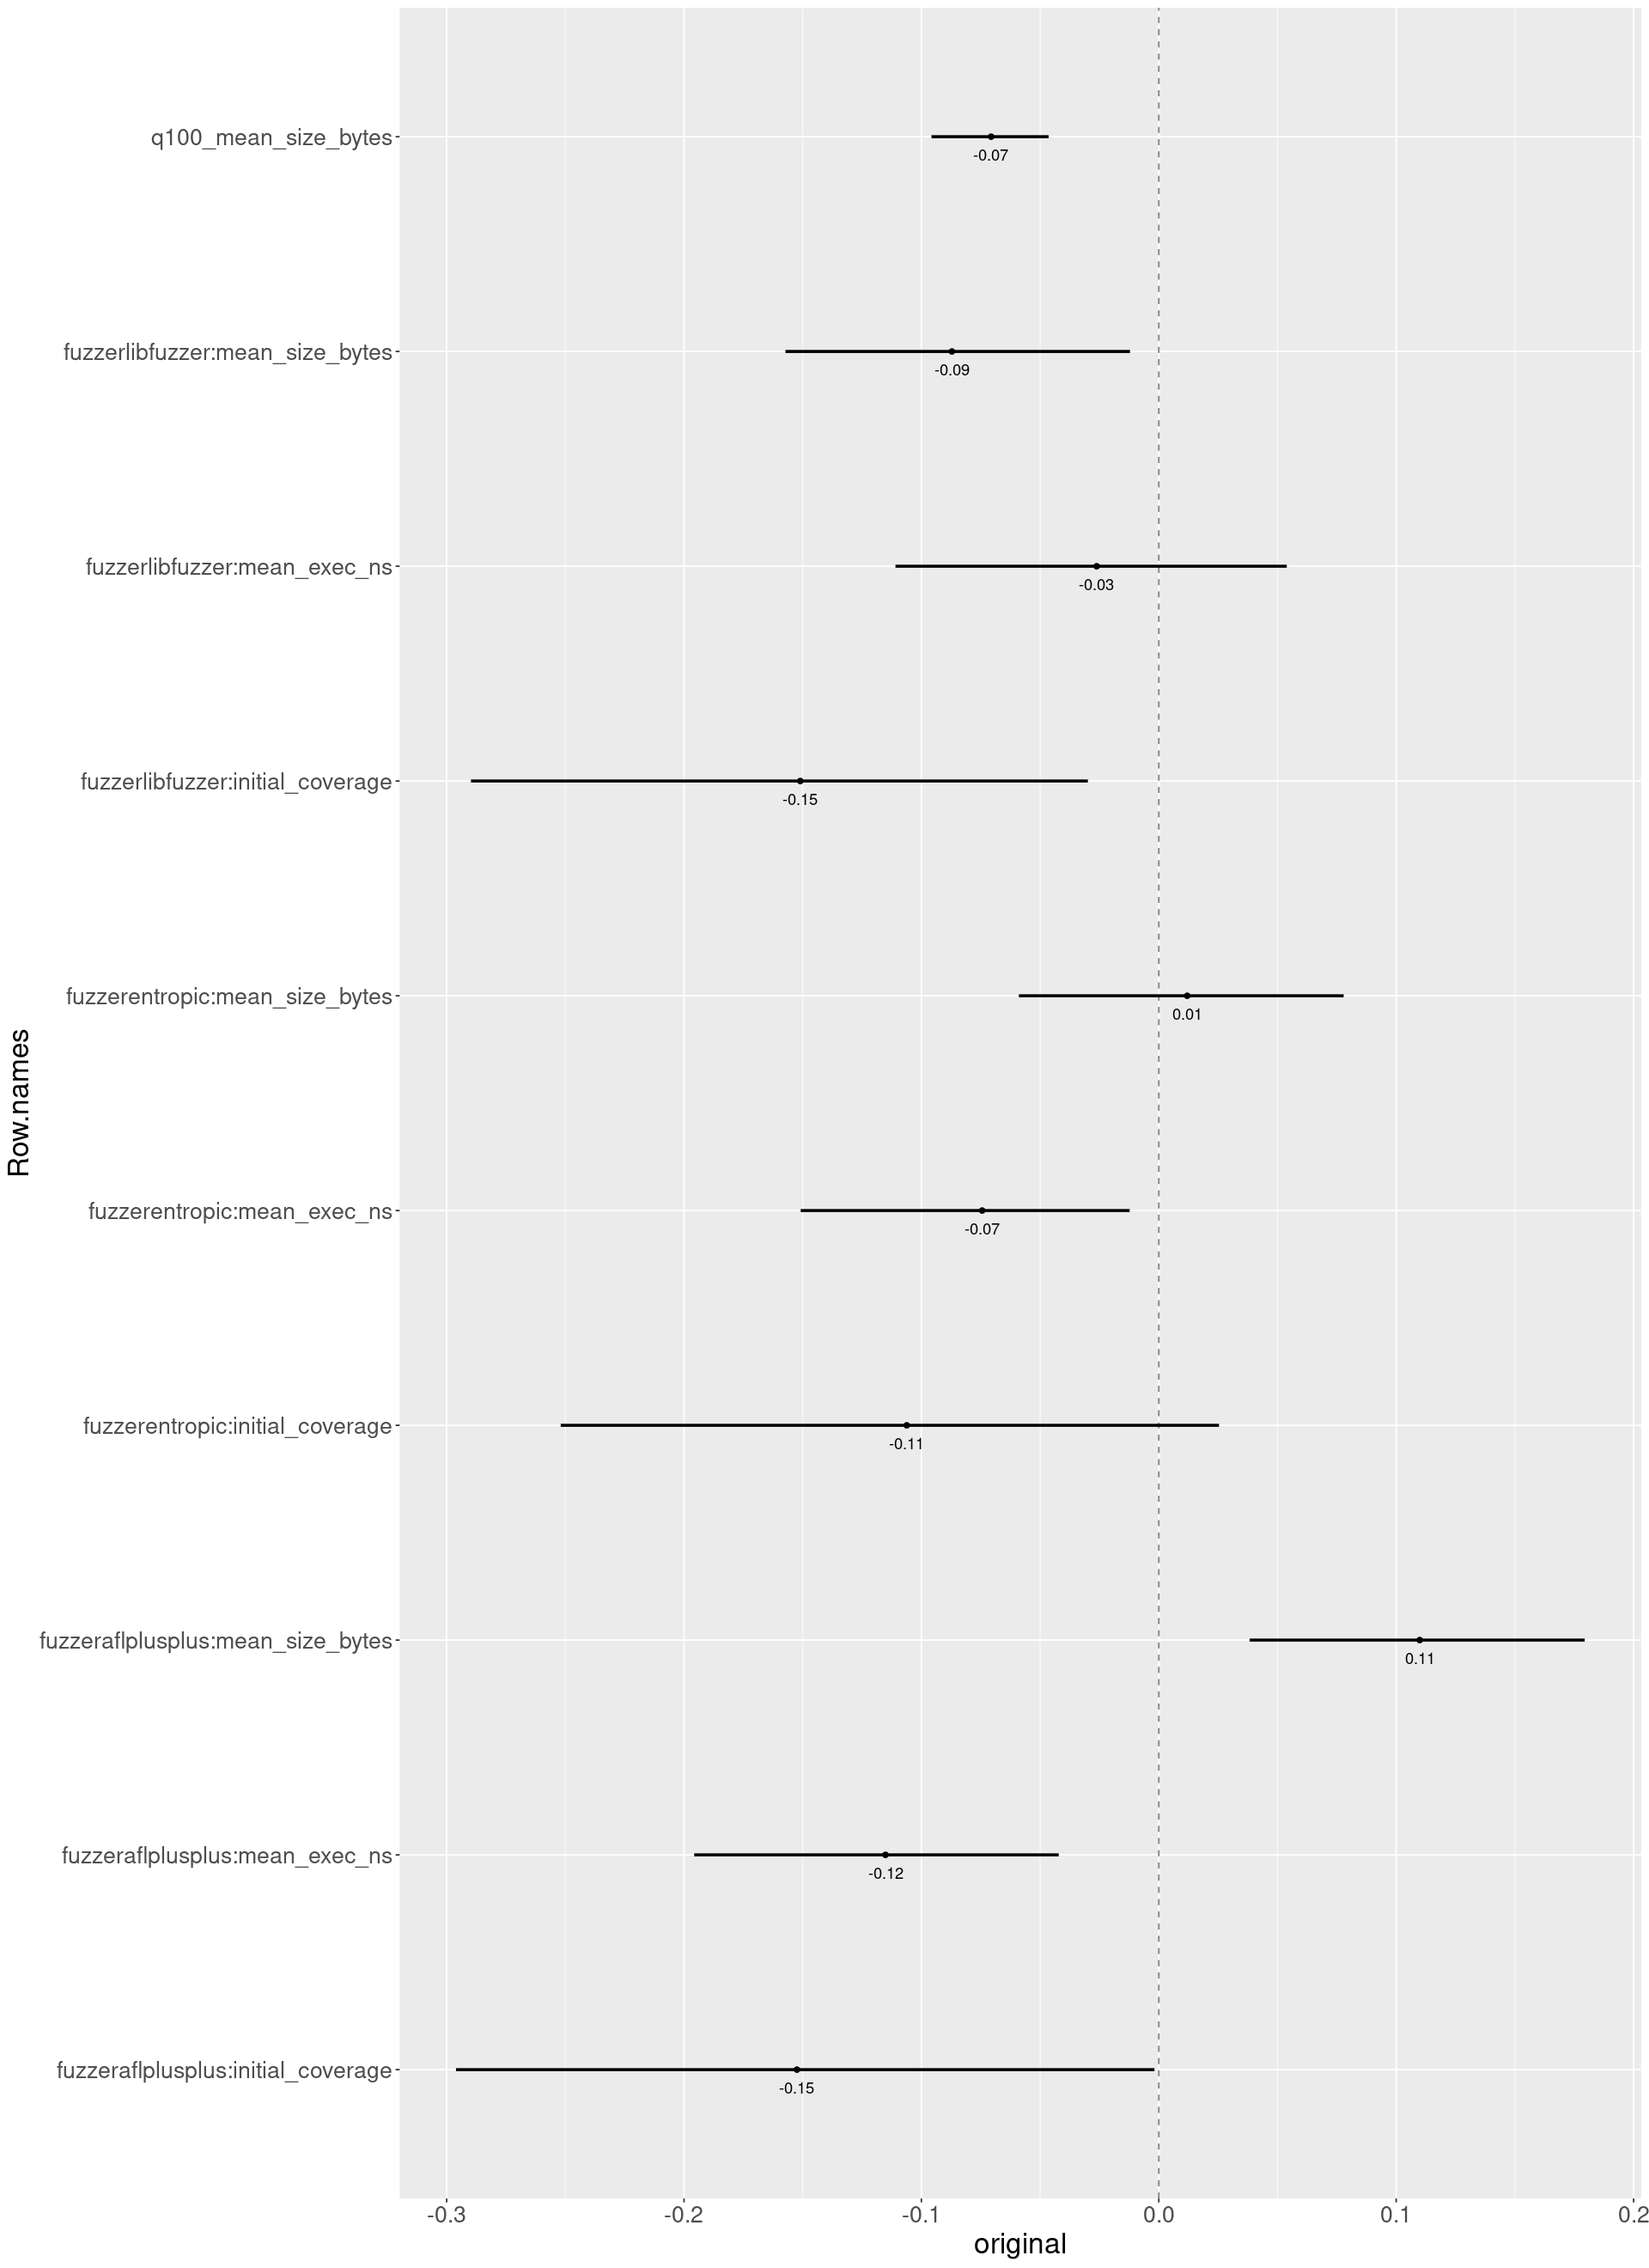

In [91]:
ff <- function(n) {
    (grepl("mean", n, fixed=TRUE) | grepl("initial", n, fixed=TRUE)) & 
        n != "mean_size_bytes" &
        n != "initial_coverage" &
        n != "mean_exec_ns"

}

cnames <- data.frame(colnames(b$t)) %>% filter(ff(colnames.b.t.))


cint <- confint(b)

results <- merge(summary(b), cint, by='row.names')
resutls <- results %>% drop_na()
names(results)[7] <- 'conf95_low'
names(results)[8] <- 'conf95_high'
results[1] <- apply(results[1], 1, toString)




head(results)
results <- results %>% filter(ff(Row.names))



# jpeg("assets/e2-logboot-coef-plot.jpg", width = 800, height = 1000)
ggplot(results, 
       aes(x = Row.names, y = original)) +
        geom_hline(yintercept = 0, 
                   colour = gray(1/2), lty = 2) +
        geom_point(aes(x = Row.names, 
                    y = original)) + 
        geom_linerange(aes(x = Row.names, 
                     ymin = conf95_low,
                     ymax = conf95_high),
                   lwd = 1) +
          geom_text(aes(x = Row.names, 
                y = original,
                label = round(original,2)),
            vjust = 2) +
        coord_flip() + theme(text = element_text(size = 20))
dev.off()

In [241]:
require(texreg)

t <- texreg(b, use.packages=FALSE, scriptsize=FALSE, strong.signif=TRUE)
cat(t,file="assets/e2-boot-table.tex", label="tab:e2-boot-table")

ERROR: Error in extract(l[[i]], ...): Neither texreg nor broom supports models of class boot.
